# Summary Stats for New Genes and Transcripts

### 1) Number of exons for novel genes and transcripts across stringency thresholds.

### 2) Exonic length for transcripts coming from novel RNA isoforms in known genes and novel RNA isoforms in new genes.

### 3) Number of new transcripts and genes with new transcripts for both new RNA isoforms in known genes and new genes.

### 4) Quantification of events giving origin to new isoforms in annotated transcripts. 

### 5) Wordcloud for protein coding and medically relvant transcripts.

### 6) General quantification of all transcripts.

### 7) Quantification of Novel transcripts.

### 8) Quantification of Protein Coding .
        - 8A) Protein Coding Genes.
        - 8B) Protein Coding Transcripts.
        - 8C) Protein Coding Transcripts Encoding Different Proteins.

### 9) Quantification of transcript found between Ensembl Release 94 and 107.

### 10) Quantification of medically relevant and AD relevant genes.

# Library Import and Functions

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

# 1) Number of exons for novel genes and transcripts across stringency thresholds.

In [7]:
## Fix column names in counts matrix

df = pd.read_csv("../../../data/bernardo/raw/uky_aged_stringent/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

In [8]:
## Calculate total counts and fix gene id
df["total_counts"] = df[df.columns[2:6].tolist()].sum(axis=1)

In [9]:
## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))]

In [10]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
df_novel_genes = df.loc[df["gene_id"].str.startswith("BambuGene")].copy()
df_novel_transcripts = df.loc[((df["transcript_id"].str.startswith("BambuTx")) & (~df["gene_id"].str.startswith("BambuGene")))].copy()

In [11]:
## Filter novel genes and transcripts, one only total CPM > 1, other each CPM > 1
cpm_cols = df.columns[2:].tolist()

df_novel_genes_avg = df_novel_genes[df_novel_genes["total_CPM"] > 1].copy()
df_novel_transcripts_avg = df_novel_transcripts[df_novel_transcripts["total_CPM"] > 1].copy()


df_novel_genes_each = df_novel_genes[(df_novel_genes[cpm_cols]>1).sum(axis=1)>=5].copy()
df_novel_transcripts_each = df_novel_transcripts[(df_novel_transcripts[cpm_cols]>1).sum(axis=1)>=5].copy()

In [12]:
## Import and parse through extended annotations
ref = pd.read_csv("../../../data/bernardo/raw/uky_aged_stringent/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


ref = parse_df_columns(ref, is_ref=False)

In [13]:
## Only keep exon entries and add size variable
ref_exons = ref.loc[ref["type"] == "exon"].copy()
ref_exons["size"] = abs(ref_exons["end"] - ref_exons["start"])

In [14]:
## Get reference for novel genes and transcripts at each threshold
ref_novel_gene_avg = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_genes_avg["transcript_id"])].copy()
ref_novel_transcript_avg = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_transcripts_avg["transcript_id"])].copy()

ref_novel_gene_each = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_genes_each["transcript_id"])].copy()
ref_novel_transcript_each = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_transcripts_each["transcript_id"])].copy()

ref_novel_gene = ref_exons.loc[ref_exons["gene_id"].str.startswith("BambuGene")].copy()
ref_novel_transcript = ref_exons.loc[((ref_exons["transcript_id"].str.startswith("BambuTx")) & 
                                      (~ref_exons["gene_id"].str.startswith("BambuGene")))].copy()

In [15]:
## get number of exons for each threshold
ref_novel_gene_avg_num_exons = ref_novel_gene_avg["transcript_id"].value_counts()
ref_novel_transcript_avg_num_exons = ref_novel_transcript_avg["transcript_id"].value_counts()

ref_novel_gene_each_num_exons = ref_novel_gene_each["transcript_id"].value_counts()
ref_novel_transcript_each_num_exons = ref_novel_transcript_each["transcript_id"].value_counts()

ref_novel_gene_num_exons = ref_novel_gene["transcript_id"].value_counts()
ref_novel_transcript_num_exons = ref_novel_transcript["transcript_id"].value_counts()

In [16]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

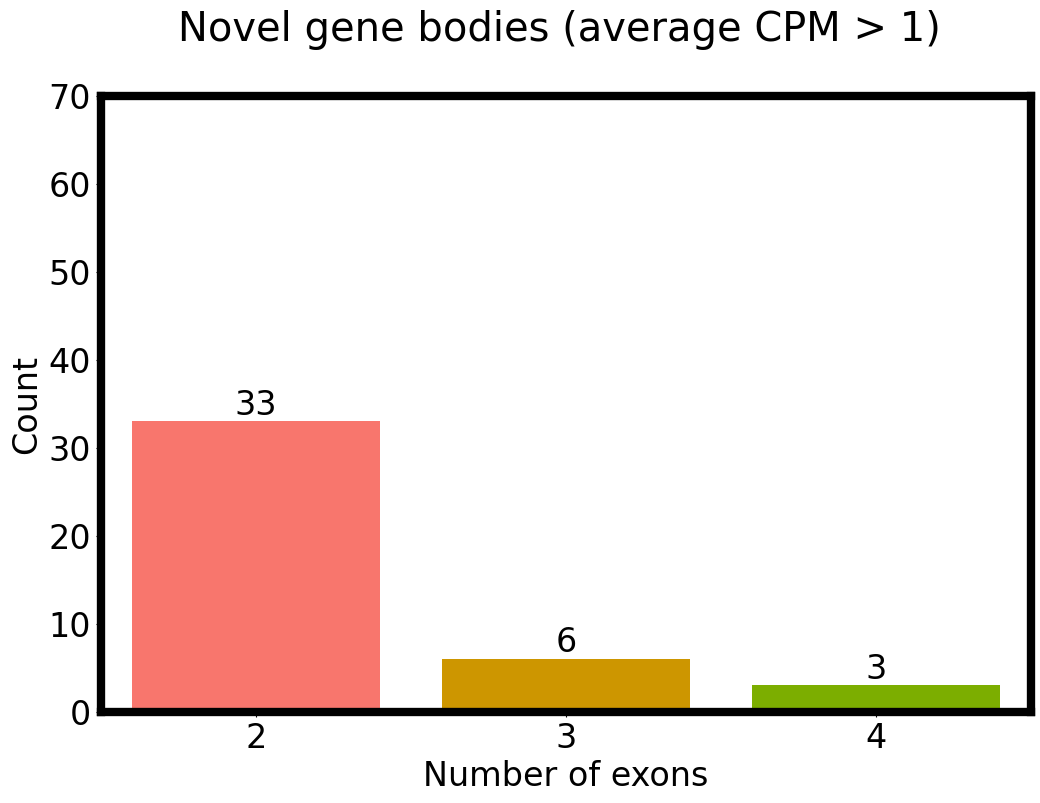

In [17]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_novel_gene_avg_num_exons, palette=ggplot2_colors, saturation=1)
    
for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 70)

plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel gene bodies (average CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_gene_bodies_avg_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_gene_bodies_avg_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

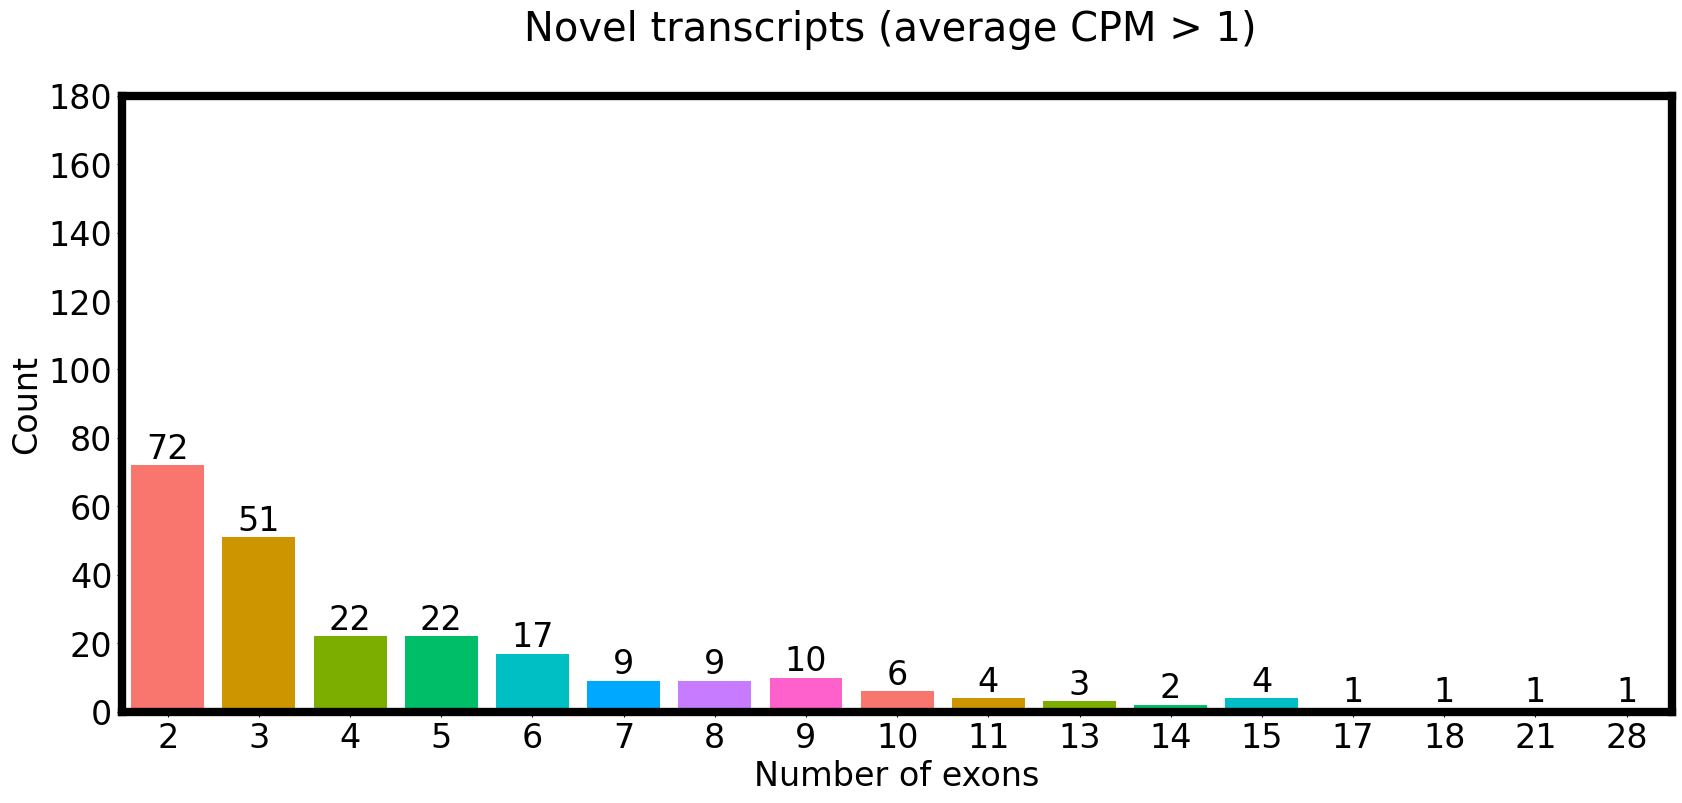

In [18]:
## Make average CPM > 1 transcript number of exons plot and save both as png and svg.

# figure size in inches
rcParams['figure.figsize'] = 20,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

ax = sns.countplot(x=ref_novel_transcript_avg_num_exons, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 180)

plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel transcripts (average CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_transcripts_avg_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_transcripts_avg_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

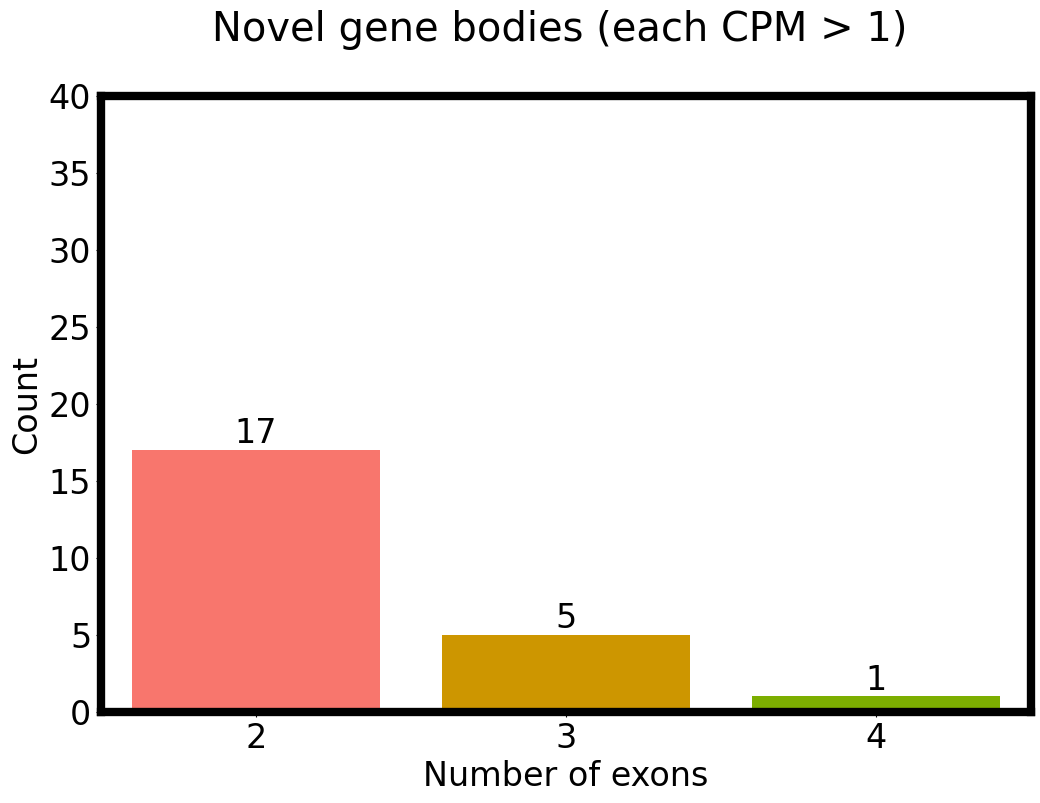

In [19]:
## Make each CPM > 1 gene body number of exons plot and save both as png and svg.

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

ax = sns.countplot(x=ref_novel_gene_each_num_exons, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 40)

plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel gene bodies (each CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_gene_bodies_each_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_gene_bodies_each_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

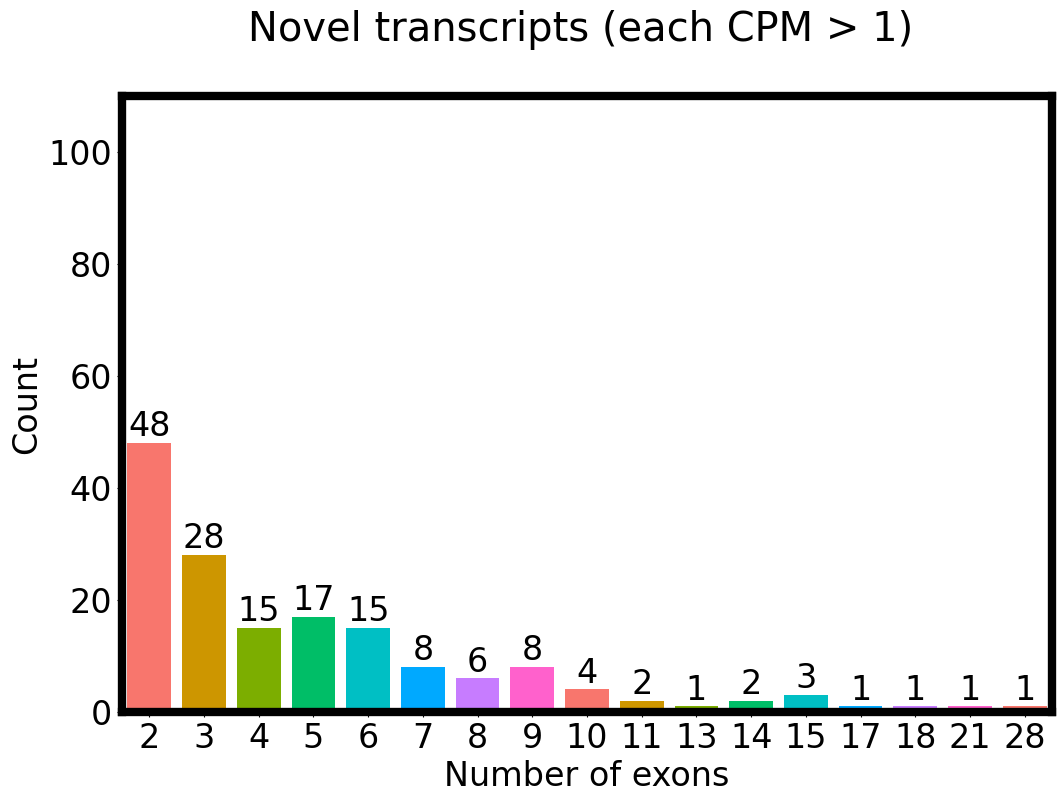

In [20]:
## Make each CPM > 1 transcript number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_novel_transcript_each_num_exons, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 110)

plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel transcripts (each CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_transcripts_each_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_transcripts_each_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

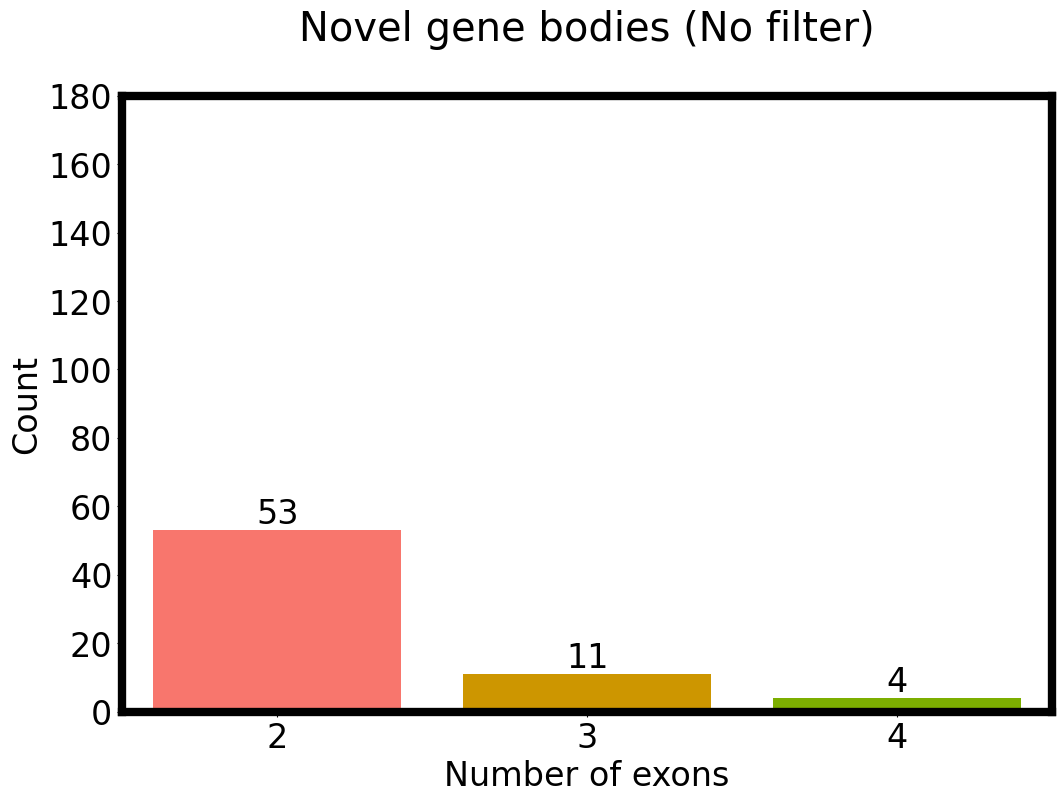

In [21]:
## Make no filter gene body number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_novel_gene_num_exons, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 180)


plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel gene bodies (No filter)\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_gene_bodies_no_filter_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_gene_bodies_no_filter_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

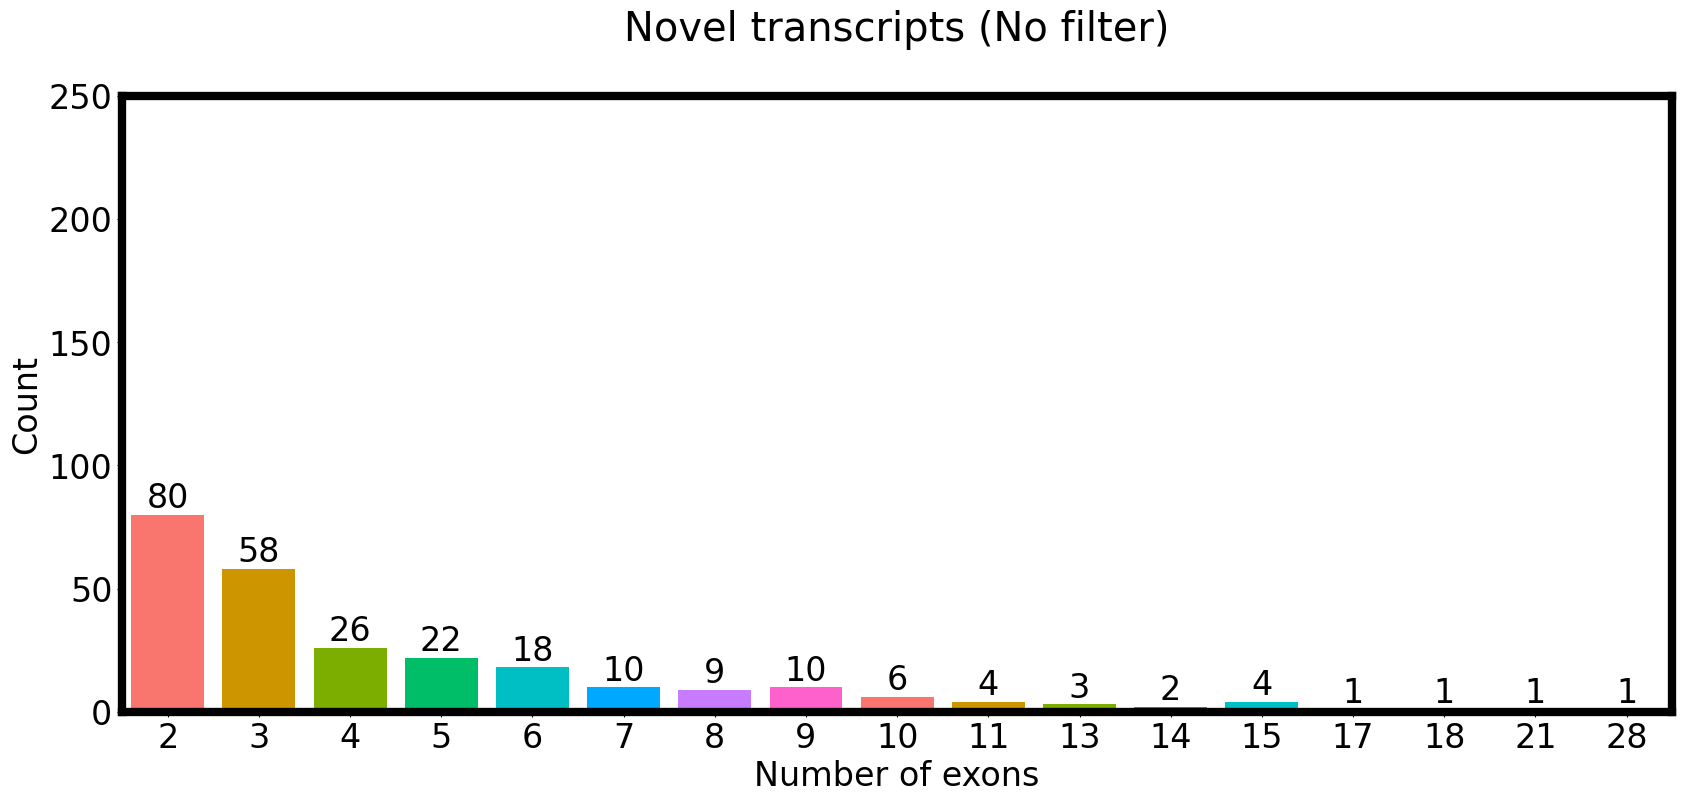

In [22]:
## Make no filter transcript number of exons plot and save both as png and svg.

rcParams['figure.figsize'] = 20,8

ax = sns.countplot(x=ref_novel_transcript_num_exons, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 250)


plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel transcripts (No filter)\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_transcripts_no_filter_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/01/novel_transcripts_no_filter_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 2) Exonic length for transcripts coming from novel RNA isoforms in known genes and novel RNA isoforms in new genes

In [23]:
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

In [24]:
## Create dataframes with exonic length for each transcript
df_exonic_length_novel_genes_avg = ref_novel_gene_avg[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts_avg = ref_novel_transcript_avg[["transcript_id", "size"]].groupby('transcript_id').sum()

df_exonic_length_novel_genes_each = ref_novel_gene_each[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts_each = ref_novel_transcript_each[["transcript_id", "size"]].groupby('transcript_id').sum()

df_exonic_length_novel_genes = ref_novel_gene[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts = ref_novel_transcript[["transcript_id", "size"]].groupby('transcript_id').sum()

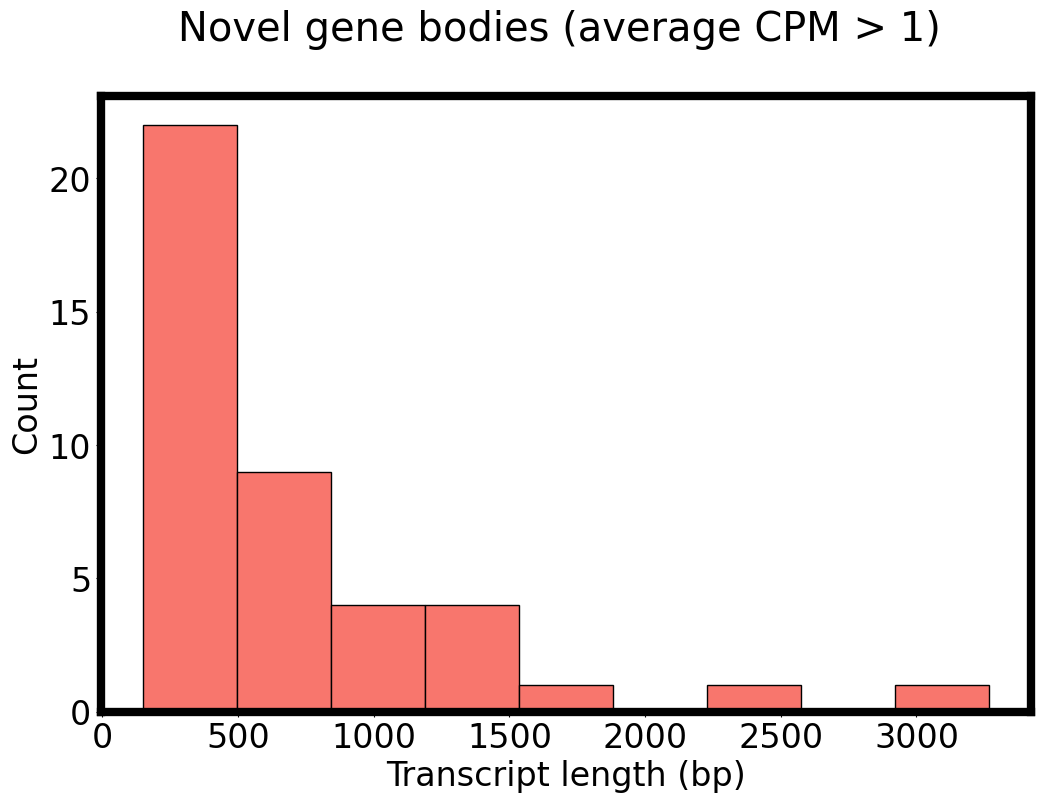

In [25]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_genes_avg["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel gene bodies (average CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_gene_bodies_avg_cpm_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_nnovel_gene_bodies_avg_cpm_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

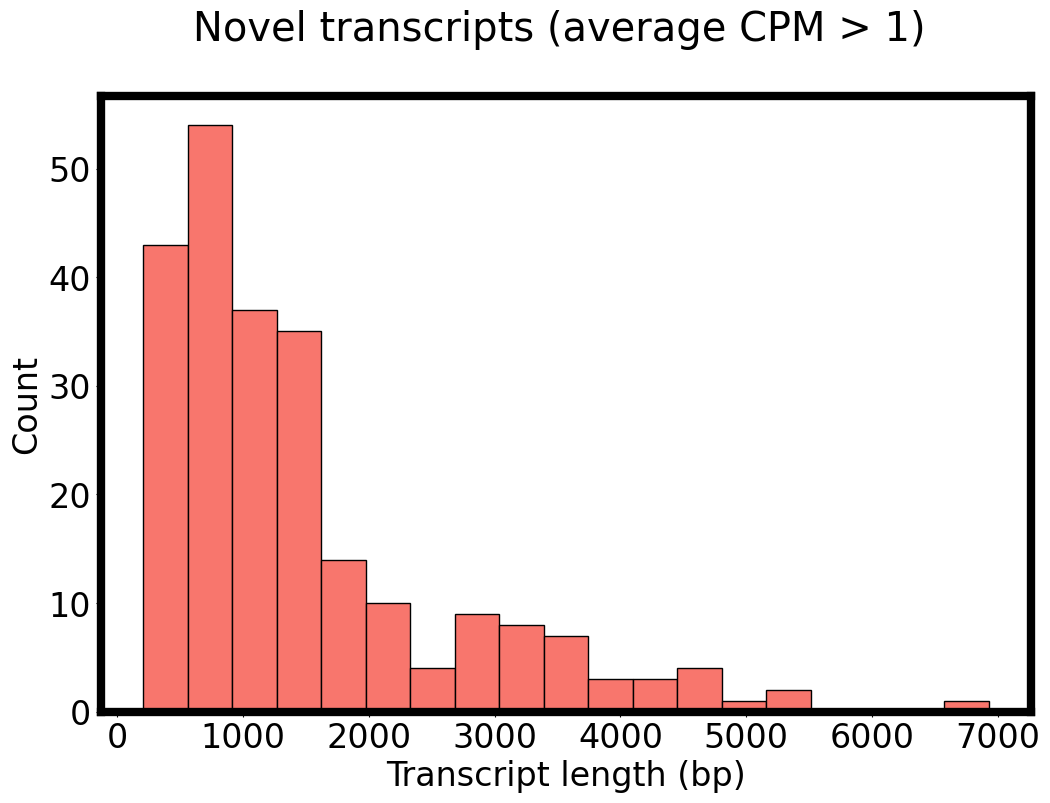

In [26]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts_avg["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel transcripts (average CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_transcripts_avg_cpm_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_transcripts_avg_cpm_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

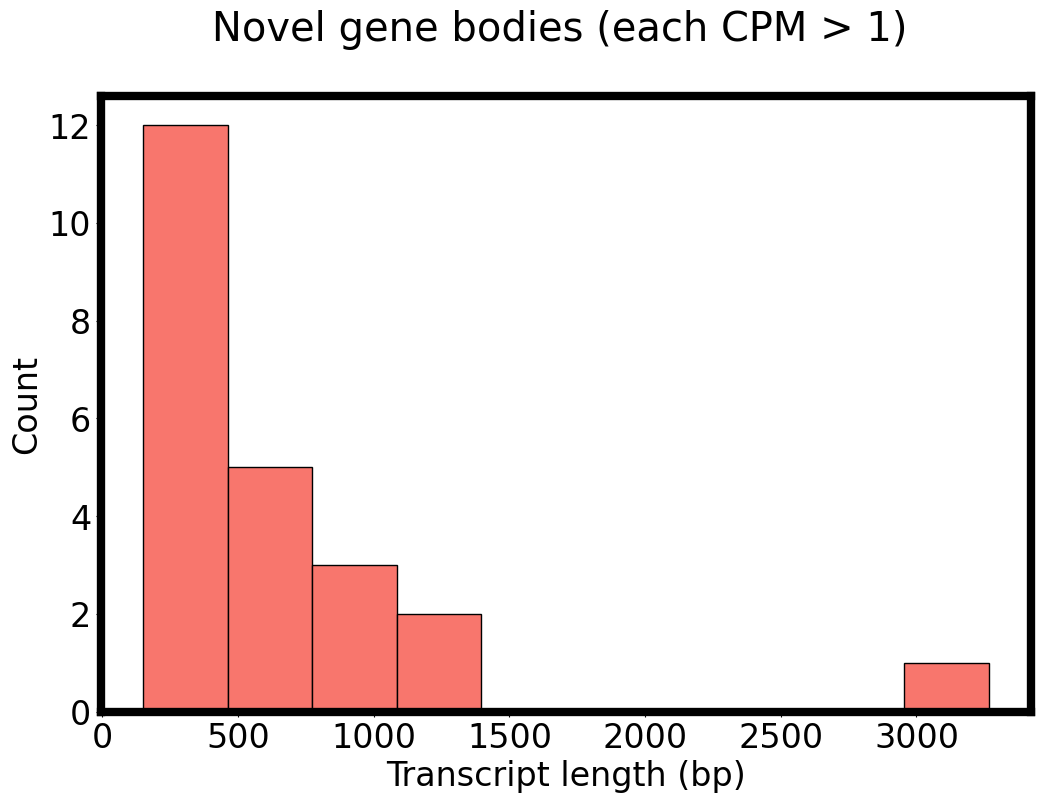

In [27]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_genes_each["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel gene bodies (each CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_gene_bodies_each_cpm_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_gene_bodies_each_cpm_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

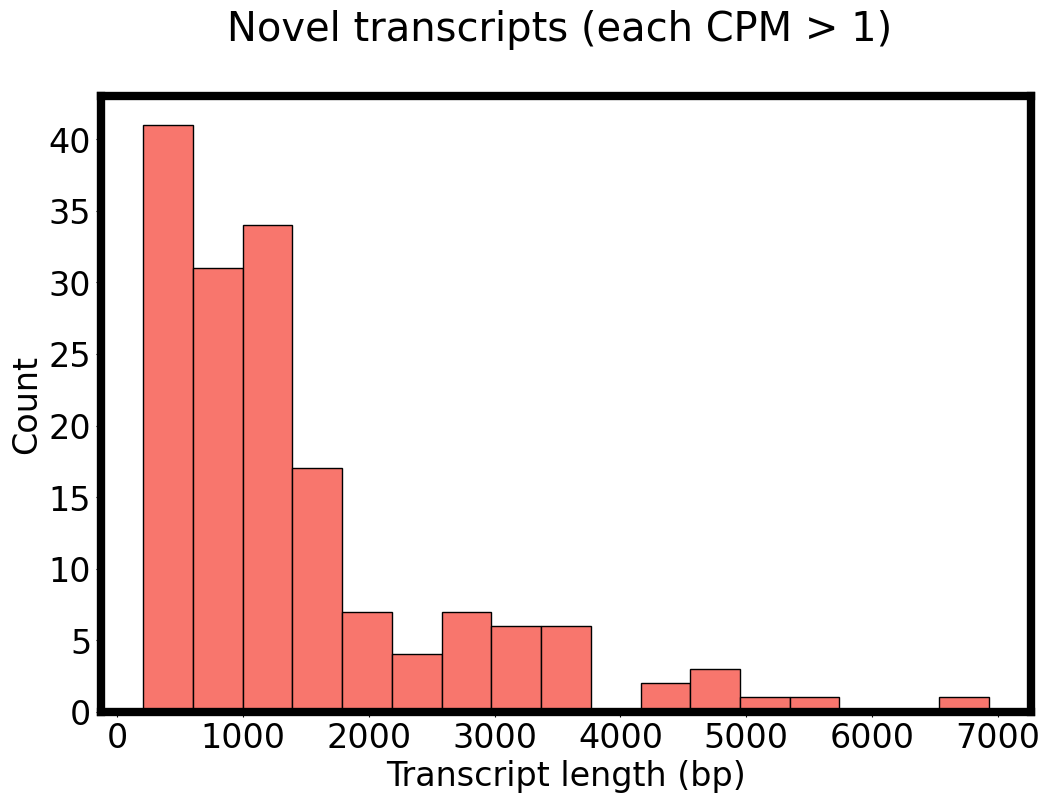

In [28]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts_each["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel transcripts (each CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_transcripts_each_cpm_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_transcripts_each_cpm_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

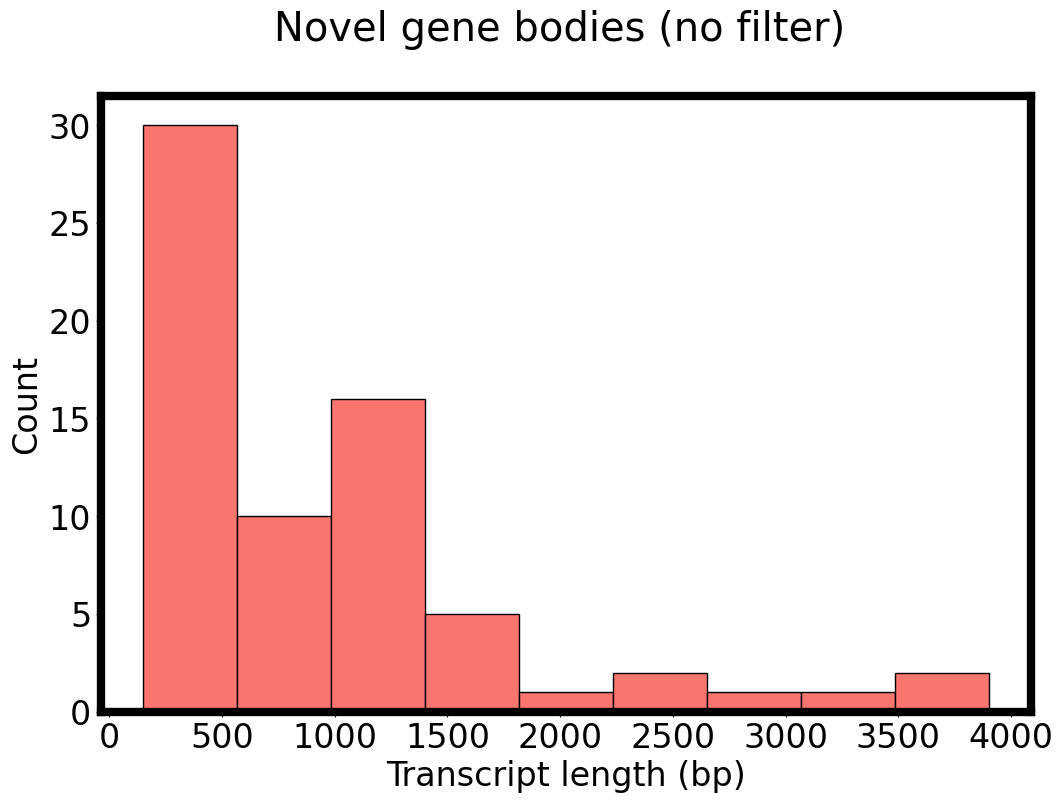

In [29]:
## Make no filter gene body number of exons plot and save both as png and svg.
sns.histplot(x=df_exonic_length_novel_genes["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel gene bodies (no filter) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_gene_bodies_no_filter_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_gene_bodies_no_filter_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

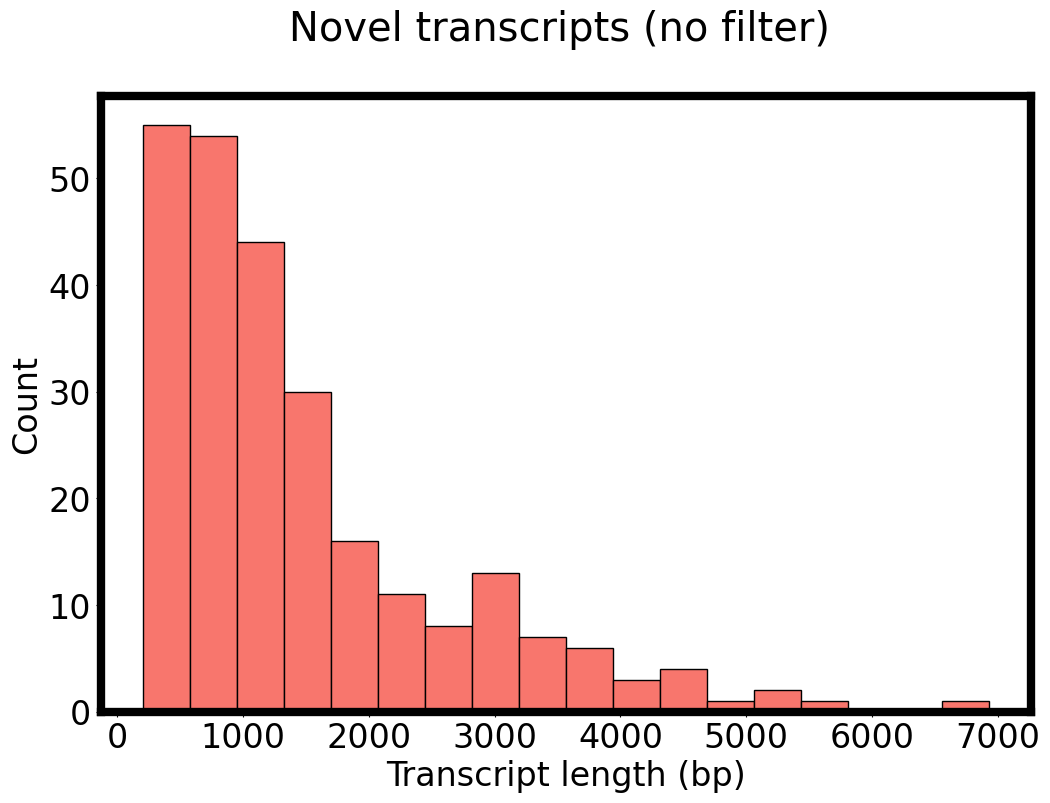

In [30]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel transcripts (no filter) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_transcripts_no_filter_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/02/histogram_novel_transcripts_no_filter_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 3) Number of new transcripts and genes with new transcripts for both new RNA isoforms in known genes and new genes

In [31]:
## Get number of transcripts from each filter from each filter

print("Number of transcripts mapping to novel genes (no filter):", df_novel_genes.shape[0])
print("Number of transcripts mapping to novel genes (average CPM > 1):", df_novel_genes_avg.shape[0])
print("Number of transcripts mapping to novel genes (each CPM > 1):", df_novel_genes_each.shape[0])

print("\n\nNumber of novel transcripts mapping to annotated genes (no filter):", df_novel_transcripts.shape[0])
print("Number of novel transcripts mapping to annotated genes (average CPM > 1):", df_novel_transcripts_avg.shape[0])
print("Number of novel transcripts mapping to annotated genes (each CPM > 1):", df_novel_transcripts_each.shape[0])

Number of transcripts mapping to novel genes (no filter): 68
Number of transcripts mapping to novel genes (average CPM > 1): 42
Number of transcripts mapping to novel genes (each CPM > 1): 23


Number of novel transcripts mapping to annotated genes (no filter): 256
Number of novel transcripts mapping to annotated genes (average CPM > 1): 235
Number of novel transcripts mapping to annotated genes (each CPM > 1): 161


In [32]:
## Get number of genes represented for each filter

print("Number of novel genes represented (no filter):", df_novel_genes["gene_id"].nunique())
print("Number of novel genes represented (average CPM > 1):", df_novel_genes_avg["gene_id"].nunique())
print("Number of novel genes represented (each CPM > 1):", df_novel_genes_each["gene_id"].nunique())


print("\n\nNumber of represented annotated genes with novel transcripts (no filter):", df_novel_transcripts["gene_id"].nunique())
print("Number of represented annotated genes with novel transcripts (average CPM > 1):", df_novel_transcripts_avg["gene_id"].nunique())
print("Number of represented annotated genes with novel transcripts (each CPM > 1):", df_novel_transcripts_each["gene_id"].nunique())

Number of novel genes represented (no filter): 63
Number of novel genes represented (average CPM > 1): 39
Number of novel genes represented (each CPM > 1): 22


Number of represented annotated genes with novel transcripts (no filter): 243
Number of represented annotated genes with novel transcripts (average CPM > 1): 223
Number of represented annotated genes with novel transcripts (each CPM > 1): 157


In [33]:
## Create dataframe for storing transcript numbers
df_num_genes = pd.DataFrame()

## Create list with unique transcripts and genes at each threshold
list_numbers = [df_novel_genes.shape[0], df_novel_genes["gene_id"].nunique(), df_novel_transcripts.shape[0], 
               df_novel_transcripts["gene_id"].nunique(),df_novel_genes_avg.shape[0],
               df_novel_genes_avg["gene_id"].nunique(), df_novel_transcripts_avg.shape[0],
               df_novel_transcripts_avg["gene_id"].nunique(), df_novel_genes_each.shape[0],
               df_novel_genes_each["gene_id"].nunique(), df_novel_transcripts_each.shape[0],
               df_novel_transcripts_each["gene_id"].nunique()]

list_filters = ["No Filter", "No Filter", "No Filter", "No Filter", "Avg CPM > 1", "Avg CPM > 1", "Avg CPM > 1", "Avg CPM > 1",
              "Each CPM > 1", "Each CPM > 1", "Each CPM > 1", "Each CPM > 1"]

list_labels = ["New Gene RNA Isoforms", "New Genes", "New RNA Isoforms from Annotated Genes", "Annotated Genes with New Isoforms", 
              "New Gene RNA Isoforms", "New Genes", "New RNA Isoforms from Annotated Genes", "Annotated Genes with New Isoforms",
              "New Gene RNA Isoforms", "New Genes", "New RNA Isoforms from Annotated Genes", "Annotated Genes with New Isoforms"]

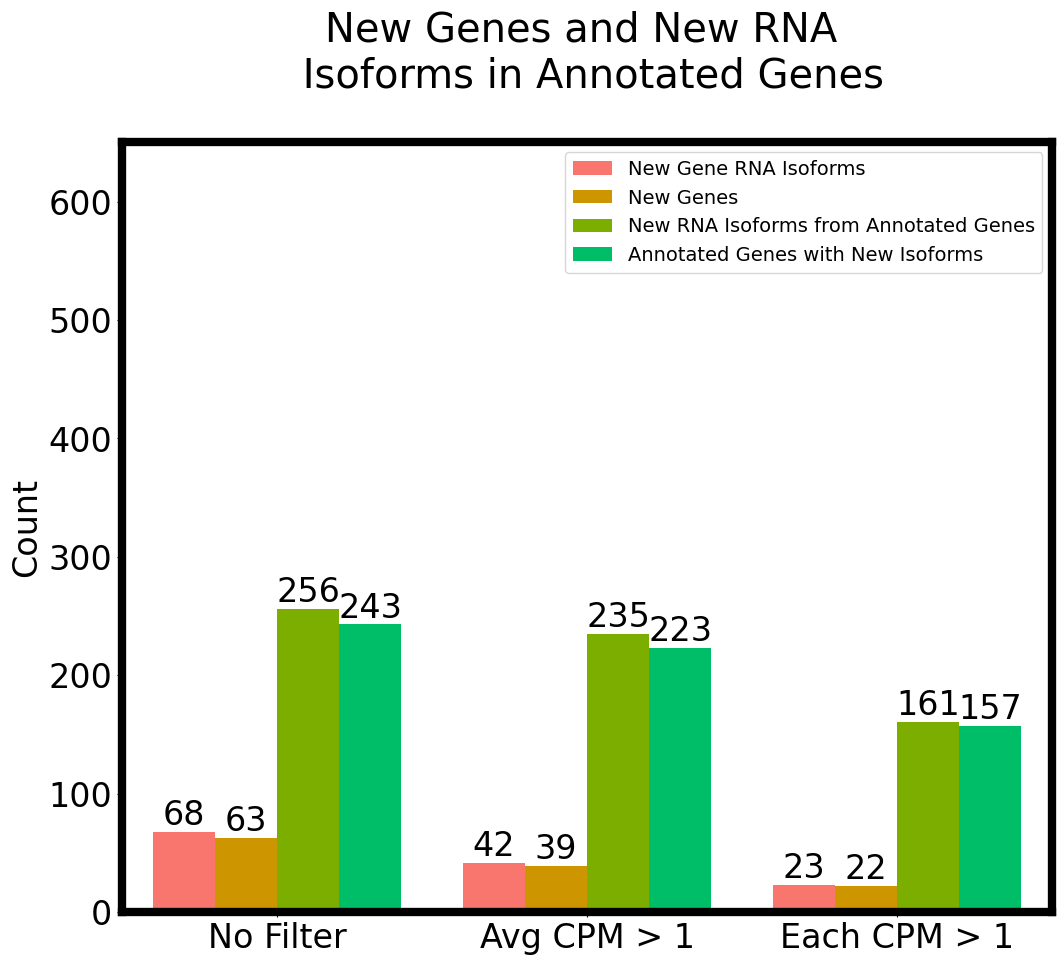

In [34]:
## Make barplot for number of new genes and transcripts

# figure size in inches
rcParams['figure.figsize'] = 12,10
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

ax = sns.barplot(y=list_numbers, x=list_filters, hue=list_labels, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 650)


plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.title("New Genes and New RNA \n Isoforms in Annotated Genes\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/03/barplot_number_of_new_genes_and_isoforms.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/03/barplot_number_of_new_genes_and_isoforms.svg',
            dpi=300, transparent=True, bbox_inches="tight")

In [35]:
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

In [36]:
## Number of isoforms for novel genes (no filter)
num_iso_new_genes = df_novel_genes["gene_id"].value_counts().value_counts()

print(num_iso_new_genes)

1    58
2     5
Name: gene_id, dtype: int64


In [37]:
## Number of isoforms for novel genes (Average CPM > 1)
num_iso_new_genes_avg = df_novel_genes_avg["gene_id"].value_counts().value_counts()

print(num_iso_new_genes_avg)

1    36
2     3
Name: gene_id, dtype: int64


In [38]:
## Number of isoforms for novel genes (Each CPM > 1)
num_iso_new_genes_each = df_novel_genes_each["gene_id"].value_counts().value_counts()

print(num_iso_new_genes_each)

1    21
2     1
Name: gene_id, dtype: int64


In [39]:
## Number of new isoforms for transcripts mapping to annotated genes (no filter)
num_iso_new_transcripts = df_novel_transcripts["gene_id"].value_counts().value_counts()

print(num_iso_new_transcripts)

1    231
2     11
3      1
Name: gene_id, dtype: int64


In [40]:
## Number of new isoforms for transcripts mapping to annotated genes (Average CPM > 1)
num_iso_new_transcripts_avg = df_novel_transcripts_avg["gene_id"].value_counts().value_counts()

print(num_iso_new_transcripts_avg)

1    211
2     12
Name: gene_id, dtype: int64


In [41]:
## Number of new isoforms for transcripts mapping to annotated genes (Each CPM > 1)
num_iso_new_transcripts_each = df_novel_transcripts_each["gene_id"].value_counts().value_counts()

print(num_iso_new_transcripts_each)

1    153
2      4
Name: gene_id, dtype: int64


In [42]:
## Create lists that will go into the graph for number of genes with multiple new isoforms

numbers = [num_iso_new_genes.to_list(), num_iso_new_genes_avg.to_list(), num_iso_new_genes_each.to_list(),
          num_iso_new_transcripts.to_list(), num_iso_new_transcripts_avg.to_list(), num_iso_new_transcripts_each.to_list()]

filters_list = ["No Filter", "No Filter", "Avg CPM > 1", "Avg CPM > 1", "Each CPM > 1", "Each CPM > 1",
          "No Filter", "No Filter", "Avg CPM > 1", "Avg CPM > 1", "Each CPM > 1", "Each CPM > 1"]

description_list = ["New Gene 1 Isoform", "New Gene 2+ Isoforms",
               "New Gene 1 Isoform", "New Gene 2+ Isoforms", "New Gene 1 Isoform", "New Gene 2+ Isoforms",
              "Annotated Gene 1 New Isoform", "Annotated Gene 2+ New Isoform", "Annotated Gene 1 New Isoform", 
                "Annotated Gene 2+ New Isoform", "Annotated Gene 1 New Isoform", "Annotated Gene 2+ New Isoform"]

In [43]:
## Create list with number of genes with 1 isoform an multiple isoforms across stringency thresholds.
## Separate by new genes and annotated genes

list_numbers = []

for i in range(len(numbers)):
    
    sum_multiple_iso = 0
    
    if len(numbers[i]) == 1:
        
        numbers_list.append(numbers[i][0]) 
        numbers_list.append(0)
    
    else:
        
        for j in range(len(numbers[i])):
        
            if j == 0:
                list_numbers.append(numbers[i][j])
            
            else:
                sum_multiple_iso += numbers[i][j]
        
        list_numbers.append(sum_multiple_iso)
        sum_multiple_iso = 0  

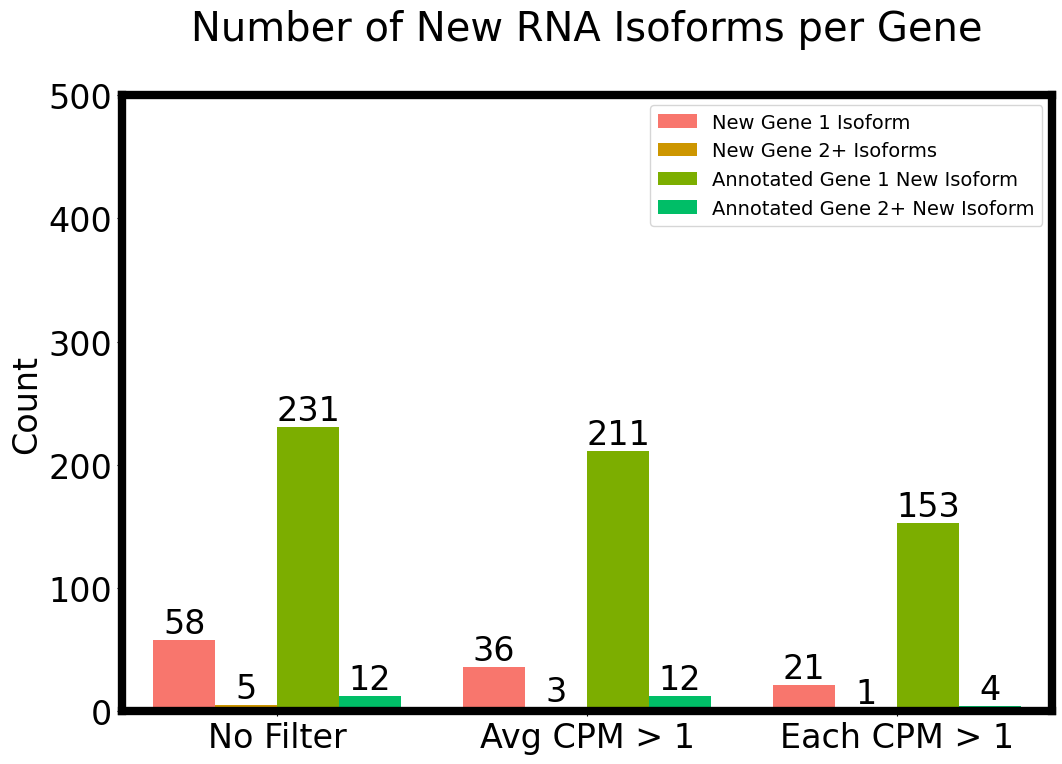

In [44]:
## Make graph for number of new genes with multiple isoforms
ax = sns.barplot(y=list_numbers, x=filters_list, hue=description_list, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 500)


plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.title("Number of New RNA Isoforms per Gene\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/03/barplot_number_of_rna_isoforms_per_gene.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/03/barplot_number_of_rna_isoforms_per_gene.svg',
            dpi=300, transparent=True, bbox_inches="tight")

# 4) Quantification of events giving origin to new isoforms in annotated transcripts.

In [45]:
## Import Data
df_events = pd.read_csv("../../../data/bernardo/processed/03.gene_and_transcripts_descriptive_stats/uky_aged_stringent_novel_events.tsv", sep="\t")

In [46]:
## Remove new genes
df_events = df_events.loc[df_events["txClassDescription"] != "newGene-spliced"].copy()

In [47]:
## Cleanup net transcript classes
df_events.loc[df_events["txClassDescription"] == "newWithin", "txClassDescription"] = "New Combo of known Junctions/Exons"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newFirstExon", "txClassDescription"] = "New First Exon"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newLastExon", "txClassDescription"] = "New Last Exon"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction", "txClassDescription"] = "New Last Exon"
df_events.loc[df_events["txClassDescription"] == "allNew", "txClassDescription"] = "All New"

df_events.loc[df_events["txClassDescription"] == "newFirstJunction", "txClassDescription"] = "New Junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newJunction", "txClassDescription"] = "New Junction"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newJunction", "txClassDescription"] = "New Junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction", "txClassDescription"] = "New Junction"
df_events.loc[df_events["txClassDescription"] == "newJunction", "txClassDescription"] = "New Junction"

df_events.loc[df_events["txClassDescription"] == "newLastJunction:newJunction:newLastExon", "txClassDescription"] = "New Last Exon & New Junction"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newJunction:newFirstExon", "txClassDescription"] = "New First Exon & New Junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newFirstExon:newLastExon", "txClassDescription"] = "New First & Last Exon & New Junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newFirstExon", "txClassDescription"] = "New First Exon & New Junction"


In [48]:
## Create dataframes for the two stringency thresholds
df_events_avg = df_events.loc[df_events["TXNAME"].isin(df_novel_transcripts_avg["transcript_id"])]
df_events_each = df_events.loc[df_events["TXNAME"].isin(df_novel_transcripts_each["transcript_id"])]


In [49]:
## Get counts of events no filter
df_events["txClassDescription"].value_counts()

All New                                 95
New Combo of known Junctions/Exons      60
New Junction                            52
New Last Exon                           21
New First Exon                          11
New Last Exon & New Junction             7
New First Exon & New Junction            5
New First & Last Exon & New Junction     5
Name: txClassDescription, dtype: int64

In [50]:
## Get counts of events avg CPM > 1
df_events_avg["txClassDescription"].value_counts()

All New                                 84
New Combo of known Junctions/Exons      58
New Junction                            48
New Last Exon                           20
New First Exon                          11
New Last Exon & New Junction             6
New First Exon & New Junction            5
New First & Last Exon & New Junction     3
Name: txClassDescription, dtype: int64

In [51]:
## Get counts of events each CPM > 1
df_events_each["txClassDescription"].value_counts()

All New                                 54
New Combo of known Junctions/Exons      46
New Junction                            31
New Last Exon                           13
New First Exon                           6
New First Exon & New Junction            4
New Last Exon & New Junction             4
New First & Last Exon & New Junction     3
Name: txClassDescription, dtype: int64

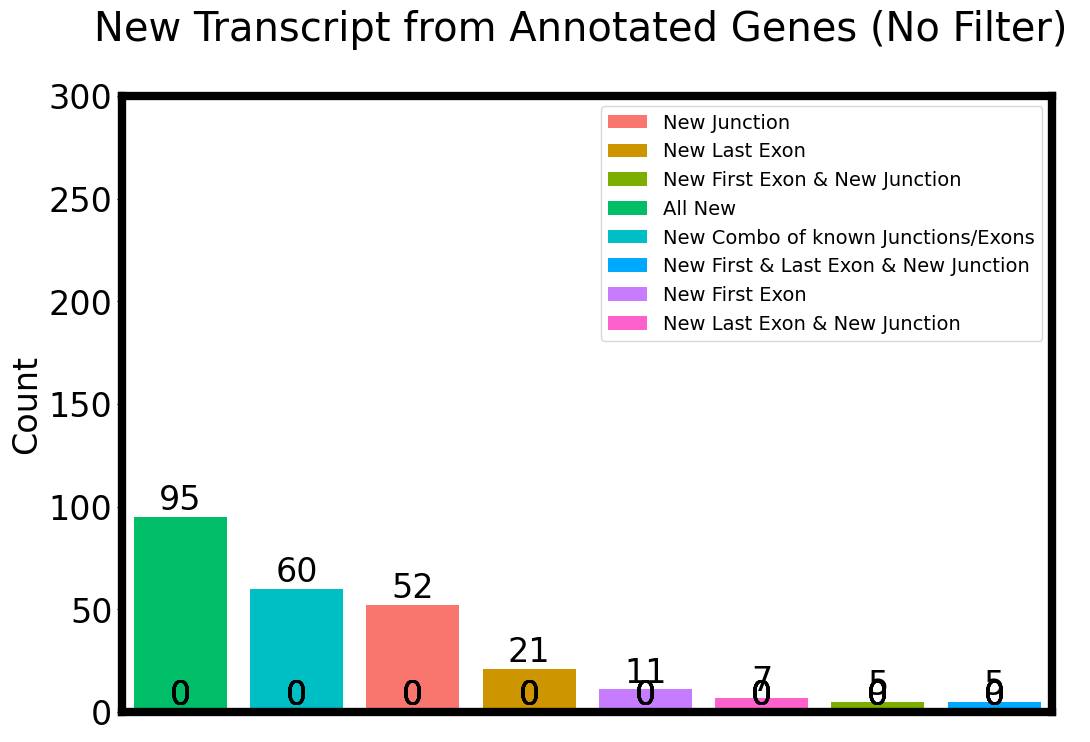

In [52]:
## Make graph of new transcript events for no filter

ax = sns.countplot(x=df_events["txClassDescription"], hue=df_events["txClassDescription"], dodge=False, palette=ggplot2_colors, saturation=1,
                  order=df_events["txClassDescription"].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 300)

plt.xticks(rotation=90)
plt.tick_params(labelsize=None)

plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.xlabel("")
plt.title("New Transcript from Annotated Genes (No Filter) \n")
plt.xticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/04/barplot_events_new_transcripts_no_filter.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/04/barplot_events_new_transcripts_no_filter.svg',
           dpi=300, transparent=True, bbox_inches="tight")

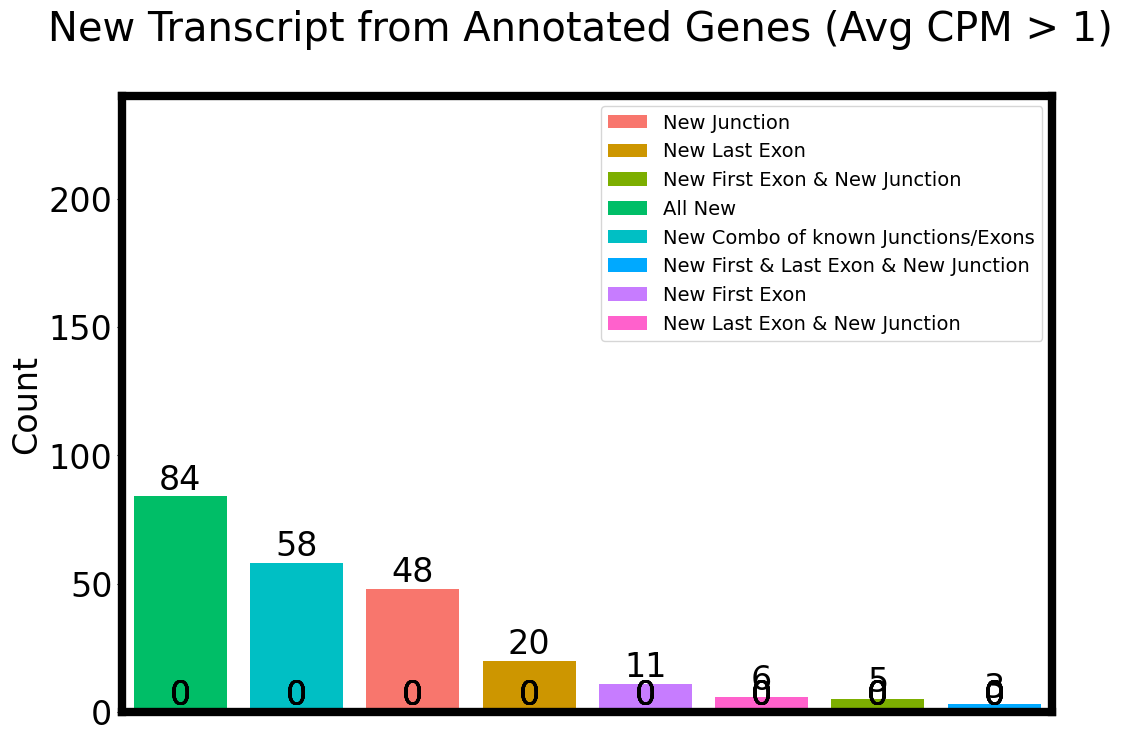

In [53]:
## Make graph of new transcript events for avg CPM > 1

ax = sns.countplot(x=df_events_avg["txClassDescription"], hue=df_events_avg["txClassDescription"], dodge=False, palette=ggplot2_colors, saturation=1,
                  order=df_events_avg["txClassDescription"].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 240)

plt.xticks(rotation=90)
plt.tick_params(labelsize=None)



plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.xlabel("")
plt.title("New Transcript from Annotated Genes (Avg CPM > 1) \n")
plt.xticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/04/barplot_events_new_transcripts_avg.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/04/barplot_events_new_transcripts_avg.svg',
           dpi=300, transparent=True, bbox_inches="tight")

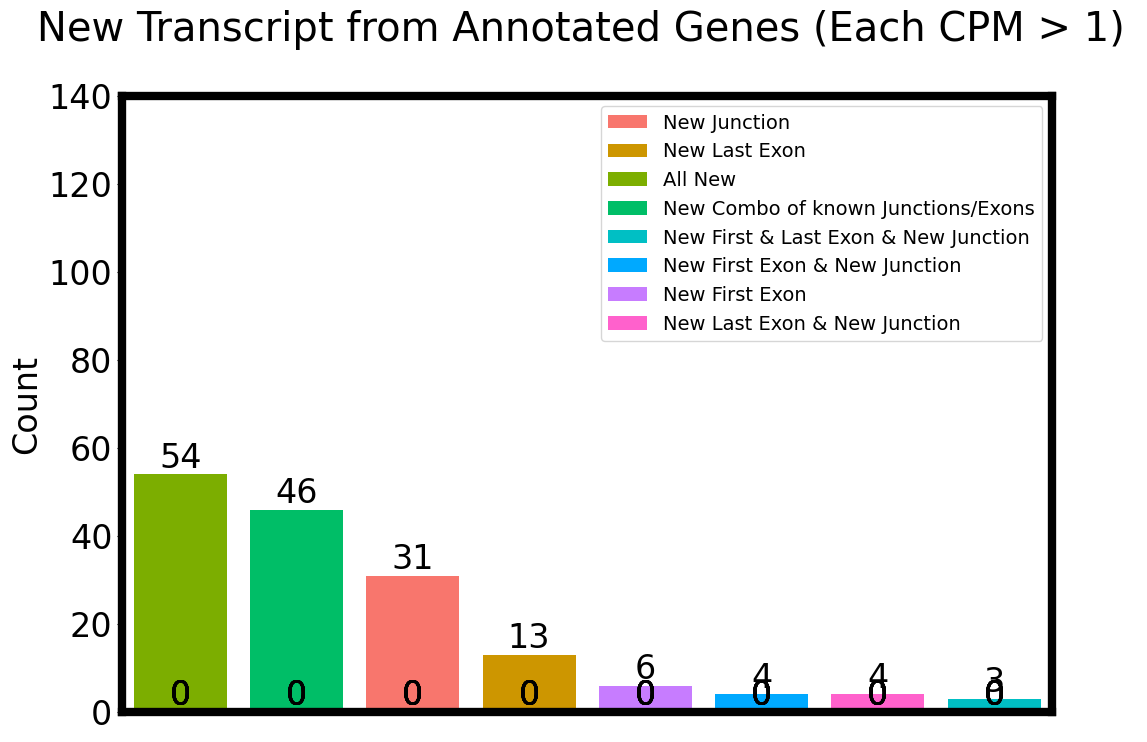

In [54]:
## Make graph of new transcript events for each CPM > 1

ax = sns.countplot(x=df_events_each["txClassDescription"], hue=df_events_each["txClassDescription"], dodge=False, palette=ggplot2_colors, saturation=1,
                  order=df_events_each["txClassDescription"].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 140)

plt.xticks(rotation=90)
plt.tick_params(labelsize=None)

plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.xlabel("")
plt.title("New Transcript from Annotated Genes (Each CPM > 1) \n")
plt.xticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/04/barplot_events_new_transcripts_each.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/04/barplot_events_new_transcripts_each.svg',
           dpi=300, transparent=True, bbox_inches="tight")

# 5) Wordcloud for protein coding and medically relvant transcripts

In [55]:
## Open original reference
original_ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

In [56]:
## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

In [57]:
## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../../references/bernardo/medically_relevant_genes.tsv", sep="\t")

## Import AD Genes
ad_names = pd.read_csv("../../../references/bernardo/AD_gwas_genes.tsv", sep="\t")

In [58]:
## Create disease relevant list including chromosome
disease_relevant_genes_annotated = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name", "chr"]], 
                                                               how="inner", on=["gene_id", "gene_name"])

In [59]:
## Create list of protein coding genes
protein_coding_ref = orig_ref.loc[orig_ref["gene_biotype"] == "protein_coding"].copy()

In [60]:
## Create list o disease relevant novel transcripts for three stringency thresholds
novel_relevant = df_novel_transcripts.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

novel_relevant_avg = df_novel_transcripts_avg.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

novel_relevant_each = df_novel_transcripts_each.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")   

df_novel_transcripts_avg_5 = df_novel_transcripts_avg.loc[df_novel_transcripts_avg["total_CPM"] > 5].copy()
novel_relevant_avg_5 = df_novel_transcripts_avg_5.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [61]:
## Create list of novel transcripts belonging to protein coding genes for three stringency thresholds
protein_relevant = df_novel_transcripts.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

protein_relevant_avg = df_novel_transcripts_avg.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

protein_relevant_each = df_novel_transcripts_each.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner") 

protein_relevant_avg_5 = df_novel_transcripts_avg_5.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [62]:
## Drop any duplicates
novel_relevant.drop_duplicates(inplace=True)
novel_relevant_avg.drop_duplicates(inplace=True)
novel_relevant_each.drop_duplicates(inplace=True)
novel_relevant_avg_5.drop_duplicates(inplace=True)

protein_relevant.drop_duplicates(inplace=True)
protein_relevant_avg.drop_duplicates(inplace=True)
protein_relevant_each.drop_duplicates(inplace=True)
protein_relevant_avg_5.drop_duplicates(inplace=True)

In [63]:
## Remove MT transcripts
novel_relevant = novel_relevant.loc[novel_relevant["chr"] != "MT"]
novel_relevant_avg = novel_relevant_avg.loc[novel_relevant_avg["chr"] != "MT"]
novel_relevant_each = novel_relevant_each.loc[novel_relevant_each["chr"] != "MT"]
novel_relevant_avg_5 = novel_relevant_avg_5.loc[novel_relevant_avg_5["chr"] != "MT"]

protein_relevant = protein_relevant.loc[protein_relevant["chr"] != "MT"]
protein_relevant_avg = protein_relevant_avg.loc[protein_relevant_avg["chr"] != "MT"]
protein_relevant_each = protein_relevant_each.loc[protein_relevant_each["chr"] != "MT"]
protein_relevant_avg_5 = protein_relevant_avg_5.loc[protein_relevant_avg_5["chr"] != "MT"]

In [64]:
## Get all transcript from the same gene as the new transcripts so we can calculate relative abundance of 
## New transcripts in each gene
novel_relevant_counts = pd.merge(df, novel_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
novel_relevant_avg_counts = pd.merge(df, novel_relevant_avg[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
novel_relevant_each_counts = pd.merge(df, novel_relevant_each[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
novel_relevant_avg_5_counts = pd.merge(df, novel_relevant_avg_5[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

protein_relevant_counts = pd.merge(df, protein_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
protein_relevant_avg_counts = pd.merge(df, protein_relevant_avg[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
protein_relevant_each_counts = pd.merge(df, protein_relevant_each[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
protein_relevant_avg_5_counts = pd.merge(df, protein_relevant_avg_5[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [65]:
## Calculate relative transcript abundance
novel_relevant_relative_abundance = relative_transcript_abundance(novel_relevant_counts)
novel_relevant_avg_relative_abundance = relative_transcript_abundance(novel_relevant_avg_counts)
novel_relevant_each_relative_abundance = relative_transcript_abundance(novel_relevant_each_counts)
novel_relevant_avg_5_relative_abundance = relative_transcript_abundance(novel_relevant_avg_5_counts)

protein_relevant_relative_abundance = relative_transcript_abundance(protein_relevant_counts)
protein_relevant_avg_relative_abundance = relative_transcript_abundance(protein_relevant_avg_counts)
protein_relevant_each_relative_abundance = relative_transcript_abundance(protein_relevant_each_counts)
protein_relevant_avg_5_relative_abundance = relative_transcript_abundance(protein_relevant_avg_5_counts)

In [66]:
## Annotate novel transcripts on relative abundance table
novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_relative_abundance.loc[~novel_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

novel_relevant_avg_relative_abundance.loc[novel_relevant_avg_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_avg_relative_abundance.loc[~novel_relevant_avg_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

novel_relevant_each_relative_abundance.loc[novel_relevant_each_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_each_relative_abundance.loc[~novel_relevant_each_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

novel_relevant_avg_5_relative_abundance.loc[novel_relevant_avg_5_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_avg_5_relative_abundance.loc[~novel_relevant_avg_5_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False



protein_relevant_relative_abundance.loc[protein_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_relative_abundance.loc[~protein_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

protein_relevant_avg_relative_abundance.loc[protein_relevant_avg_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_avg_relative_abundance.loc[~protein_relevant_avg_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

protein_relevant_each_relative_abundance.loc[protein_relevant_each_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_each_relative_abundance.loc[~protein_relevant_each_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

protein_relevant_avg_5_relative_abundance.loc[protein_relevant_avg_5_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_avg_5_relative_abundance.loc[~protein_relevant_avg_5_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

In [67]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_words = novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

novel_relevant_avg_words = novel_relevant_avg_relative_abundance.loc[novel_relevant_avg_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

novel_relevant_each_words = novel_relevant_each_relative_abundance.loc[novel_relevant_each_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

novel_relevant_avg_5_words = novel_relevant_avg_5_relative_abundance.loc[novel_relevant_avg_5_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()


protein_relevant_words = protein_relevant_relative_abundance.loc[protein_relevant_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

protein_relevant_avg_words = protein_relevant_avg_relative_abundance.loc[protein_relevant_avg_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

protein_relevant_each_words = protein_relevant_each_relative_abundance.loc[protein_relevant_each_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

protein_relevant_avg_5_words = protein_relevant_avg_5_relative_abundance.loc[protein_relevant_avg_5_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

In [68]:
## Drop duplicates
novel_relevant_words = novel_relevant_words.drop_duplicates()
novel_relevant_avg_words = novel_relevant_avg_words.drop_duplicates()
novel_relevant_each_words = novel_relevant_each_words.drop_duplicates()
novel_relevant_avg_5_words = novel_relevant_avg_5_words.drop_duplicates()


protein_relevant_words = protein_relevant_words.drop_duplicates()
protein_relevant_avg_words = protein_relevant_avg_words.drop_duplicates()
protein_relevant_each_words = protein_relevant_each_words.drop_duplicates()
protein_relevant_avg_5_words = protein_relevant_avg_5_words.drop_duplicates()

In [69]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_words = round(novel_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
novel_relevant_avg_words = round(novel_relevant_avg_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
novel_relevant_each_words = round(novel_relevant_each_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
novel_relevant_avg_5_words = round(novel_relevant_avg_5_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)


protein_relevant_words = round(protein_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
protein_relevant_avg_words = round(protein_relevant_avg_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
protein_relevant_each_words = round(protein_relevant_each_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
protein_relevant_avg_5_words = round(protein_relevant_avg_5_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [70]:
## Create a dataframe to properly store the data
novel_relevant_words_df = pd.DataFrame()
novel_relevant_words_df['word_count'] = novel_relevant_words
novel_relevant_words_df["gene_name"] = novel_relevant_words.index

novel_relevant_avg_words_df = pd.DataFrame()
novel_relevant_avg_words_df['word_count'] = novel_relevant_avg_words
novel_relevant_avg_words_df["gene_name"] = novel_relevant_avg_words.index

novel_relevant_each_words_df = pd.DataFrame()
novel_relevant_each_words_df['word_count'] = novel_relevant_each_words
novel_relevant_each_words_df["gene_name"] = novel_relevant_each_words.index

novel_relevant_avg_5_words_df = pd.DataFrame()
novel_relevant_avg_5_words_df['word_count'] = novel_relevant_avg_5_words
novel_relevant_avg_5_words_df["gene_name"] = novel_relevant_avg_5_words.index


protein_relevant_words_df = pd.DataFrame()
protein_relevant_words_df['word_count'] = protein_relevant_words
protein_relevant_words_df["gene_name"] = protein_relevant_words.index

protein_relevant_avg_words_df = pd.DataFrame()
protein_relevant_avg_words_df['word_count'] = protein_relevant_avg_words
protein_relevant_avg_words_df["gene_name"] = protein_relevant_avg_words.index

protein_relevant_each_words_df = pd.DataFrame()
protein_relevant_each_words_df['word_count'] = protein_relevant_each_words
protein_relevant_each_words_df["gene_name"] = protein_relevant_each_words.index

protein_relevant_avg_5_words_df = pd.DataFrame()
protein_relevant_avg_5_words_df['word_count'] = protein_relevant_avg_5_words
protein_relevant_avg_5_words_df["gene_name"] = protein_relevant_avg_5_words.index

In [71]:
## Drop index
novel_relevant_words_df.reset_index(inplace=True, drop=True)
novel_relevant_avg_words_df.reset_index(inplace=True, drop=True)
novel_relevant_each_words_df.reset_index(inplace=True, drop=True)
novel_relevant_avg_5_words_df.reset_index(inplace=True, drop=True)


protein_relevant_words_df.reset_index(inplace=True, drop=True)
protein_relevant_avg_words_df.reset_index(inplace=True, drop=True)
protein_relevant_each_words_df.reset_index(inplace=True, drop=True)
protein_relevant_avg_5_words_df.reset_index(inplace=True, drop=True)

In [72]:
## Print number of disease relevant genes with high-confidence novel isoforms
print("Number of medically relevant genes with novel transcripts (No Filter):", novel_relevant_words_df["gene_name"].nunique())
print("Number of medically relevant genes with novel transcripts (Avg CPM > 1):", novel_relevant_avg_words_df["gene_name"].nunique())
print("Number of medically relevant genes with novel transcripts (Each CPM > 1):", novel_relevant_each_words_df["gene_name"].nunique())
print("Number of medically relevant genes with novel transcripts (Avg CPM > 5):", novel_relevant_avg_5_words_df["gene_name"].nunique())


print("\n\nNumber of protein coding genes with novel transcripts (No Filter):", protein_relevant_words_df["gene_name"].nunique())
print("Number of protein coding genes with novel transcripts (Avg CPM > 1):", protein_relevant_avg_words_df["gene_name"].nunique())
print("Number of protein coding genes with novel transcripts (Each CPM > 1):", protein_relevant_each_words_df["gene_name"].nunique())
print("Number of protein coding genes with novel transcripts (Avg CPM > 5):", protein_relevant_avg_5_words_df["gene_name"].nunique())

Number of medically relevant genes with novel transcripts (No Filter): 24
Number of medically relevant genes with novel transcripts (Avg CPM > 1): 24
Number of medically relevant genes with novel transcripts (Each CPM > 1): 19
Number of medically relevant genes with novel transcripts (Avg CPM > 5): 15


Number of protein coding genes with novel transcripts (No Filter): 142
Number of protein coding genes with novel transcripts (Avg CPM > 1): 136
Number of protein coding genes with novel transcripts (Each CPM > 1): 102
Number of protein coding genes with novel transcripts (Avg CPM > 5): 78


In [73]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant no filter

word_list_disease = ""

for i in range(len(novel_relevant_words_df)):
        
    for j in range(int(novel_relevant_words_df.iloc[i][0])):
        word_list_disease = word_list_disease + novel_relevant_words_df.iloc[i][1] + " "

In [74]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant Avg CPM > 1

word_list_disease_avg = ""

for i in range(len(novel_relevant_avg_words_df)):
        
    for j in range(int(novel_relevant_avg_words_df.iloc[i][0])):
        word_list_disease_avg = word_list_disease_avg + novel_relevant_avg_words_df.iloc[i][1] + " "

In [75]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant each CPM > 1

word_list_disease_each = ""

for i in range(len(novel_relevant_each_words_df)):
        
    for j in range(int(novel_relevant_each_words_df.iloc[i][0])):
        word_list_disease_each = word_list_disease_each + novel_relevant_each_words_df.iloc[i][1] + " "

In [76]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant Avg CPM > 5

word_list_disease_avg_5 = ""

for i in range(len(novel_relevant_avg_5_words_df)):
        
    for j in range(int(novel_relevant_avg_5_words_df.iloc[i][0])):
        word_list_disease_avg_5 = word_list_disease_avg_5 + novel_relevant_avg_5_words_df.iloc[i][1] + " "

In [77]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant no filter

word_list_protein = ""

for i in range(len(protein_relevant_words_df)):
        
    for j in range(int(protein_relevant_words_df.iloc[i][0])):
        word_list_protein = word_list_protein + protein_relevant_words_df.iloc[i][1] + " "

In [78]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant Avg CPM > 1

word_list_protein_avg = ""

for i in range(len(protein_relevant_avg_words_df)):
        
    for j in range(int(protein_relevant_avg_words_df.iloc[i][0])):
        word_list_protein_avg = word_list_protein_avg + protein_relevant_avg_words_df.iloc[i][1] + " "

In [79]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant Each CPM > 1

word_list_protein_each = ""

for i in range(len(protein_relevant_each_words_df)):
        
    for j in range(int(protein_relevant_each_words_df.iloc[i][0])):
        word_list_protein_each = word_list_protein_each + protein_relevant_each_words_df.iloc[i][1] + " "

In [80]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant Avg CPM > 5

word_list_protein_avg_5 = ""

for i in range(len(protein_relevant_avg_5_words_df)):
        
    for j in range(int(protein_relevant_avg_5_words_df.iloc[i][0])):
        word_list_protein_avg_5 = word_list_protein_avg_5 + protein_relevant_avg_5_words_df.iloc[i][1] + " "

In [81]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

In [82]:
## Generate wordclouds
word_cloud_disease = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease)

word_cloud_disease_avg = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_avg)

word_cloud_disease_each = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_each)

word_cloud_disease_avg_5 = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_avg_5)



word_cloud_protein = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein)

word_cloud_protein_avg = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein_avg)

word_cloud_protein_each = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein_each)

word_cloud_protein_avg_5 = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein_avg_5)

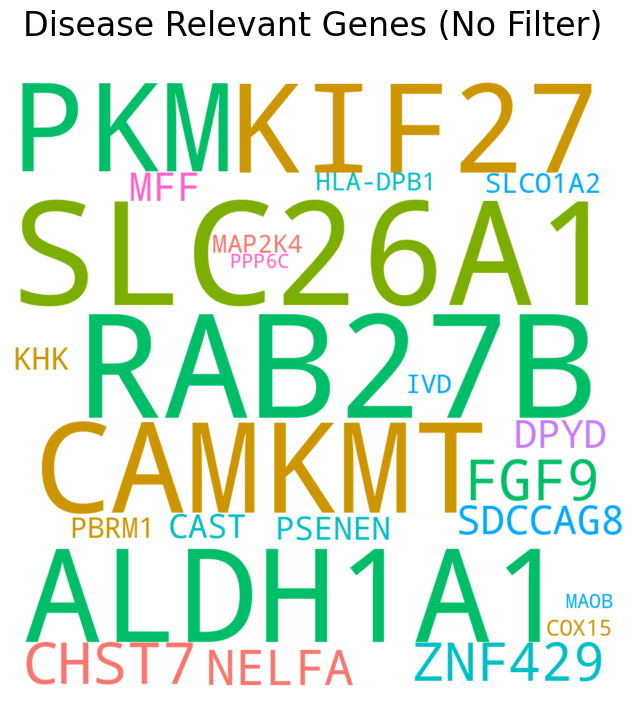

In [83]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_disease, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes (No Filter) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_disease_no_filter.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_disease_no_filter.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

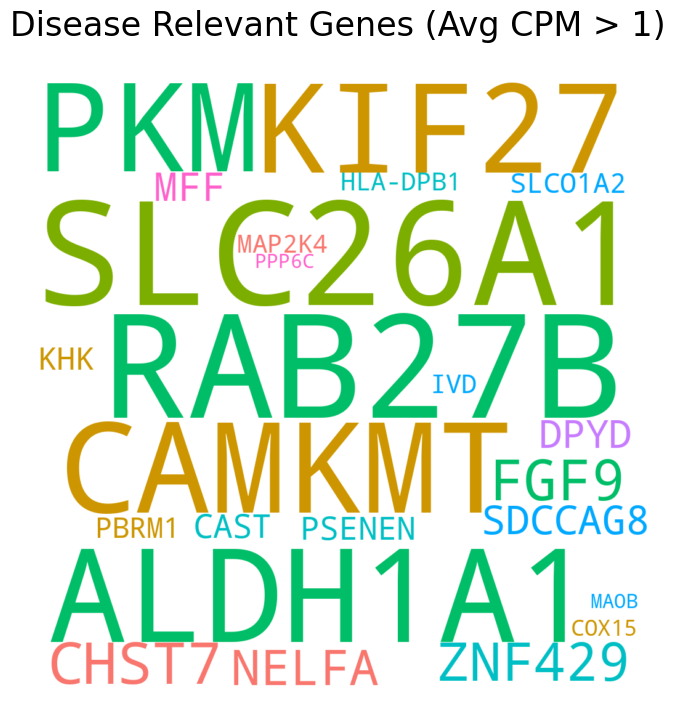

In [84]:
## Save disease relevant genes plot Avg CPM > 1
plt.imshow(word_cloud_disease_avg, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes (Avg CPM > 1) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_disease_avg.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_disease_avg.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

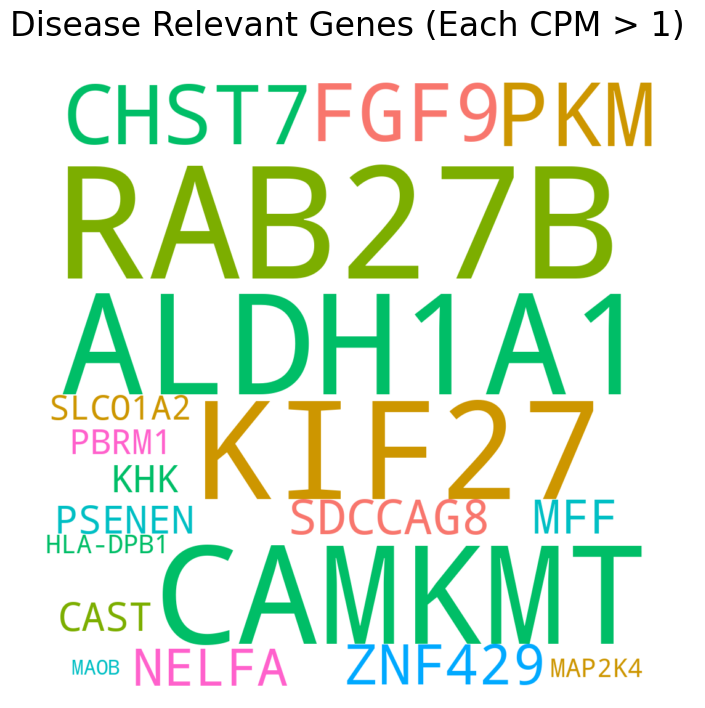

In [85]:
## Save disease relevant genes plot Each CPM > 1
plt.imshow(word_cloud_disease_each, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes (Each CPM > 1) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_disease_each.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_disease_each.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

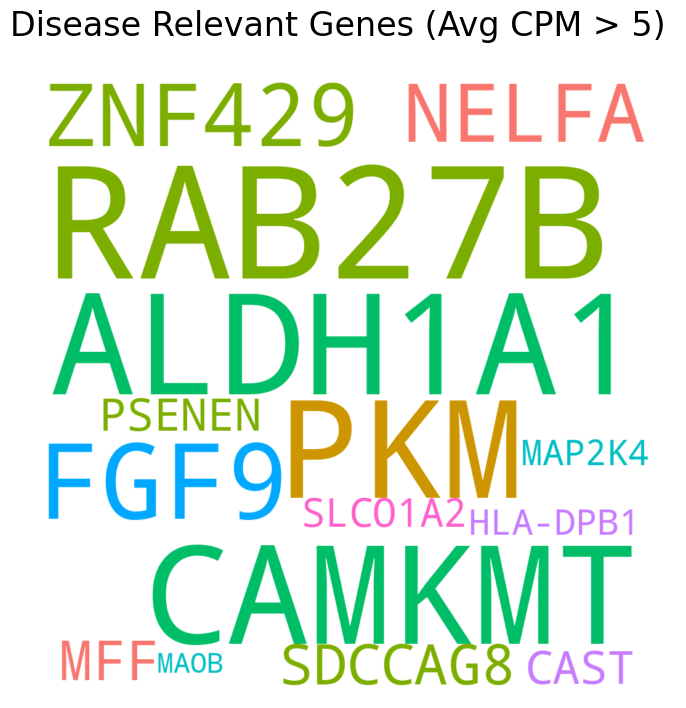

In [86]:
## Save disease relevant genes plot Avg CPM > 1
plt.imshow(word_cloud_disease_avg_5, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes (Avg CPM > 5) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_disease_avg_5.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_disease_avg_5.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

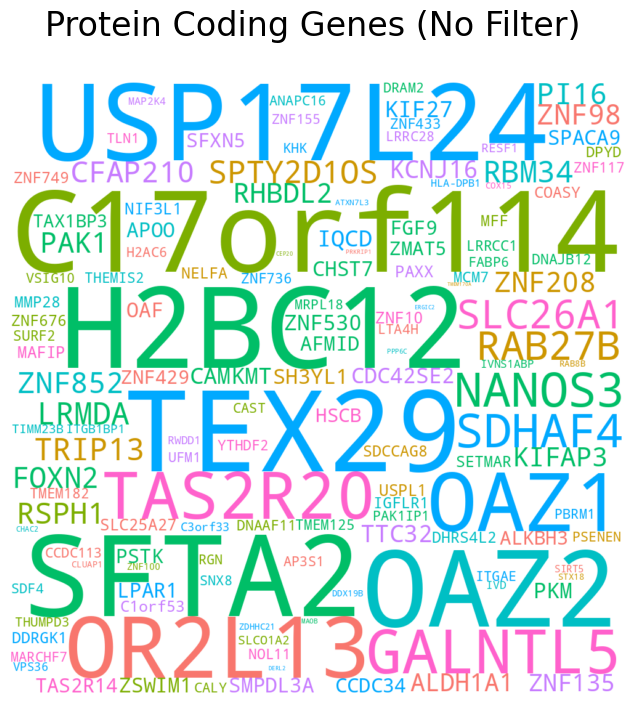

In [87]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_protein, interpolation='bilinear')
plt.title("Protein Coding Genes (No Filter) \n", fontsize=24, alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_protein_no_filter.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_protein_no_filter.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

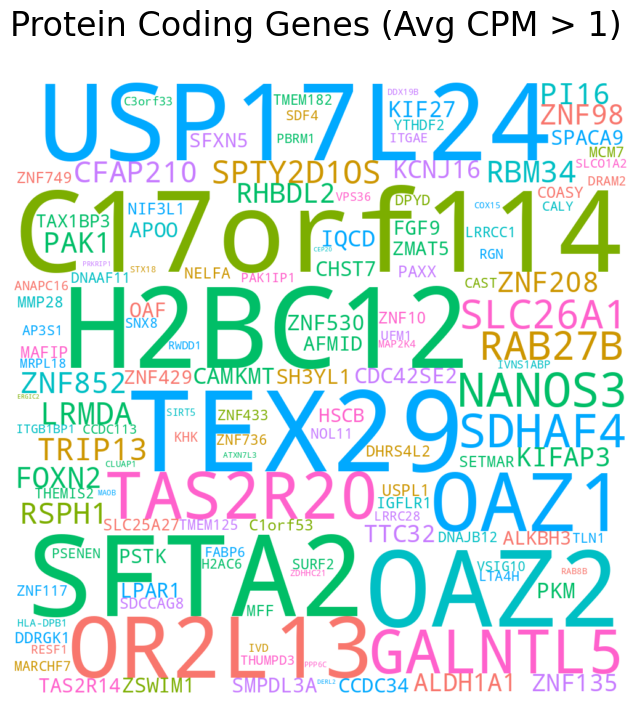

In [88]:
## Save disease relevant genes plot Avg CPM > 1
plt.imshow(word_cloud_protein_avg, interpolation='bilinear', alpha=1)
plt.title("Protein Coding Genes (Avg CPM > 1) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_protein_avg.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_protein_avg.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

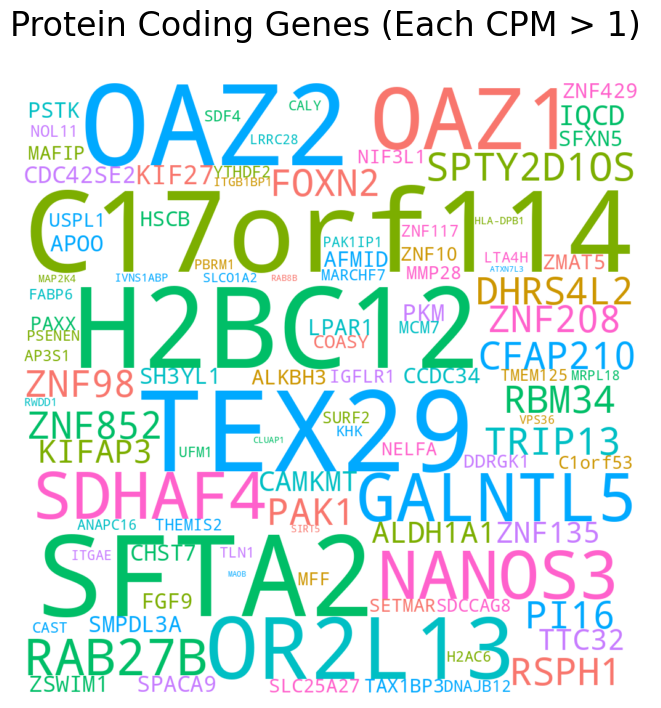

In [89]:
## Save disease relevant genes plot Each CPM > 1
plt.imshow(word_cloud_protein_each, interpolation='bilinear', alpha=1)
plt.title("Protein Coding Genes (Each CPM > 1) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_protein_each.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_protein_each.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

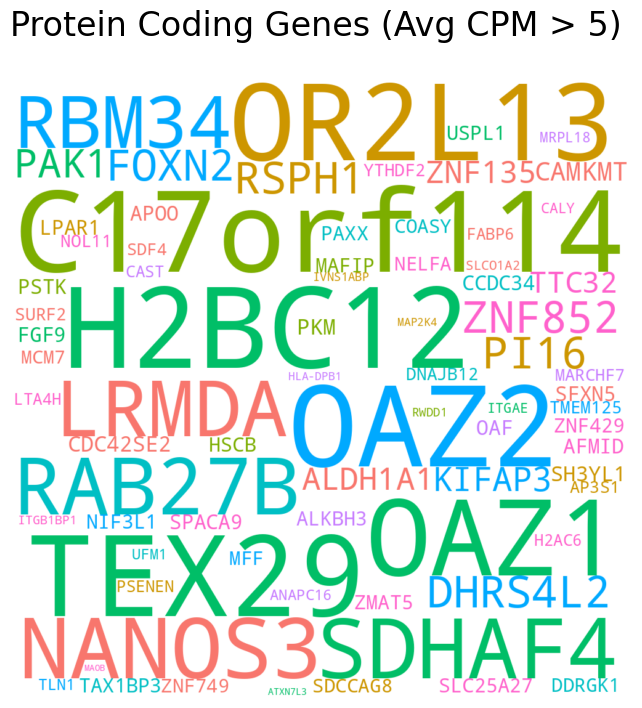

In [90]:
## Save disease relevant genes plot Avg CPM > 1
plt.imshow(word_cloud_protein_avg_5, interpolation='bilinear', alpha=1)
plt.title("Protein Coding Genes (Avg CPM > 5) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_protein_avg_5.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/05/word_cloud_protein_avg_5.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [91]:
## Export lists of protein coding genes with novel transcripts and disease relevant genes with novel transcripts
## at avg CPM > 1 and each CPM > 1

novel_relevant_avg_words_df.to_csv("../../../data/bernardo/processed/99.other/create_annotations/annotations_and_quant_for_mark_and_maddy/new_transcripts_on_relevant_genes/medically_relevant_AVG_cpm.tsv",
                                  sep="\t", index=False)

novel_relevant_each_words_df.to_csv("../../../data/bernardo/processed/99.other/create_annotations/annotations_and_quant_for_mark_and_maddy/new_transcripts_on_relevant_genes/medically_relevant_EACH_cpm.tsv",
                                  sep="\t", index=False)


protein_relevant_avg_words_df.to_csv("../../../data/bernardo/processed/99.other/create_annotations/annotations_and_quant_for_mark_and_maddy/new_transcripts_on_relevant_genes/protein_coding_AVG_cpm.tsv",
                                  sep="\t", index=False)

protein_relevant_each_words_df.to_csv("../../../data/bernardo/processed/99.other/create_annotations/annotations_and_quant_for_mark_and_maddy/new_transcripts_on_relevant_genes/protein_coding_EACH_cpm.tsv",
                                  sep="\t", index=False)

# 6) General quantification of all transcripts

In [92]:
## Filter out ERCCs
df_general = df.loc[~df["gene_id"].str.startswith("ERCC")].copy()

In [93]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []
list_num_transcripts_avg = []
list_num_transcripts_each = []
list_num_genes_avg = []
list_num_genes_each = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    transcript_avg_num = df_general.loc[df_general["total_CPM"] >= cpm_thresh].shape[0]
    transcript_each_num = df_general[(df_general[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    gene_avg_num = df_general.loc[df_general["total_CPM"] >= cpm_thresh]["gene_id"].nunique()
    gene_each_num = df_general[(df_general[cpm_cols]>=cpm_thresh).sum(axis=1)>=5]["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_transcripts_avg.append(transcript_avg_num)
    list_num_transcripts_each.append(transcript_each_num)
    
    list_num_genes_avg.append(gene_avg_num)
    list_num_genes_each.append(gene_each_num)
    

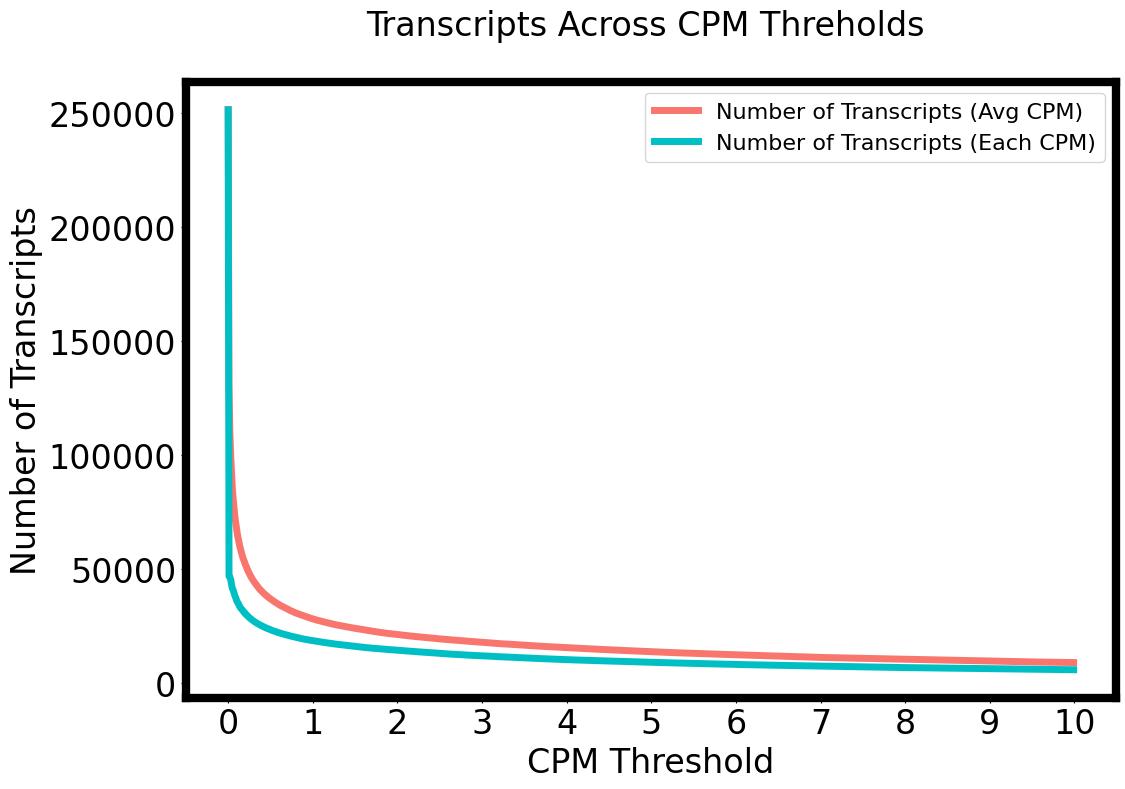

In [94]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_transcripts_avg, color=ggplot2_colors[0], label="Number of Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_each, color=ggplot2_colors[4], label="Number of Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts Across CPM Threholds \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

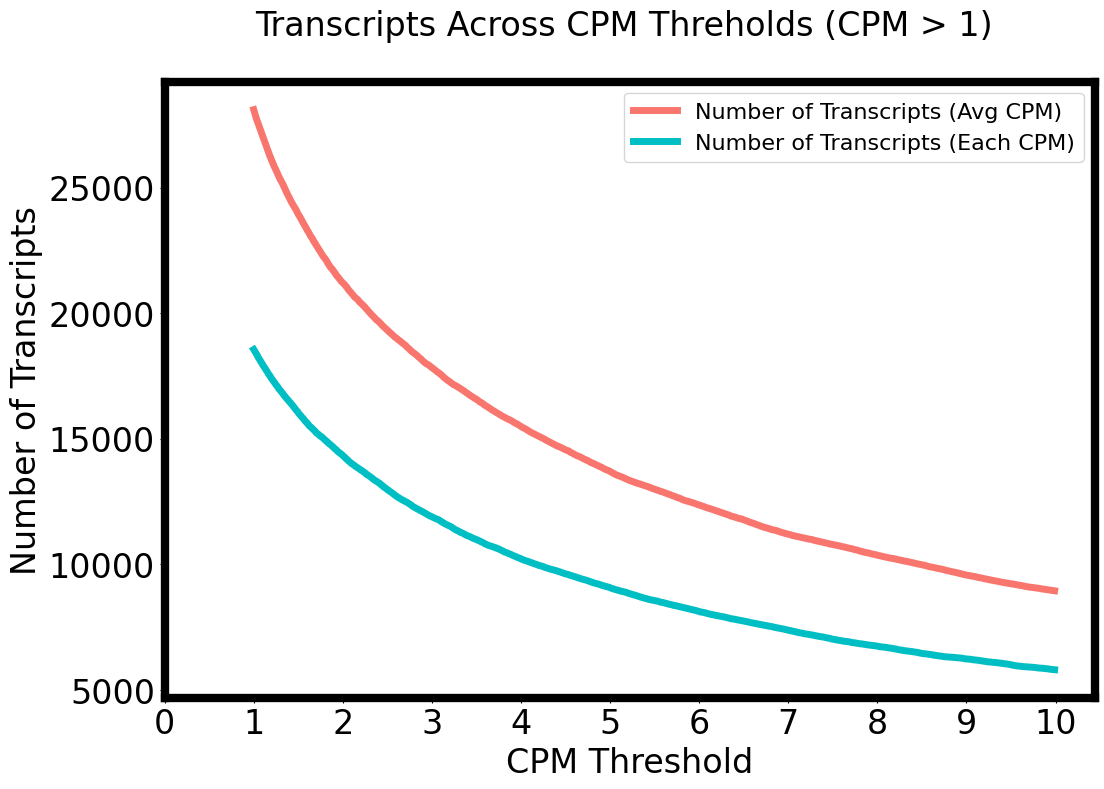

In [95]:
## Make plot showing number of transcripts across CPM thresholds starting at CPM > 0

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[100:], color=ggplot2_colors[0], label="Number of Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[100:], color=ggplot2_colors[4], label="Number of Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts Across CPM Threholds (CPM > 1) \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_CPM_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_CPM_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

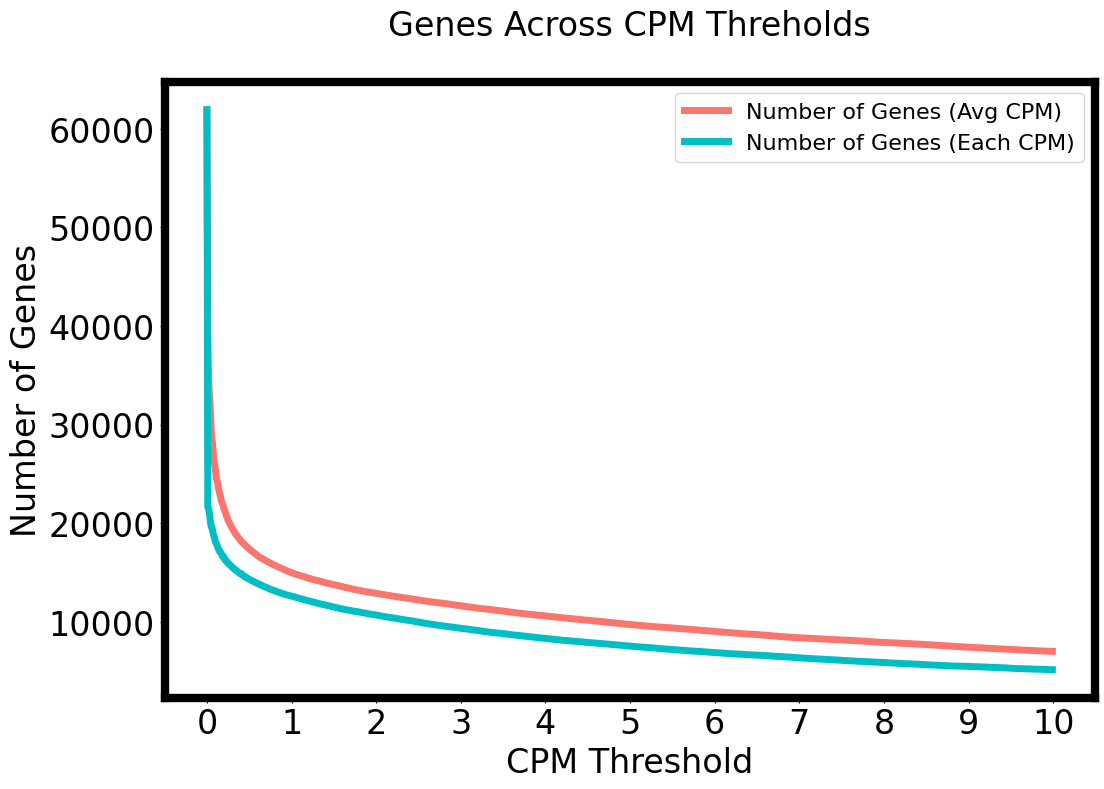

In [96]:
## Make plot showing number of genes across CPM thresholds (Both)

plt.plot(list_cpm_thresh, list_num_genes_avg, color=ggplot2_colors[0], label="Number of Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_genes_each, color=ggplot2_colors[4], label="Number of Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes Across CPM Threholds\n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_genes_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_genes_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()


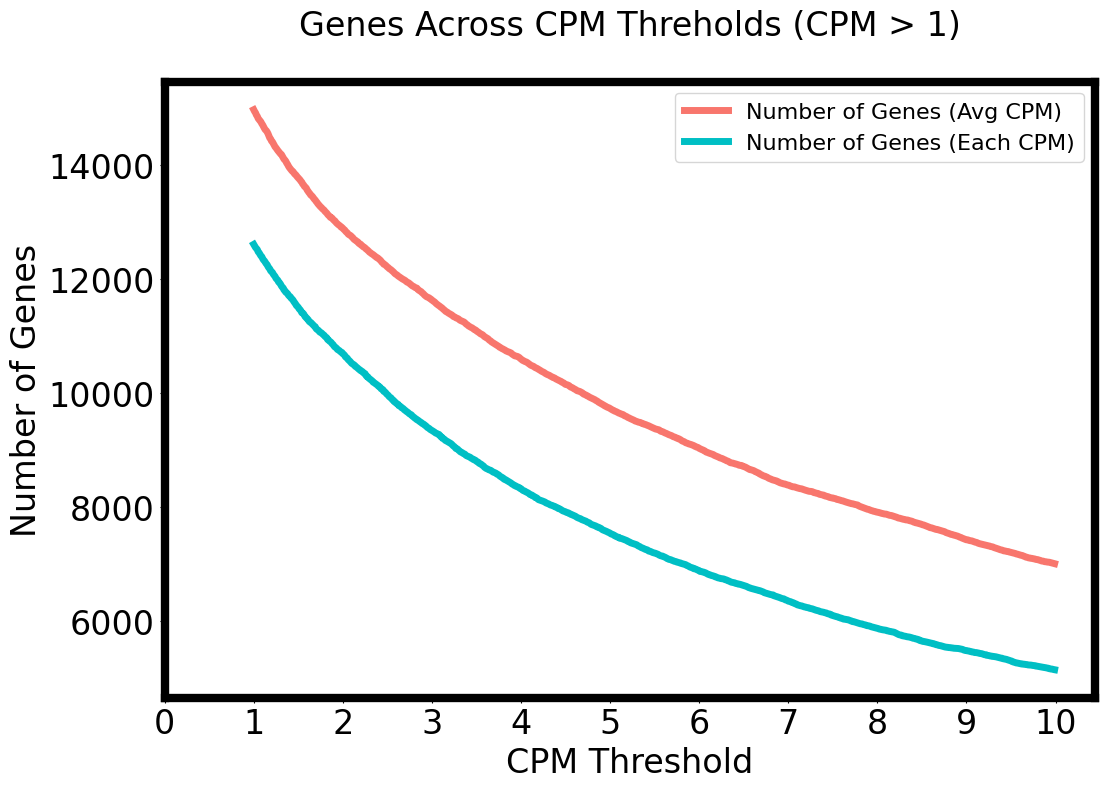

In [97]:
## Make plot showing number of genes across CPM thresholds only include CPM > 0

plt.plot(list_cpm_thresh[100:], list_num_genes_avg[100:], color=ggplot2_colors[0], label="Number of Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_genes_each[100:], color=ggplot2_colors[4], label="Number of Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes Across CPM Threholds (CPM > 1)\n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_genes_across_cpm_thresh_CPM_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_genes_across_cpm_thresh_CPM_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()


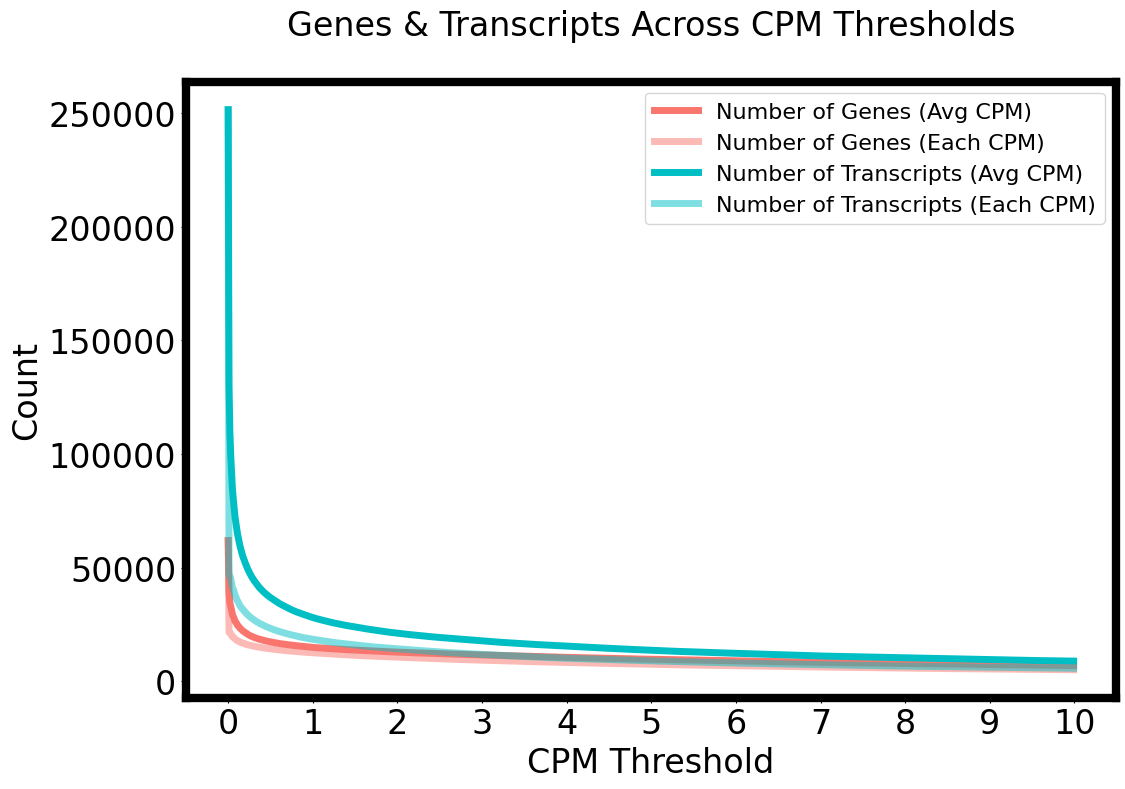

In [98]:
## Make plot showing number of genes and transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_genes_avg, color=ggplot2_colors[0], label="Number of Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_genes_each, color=ggplot2_colors[0], label="Number of Genes (Each CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh, list_num_transcripts_avg, color=ggplot2_colors[4], label="Number of Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_each, color=ggplot2_colors[4], label="Number of Transcripts (Each CPM)", linewidth=5, alpha=0.5)

plt.title("Genes & Transcripts Across CPM Thresholds\n", fontsize=24)
plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Count')
plt.legend(loc="upper right", fontsize=16)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_genes_and_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_genes_and_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

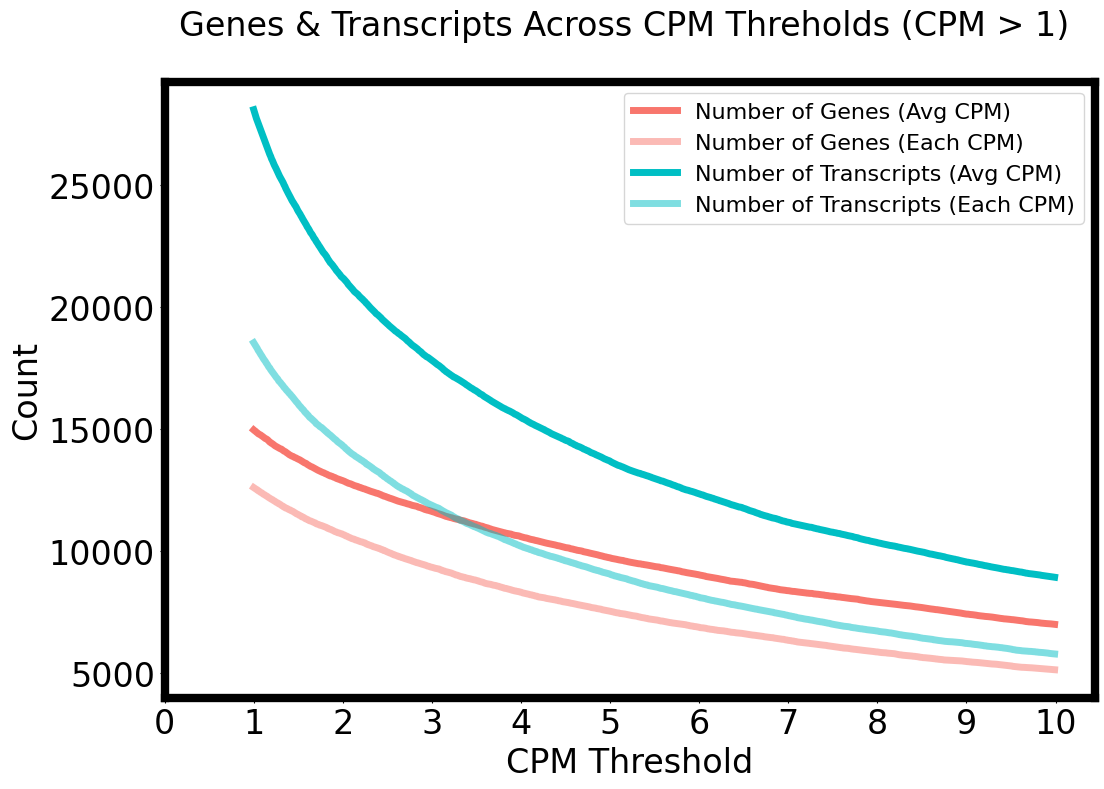

In [99]:
## Make plot showing number of genes and transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_num_genes_avg[100:], color=ggplot2_colors[0], label="Number of Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_genes_each[100:], color=ggplot2_colors[0], label="Number of Genes (Each CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[100:], color=ggplot2_colors[4], label="Number of Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[100:], color=ggplot2_colors[4], label="Number of Transcripts (Each CPM)", linewidth=5, alpha=0.5)

plt.title("Genes & Transcripts Across CPM Threholds (CPM > 1) \n", fontsize=24)
plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Count')
plt.legend(loc="upper right", fontsize=16)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_genes_and_transcripts_across_cpm_thresh_CPM_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_genes_and_transcripts_across_cpm_thresh_CPM_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [100]:
## Parse through original GTF 107 Ensembl reference to get transcript biotypes
orig_ref_types = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_types = parse_df_columns(orig_ref_types, is_ref=True, is_transcript=True)

In [101]:
## Get all transcript biotypes in expression matrix
df_general_and_type = df_general.merge(orig_ref_types[["transcript_id", "transcript_biotype"]], on="transcript_id", how="inner")
df_novel = df_general.loc[df_general["transcript_id"].str.startswith("BambuTx")].copy()
df_novel["transcript_biotype"] = "new_transcript"

df_general_and_type = pd.concat([df_general_and_type, df_novel])

In [102]:
## Create dataframes with transcript subtypes

df_protein_coding = df_general_and_type.loc[df_general_and_type["transcript_biotype"] == "protein_coding"].copy()
df_lncRNA = df_general_and_type.loc[df_general_and_type["transcript_biotype"] == "lncRNA"].copy()
df_new_transcript =  df_general_and_type.loc[df_general_and_type["transcript_biotype"] == "new_transcript"].copy()
df_other =  df_general_and_type.loc[~df_general_and_type["transcript_biotype"].isin(["protein_coding", "lncRNA", "new_transcript"])].copy()

In [103]:
## Create lists with number of genes across CPM thresholds
list_num_transcripts_avg = [[], [], [], []]
list_num_transcripts_each = [[], [], [], []]
list_dataframes = [df_protein_coding, df_lncRNA, df_new_transcript, df_other]

for i in range(0, 1000):
    for j in range(len(list_dataframes)):
        
        type_df = list_dataframes[j]
        
        cpm_thresh = i/100
        
        cpm_cols = type_df.columns[2:7]

        transcript_avg_num = type_df.loc[type_df["total_CPM"] >= cpm_thresh].shape[0]
        transcript_each_num = type_df[(type_df[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]



        list_num_transcripts_avg[j].append(transcript_avg_num)
        list_num_transcripts_each[j].append(transcript_each_num)

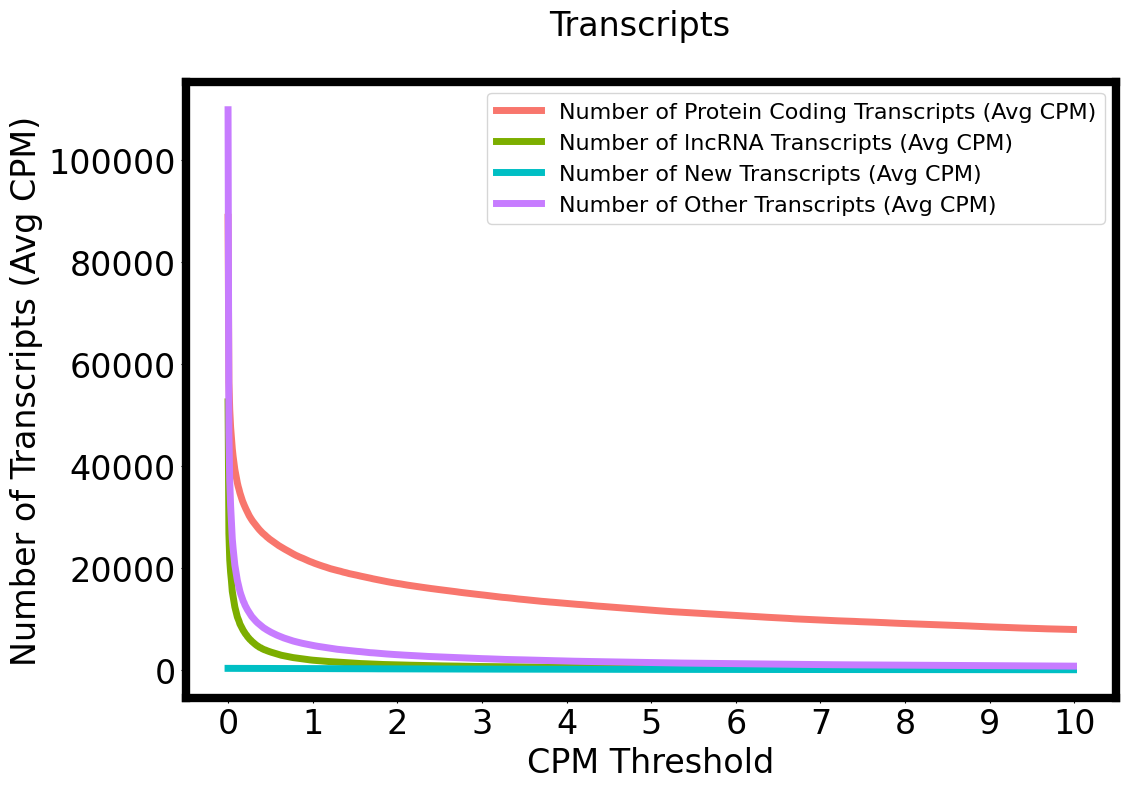

In [104]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_cpm_thresh, list_num_transcripts_avg[0], color=ggplot2_colors[0], label="Number of Protein Coding Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_avg[1], color=ggplot2_colors[2], label="Number of lncRNA Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_avg[2], color=ggplot2_colors[4], label="Number of New Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_avg[3], color=ggplot2_colors[6], label="Number of Other Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts (Avg CPM)')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts  \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_avg.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_avg.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

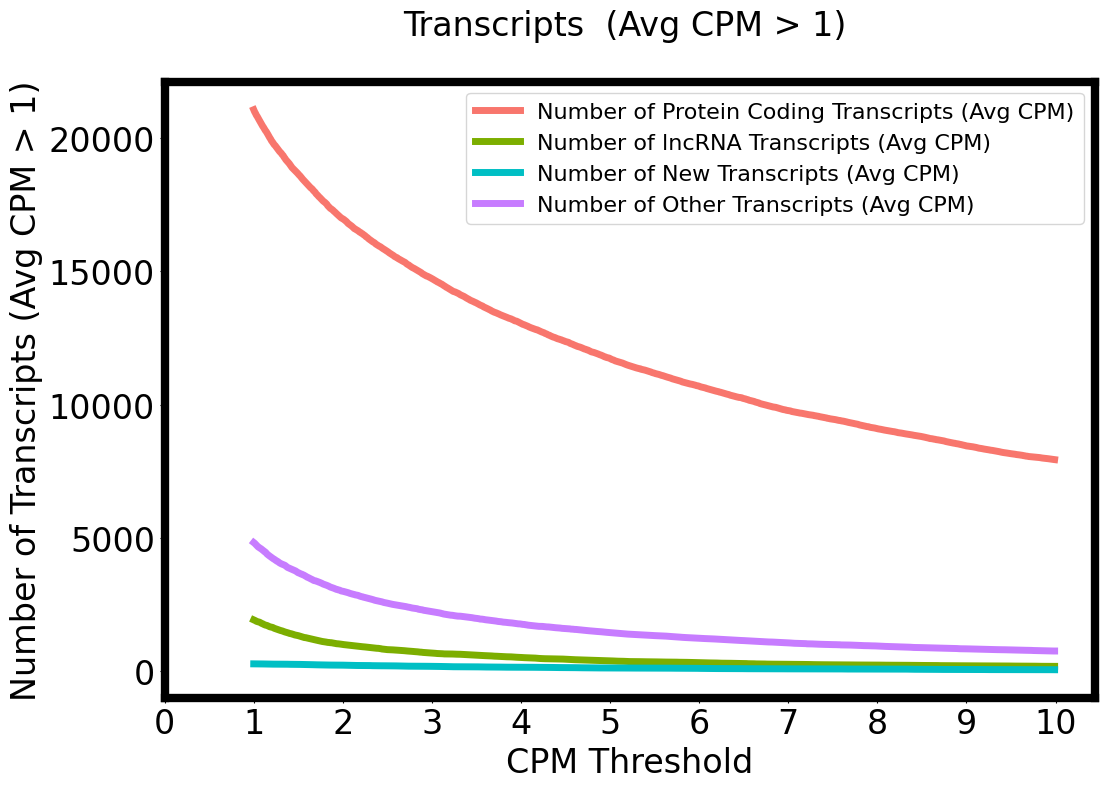

In [105]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[0][100:], color=ggplot2_colors[0], label="Number of Protein Coding Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[1][100:], color=ggplot2_colors[2], label="Number of lncRNA Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[2][100:], color=ggplot2_colors[4], label="Number of New Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[3][100:], color=ggplot2_colors[6], label="Number of Other Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts (Avg CPM > 1)')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts  (Avg CPM > 1) \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_avg_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_avg_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

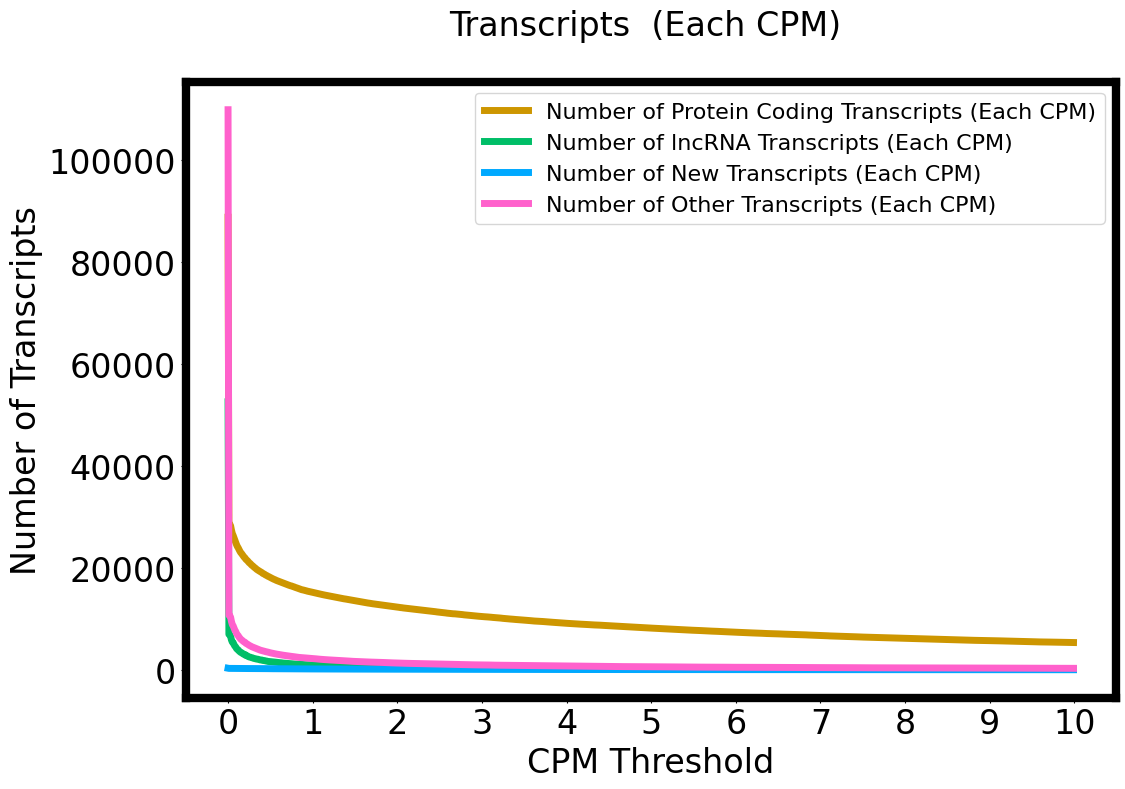

In [106]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_cpm_thresh, list_num_transcripts_each[0], color=ggplot2_colors[1], label="Number of Protein Coding Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_each[1], color=ggplot2_colors[3], label="Number of lncRNA Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_each[2], color=ggplot2_colors[5], label="Number of New Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_each[3], color=ggplot2_colors[7], label="Number of Other Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts  (Each CPM) \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_each.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_each.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

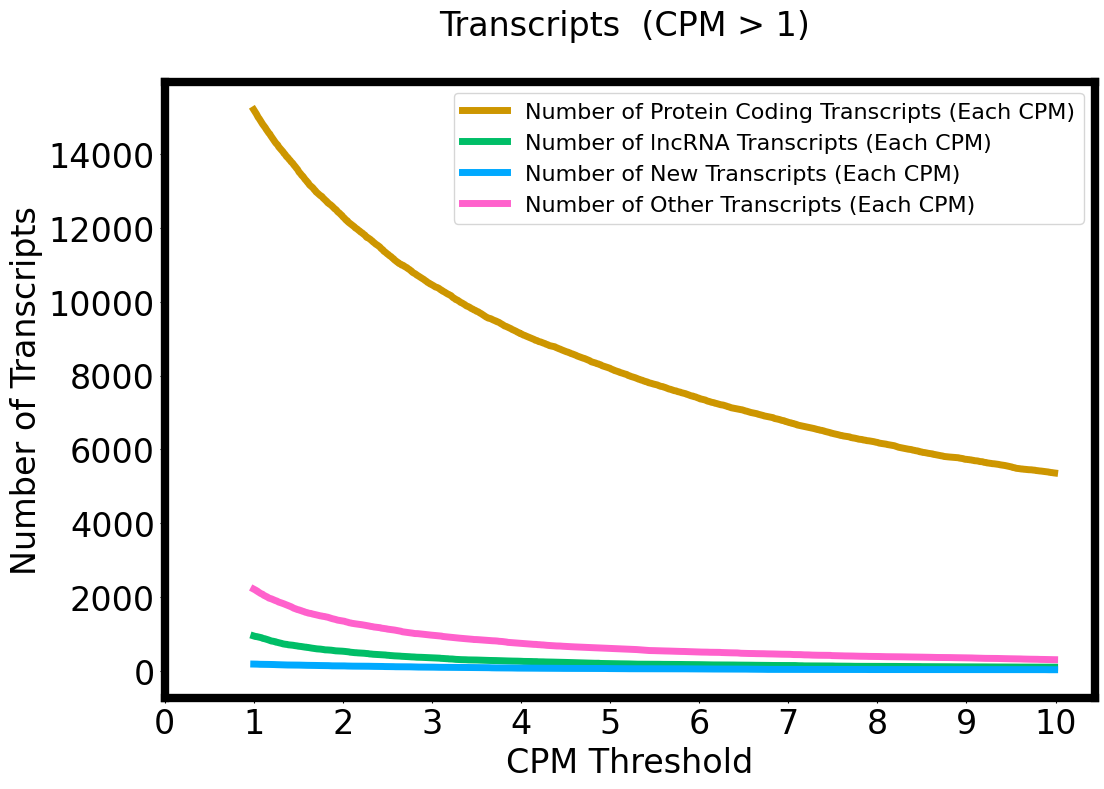

In [107]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[0][100:], color=ggplot2_colors[1], label="Number of Protein Coding Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[1][100:], color=ggplot2_colors[3], label="Number of lncRNA Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[2][100:], color=ggplot2_colors[5], label="Number of New Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[3][100:], color=ggplot2_colors[7], label="Number of Other Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts  (CPM > 1) \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_each_cpm_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_each_cpm_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

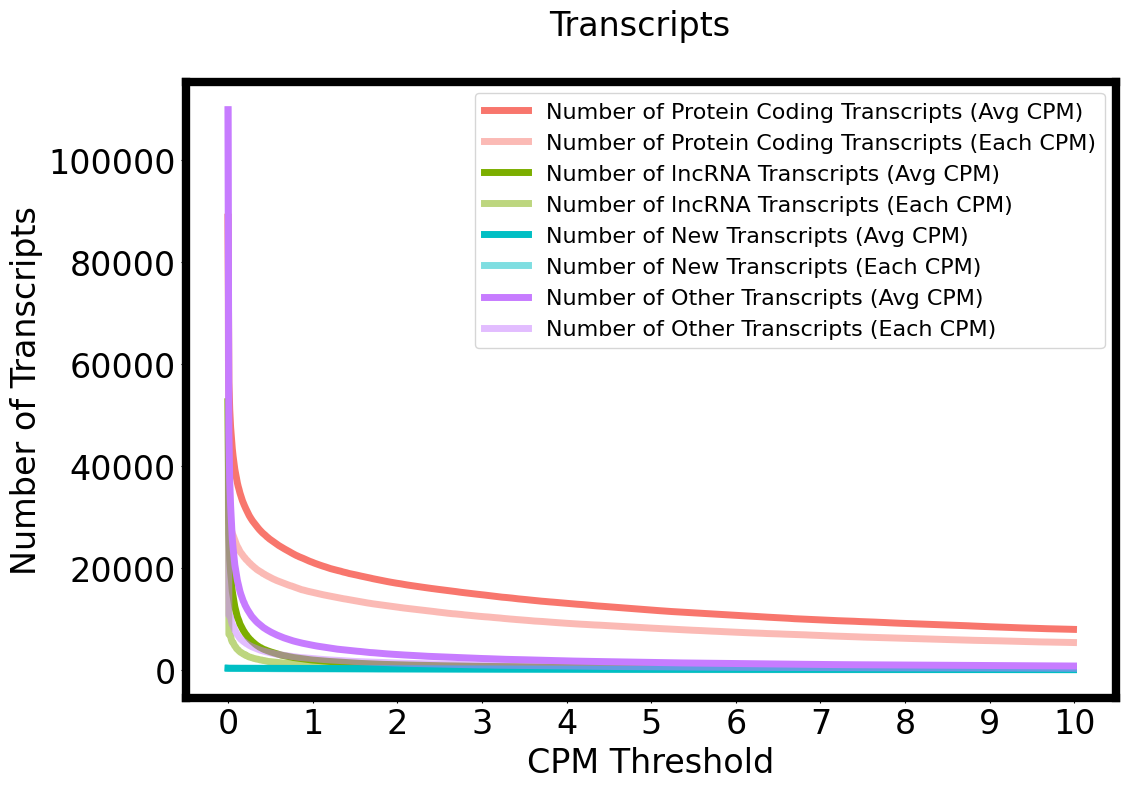

In [108]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_cpm_thresh, list_num_transcripts_avg[0], color=ggplot2_colors[0], label="Number of Protein Coding Transcripts (Avg CPM)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh, list_num_transcripts_each[0], color=ggplot2_colors[0], label="Number of Protein Coding Transcripts (Each CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh, list_num_transcripts_avg[1], color=ggplot2_colors[2], label="Number of lncRNA Transcripts (Avg CPM)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh, list_num_transcripts_each[1], color=ggplot2_colors[2], label="Number of lncRNA Transcripts (Each CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh, list_num_transcripts_avg[2], color=ggplot2_colors[4], label="Number of New Transcripts (Avg CPM)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh, list_num_transcripts_each[2], color=ggplot2_colors[4], label="Number of New Transcripts (Each CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh, list_num_transcripts_avg[3], color=ggplot2_colors[6], label="Number of Other Transcripts (Avg CPM)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh, list_num_transcripts_each[3], color=ggplot2_colors[6], label="Number of Other Transcripts (Each CPM)", linewidth=5, alpha=0.5)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts  \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

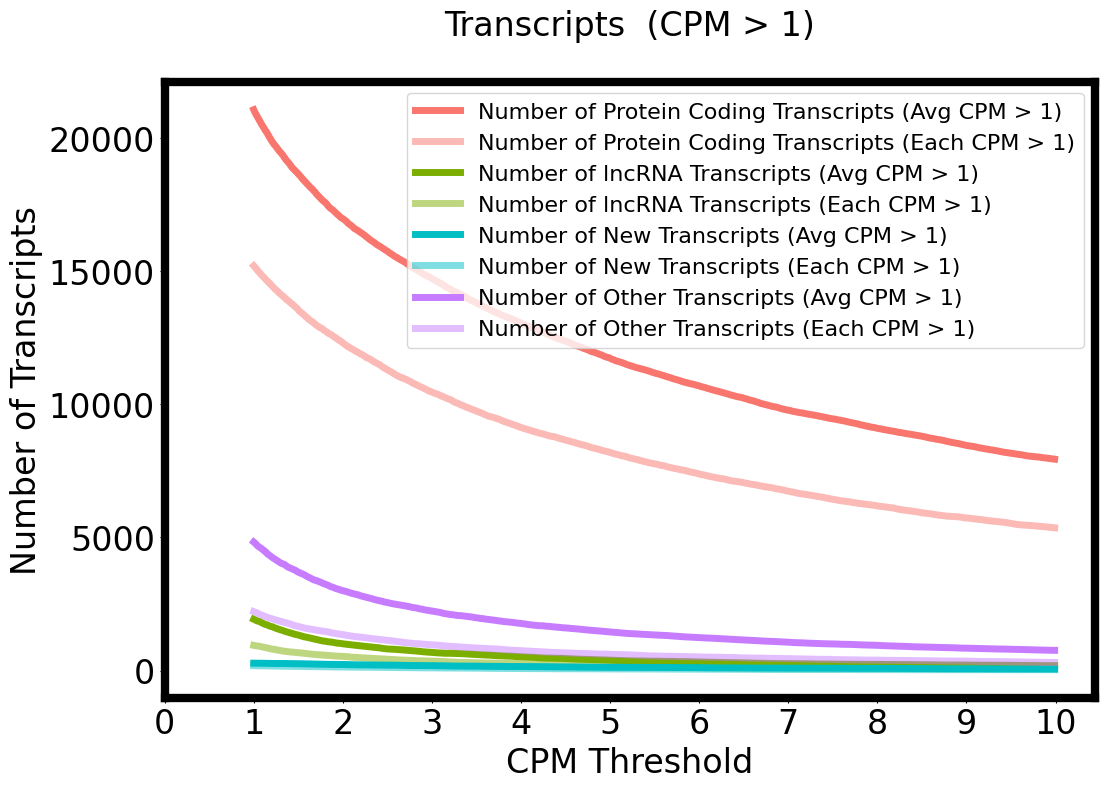

In [109]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[0][100:], color=ggplot2_colors[0], label="Number of Protein Coding Transcripts (Avg CPM > 1)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[0][100:], color=ggplot2_colors[0], label="Number of Protein Coding Transcripts (Each CPM > 1)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[1][100:], color=ggplot2_colors[2], label="Number of lncRNA Transcripts (Avg CPM > 1)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[1][100:], color=ggplot2_colors[2], label="Number of lncRNA Transcripts (Each CPM > 1)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[2][100:], color=ggplot2_colors[4], label="Number of New Transcripts (Avg CPM > 1)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[2][100:], color=ggplot2_colors[4], label="Number of New Transcripts (Each CPM > 1)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_avg[3][100:], color=ggplot2_colors[6], label="Number of Other Transcripts (Avg CPM > 1)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh[100:], list_num_transcripts_each[3][100:], color=ggplot2_colors[6], label="Number of Other Transcripts (Each CPM > 1)", linewidth=5, alpha=0.5)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts  (CPM > 1)\n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_cpm_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/number_of_transcripts_across_cpm_thresh_subtypes_cpm_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [110]:
## Create list for stacked barplot for 3 different CPM Thresholds
list_stacked_barplot = [[], [], [], []]

for i in range(4):

    avg_cpm_1 = list_num_transcripts_avg[i][100]
    each_cpm_1 = list_num_transcripts_each[i][100]
    avg_cpm_5 = list_num_transcripts_avg[i][500]
    
    avg_cpm_1_diff = avg_cpm_1 - each_cpm_1
    each_cpm_1_diff = each_cpm_1 - avg_cpm_5
    
    list_stacked_barplot[i].append(avg_cpm_1_diff)
    list_stacked_barplot[i].append(each_cpm_1_diff)
    list_stacked_barplot[i].append(avg_cpm_5)
    
## Make it into a dataframe
df_stacked_barplot = pd.DataFrame({'Avg CPM > 5': [list_stacked_barplot[0][2], list_stacked_barplot[1][2], 
                                                   list_stacked_barplot[2][2], list_stacked_barplot[3][2]],
                                   
                                    'Each CPM > 1': [list_stacked_barplot[0][1], list_stacked_barplot[1][1], 
                                                   list_stacked_barplot[2][1], list_stacked_barplot[3][1]],
    
                                    'Avg CPM > 1': [list_stacked_barplot[0][0], list_stacked_barplot[1][0], 
                                                   list_stacked_barplot[2][0], list_stacked_barplot[3][0]]},
                                  
                                  index=['Protein Coding', 'lncRNA', 'New Transcripts', 'Other Transcripts'])

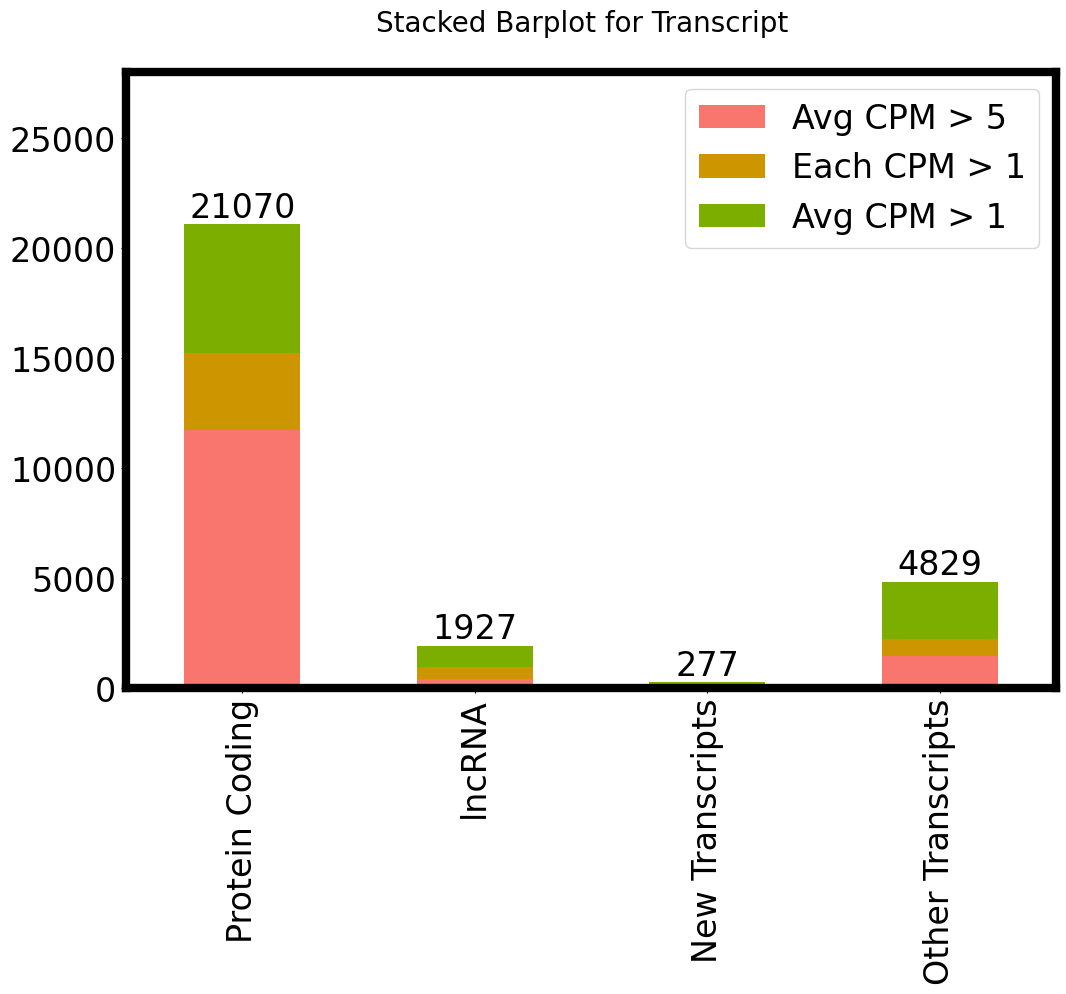

In [111]:
ax = df_stacked_barplot.plot(kind='bar' ,stacked=True, color=ggplot2_colors)

ax.bar_label(ax.containers[2])

plt.title("Stacked Barplot for Transcript  \n", fontsize=20)
ax.set(ylim=(0, 28000))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/stacked_barplot_transcript_type_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/stacked_barplot_transcript_type_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [112]:
## Transcript diversity quantification, rank percentille of expression
df_transcript_diversity = df_general.copy()

df_transcript_expressed = df_transcript_diversity.loc[df_transcript_diversity["total_CPM"] > 0].copy()
df_transcript_cpm_1 = df_transcript_diversity.loc[df_transcript_diversity["total_CPM"] > 1].copy()


df_transcript_diversity['percentile'] = df_transcript_diversity["total_CPM"].rank(pct=True)
df_transcript_expressed['percentile'] = df_transcript_expressed["total_CPM"].rank(pct=True)
df_transcript_cpm_1['percentile'] = df_transcript_cpm_1["total_CPM"].rank(pct=True)

In [113]:
## Get CPM total
sum_CPM_total = df_transcript_diversity.loc[df_transcript_diversity["percentile"] <= 1]["total_CPM"].sum()
sum_CPM_total_expressed = df_transcript_expressed.loc[df_transcript_expressed["percentile"] <= 1]["total_CPM"].sum()
sum_CPM_total_cpm_1 = df_transcript_cpm_1.loc[df_transcript_cpm_1["percentile"] <= 1]["total_CPM"].sum()

In [114]:
## Get how much the top X percenile of transcripts takes up the total transcript expression
list_transcript_diversity = []
list_transcript_expressed = []
list_transcript_cpm_1 = []

list_percentile = []

for i in range (0, 1001):
    
    percentile = i/1000
    
    list_percentile.append((percentile*100))
    
    list_transcript_diversity.append(df_transcript_diversity.loc[
        df_transcript_diversity["percentile"] <= percentile]["total_CPM"].sum()/sum_CPM_total)
    
    list_transcript_expressed.append(df_transcript_expressed.loc[
        df_transcript_expressed["percentile"] <= percentile]["total_CPM"].sum()/sum_CPM_total)

    list_transcript_cpm_1.append(df_transcript_cpm_1.loc[
        df_transcript_cpm_1["percentile"] <= percentile]["total_CPM"].sum()/sum_CPM_total)


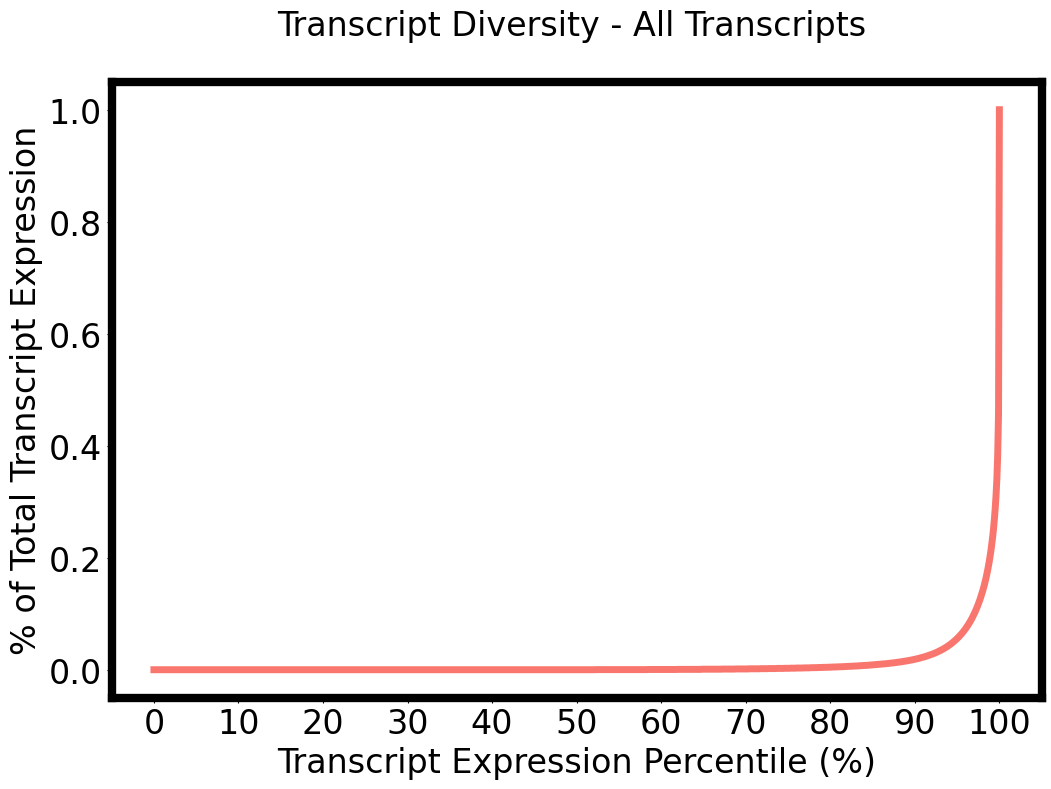

In [115]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_percentile, list_transcript_diversity, color=ggplot2_colors[0], linewidth=5, alpha=1)

plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Transcript Expression Percentile (%)')
plt.ylabel('% of Total Transcript Expression')
plt.title("Transcript Diversity - All Transcripts \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/transcript_diversity_plot_all.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/transcript_diversity_plot_all.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

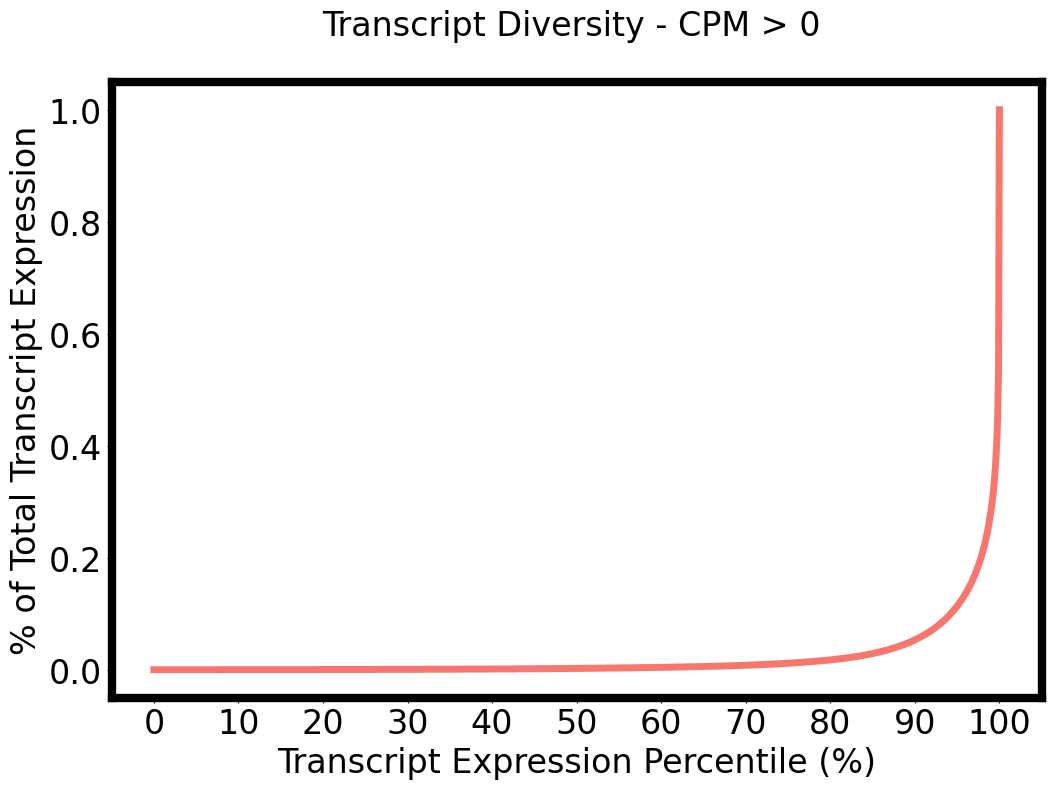

In [116]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_percentile, list_transcript_expressed, color=ggplot2_colors[0], linewidth=5, alpha=1)

plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Transcript Expression Percentile (%)')
plt.ylabel('% of Total Transcript Expression')
plt.title("Transcript Diversity - CPM > 0 \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/transcript_diversity_plot_all_cpm_above_0.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/transcript_diversity_plot_all_cpm_above_0.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

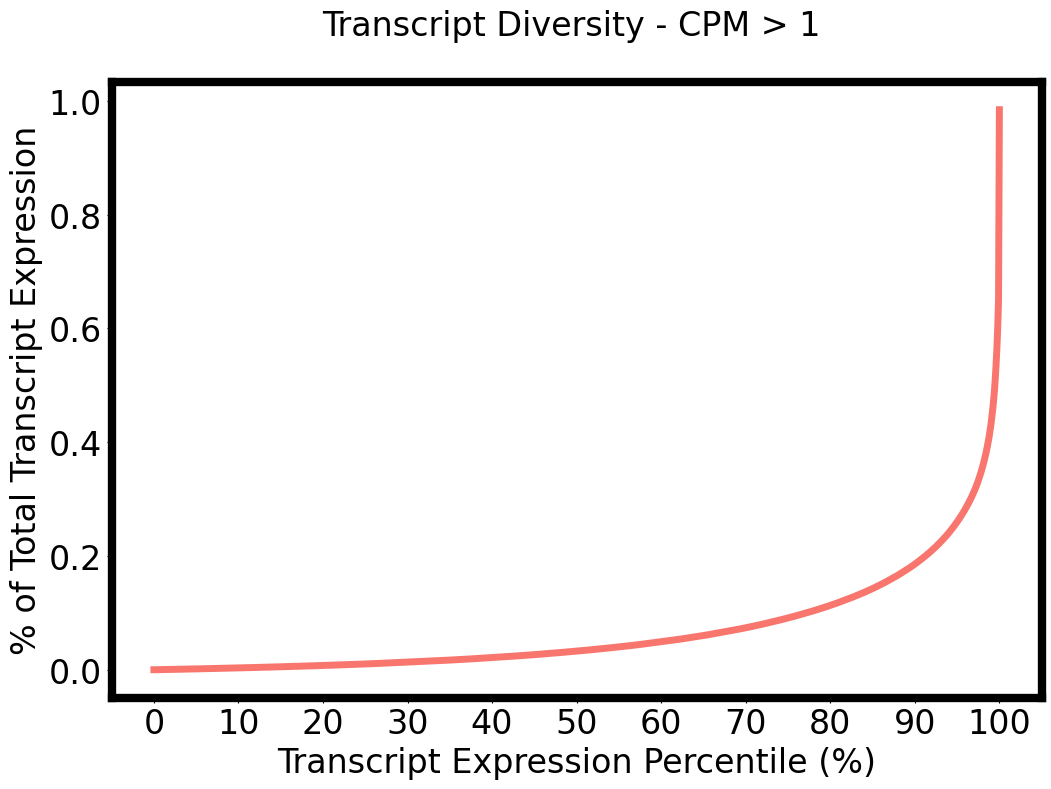

In [117]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_percentile, list_transcript_cpm_1, color=ggplot2_colors[0], linewidth=5, alpha=1)

plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Transcript Expression Percentile (%)')
plt.ylabel('% of Total Transcript Expression')
plt.title("Transcript Diversity - CPM > 1 \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/transcript_diversity_plot_all_cpm_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/06/transcript_diversity_plot_all_cpm_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 7) Quantification of Novel transcripts

In [118]:
## Create dataframe with only novel transcripts
df_novel = df_general.loc[df_general["transcript_id"].str.startswith("BambuTx")].copy()

In [119]:
## Create lists with number of novel genes and transcripts across CPM thresholds
list_cpm_thresh = []

list_num_new_transcripts_annotated_gene_avg = []
list_num_new_transcripts_annotated_gene_each = []

list_num_new_transcripts_new_gene_avg = []
list_num_new_transcripts_new_gene_each = []

list_num_new_transcript_avg = []
list_num_new_transcript_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    new_transcripts_annotated_gene_avg_num = df_novel_transcripts.loc[df_novel_transcripts["total_CPM"] >= cpm_thresh].shape[0]
    new_transcripts_annotated_gene_each_num = df_novel_transcripts[(df_novel_transcripts[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    new_transcripts_new_gene_avg_num = df_novel_genes.loc[df_novel_genes["total_CPM"] >= cpm_thresh].shape[0]
    new_transcripts_new_gene_each_num = df_novel_genes[(df_novel_genes[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    new_transcripts_avg = df_novel.loc[df_novel["total_CPM"] >= cpm_thresh].shape[0]
    new_transcripts_each = df_novel[(df_novel[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_new_transcripts_annotated_gene_avg.append(new_transcripts_annotated_gene_avg_num)
    list_num_new_transcripts_annotated_gene_each.append(new_transcripts_annotated_gene_each_num)
    
    list_num_new_transcripts_new_gene_avg.append(new_transcripts_new_gene_avg_num)
    list_num_new_transcripts_new_gene_each.append(new_transcripts_new_gene_each_num)
    
    list_num_new_transcript_avg.append(new_transcripts_avg)
    list_num_new_transcript_each.append(new_transcripts_each)

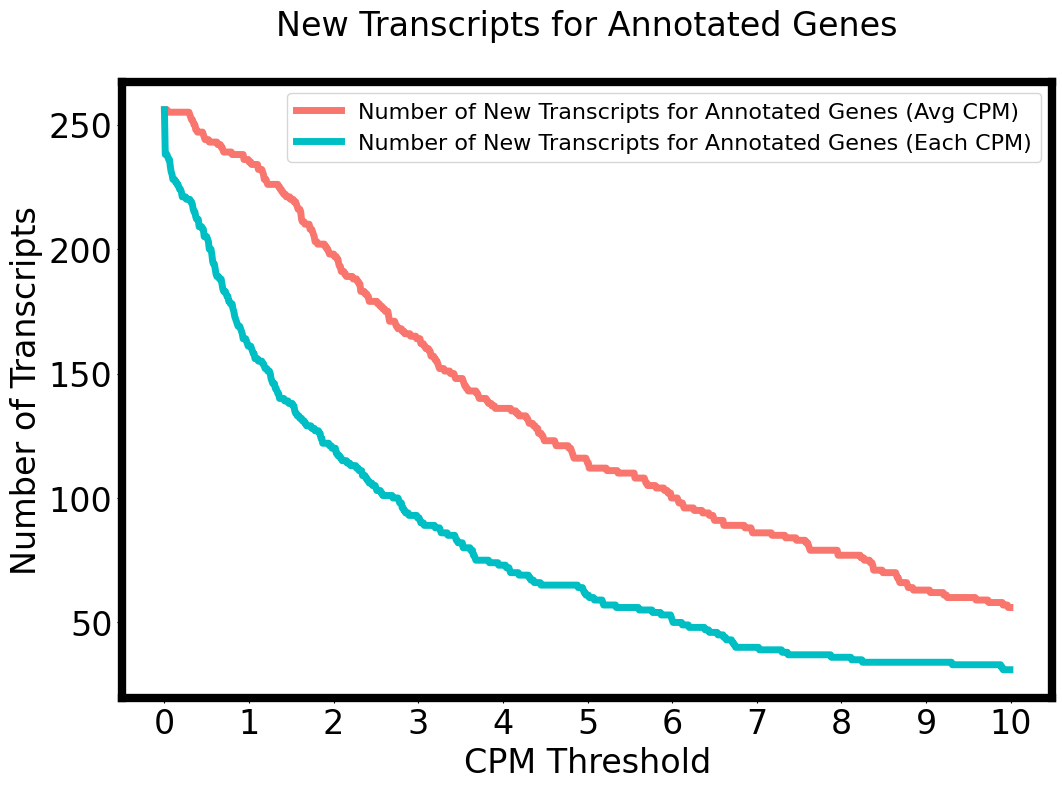

In [120]:
## Make plot showing number of new transcripts for annotated genes across CPM thresholds


plt.plot(list_cpm_thresh, list_num_new_transcripts_annotated_gene_avg, color=ggplot2_colors[0], label="Number of New Transcripts for Annotated Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_transcripts_annotated_gene_each, color=ggplot2_colors[4], label="Number of New Transcripts for Annotated Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Transcripts for Annotated Genes\n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/number_of_novel_transcripts_for_annotated_genes_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/number_of_novel_transcripts_for_annotated_genes_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

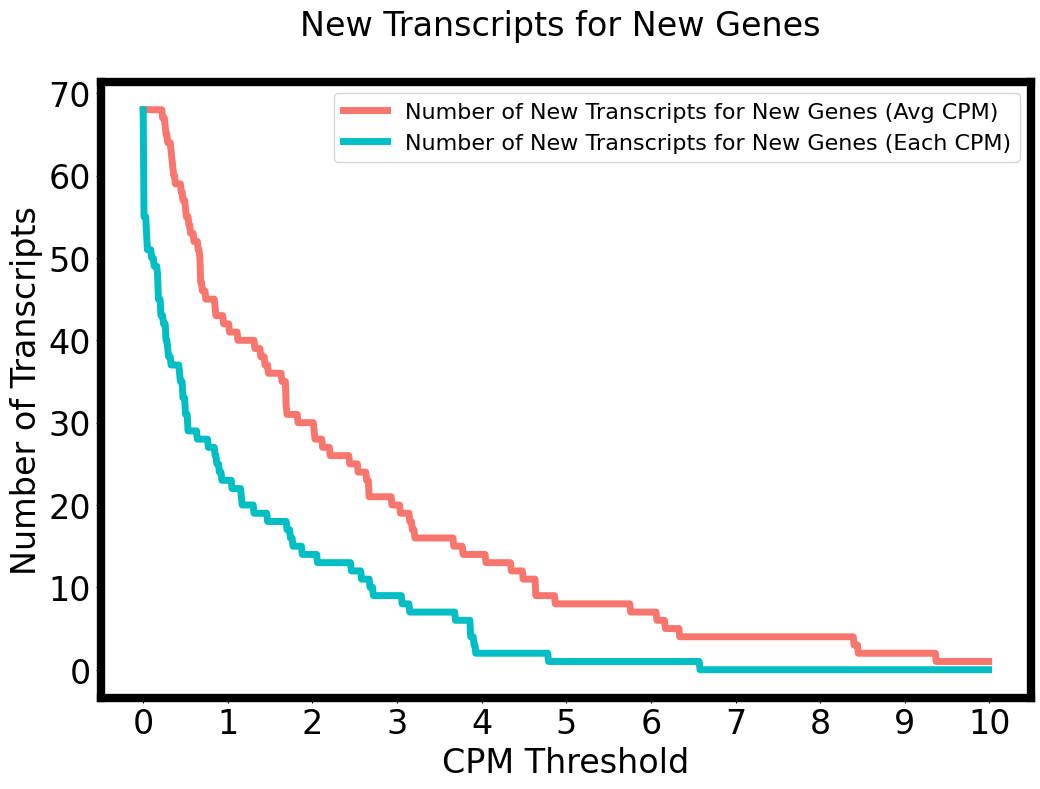

In [121]:
## Make plot showing number of new transcripts for new genes across CPM thresholds

plt.plot(list_cpm_thresh, list_num_new_transcripts_new_gene_avg, color=ggplot2_colors[0], label="Number of New Transcripts for New Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_transcripts_new_gene_each, color=ggplot2_colors[4], label="Number of New Transcripts for New Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Transcripts for New Genes \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/number_of_novel_transcripts_for_new_genes_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/number_of_novel_transcripts_for_new_genes_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

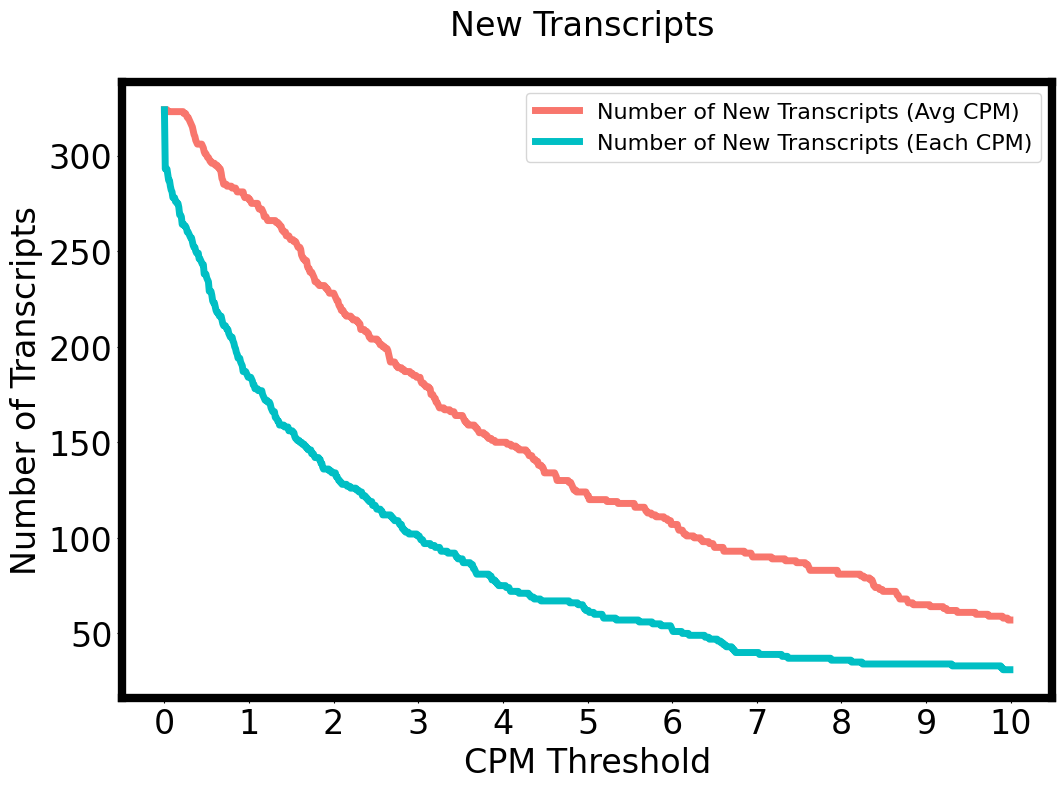

In [122]:
## Make plot showing number of new transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_new_transcript_avg, color=ggplot2_colors[0], label="Number of New Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_transcript_each, color=ggplot2_colors[4], label="Number of New Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/number_of_novel_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/number_of_novel_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

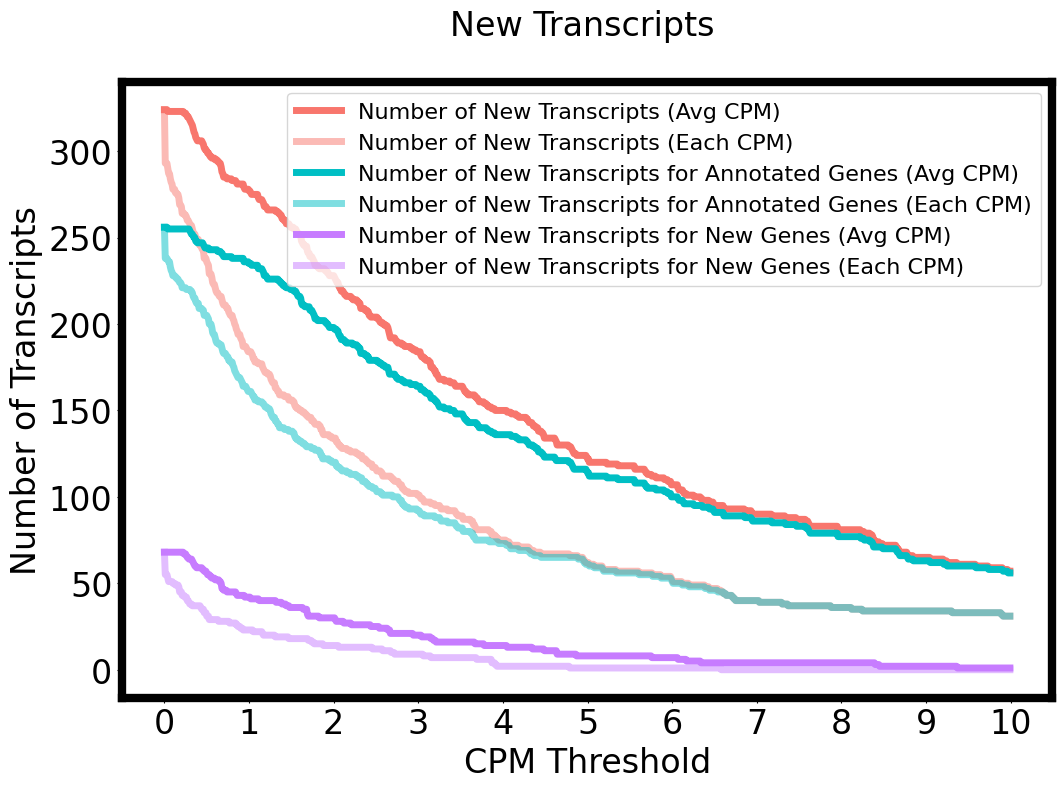

In [123]:
## Make plot showing everything for new transcripts for new genes across CPM thresholds

plt.plot(list_cpm_thresh, list_num_new_transcript_avg, color=ggplot2_colors[0], label="Number of New Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_transcript_each, color=ggplot2_colors[0], label="Number of New Transcripts (Each CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh, list_num_new_transcripts_annotated_gene_avg, color=ggplot2_colors[4], label="Number of New Transcripts for Annotated Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_transcripts_annotated_gene_each, color=ggplot2_colors[4], label="Number of New Transcripts for Annotated Genes (Each CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh, list_num_new_transcripts_new_gene_avg, color=ggplot2_colors[6], label="Number of New Transcripts for New Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_transcripts_new_gene_each, color=ggplot2_colors[6], label="Number of New Transcripts for New Genes (Each CPM)", linewidth=5, alpha=0.5)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/number_of_novel_transcripts_all_combined_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/number_of_novel_transcripts_all_combined_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [124]:
## Create list for stacked barplot for 3 different CPM Thresholds for new transcripts
list_stacked_barplot = [[], [], [], []]

list_num_new_transcripts_avg = [list_num_new_transcript_avg, list_num_new_transcripts_annotated_gene_avg, 
                                list_num_new_transcripts_new_gene_avg]

list_num_new_transcripts_each = [list_num_new_transcript_each, list_num_new_transcripts_annotated_gene_each, 
                                 list_num_new_transcripts_new_gene_each]

for i in range(3):

    avg_cpm_1 = list_num_new_transcripts_avg[i][100]
    each_cpm_1 = list_num_new_transcripts_each[i][100]
    avg_cpm_5 = list_num_new_transcripts_avg[i][500]
    
    avg_cpm_1_diff = avg_cpm_1 - each_cpm_1
    each_cpm_1_diff = each_cpm_1 - avg_cpm_5
    
    list_stacked_barplot[i].append(avg_cpm_1_diff)
    list_stacked_barplot[i].append(each_cpm_1_diff)
    list_stacked_barplot[i].append(avg_cpm_5)
    
## Make it into a dataframe
df_stacked_barplot = pd.DataFrame({'Avg CPM > 5': [list_stacked_barplot[0][2], list_stacked_barplot[1][2], 
                                                   list_stacked_barplot[2][2]],
                                   
                                    'Each CPM > 1': [list_stacked_barplot[0][1], list_stacked_barplot[1][1], 
                                                   list_stacked_barplot[2][1]],
    
                                    'Avg CPM > 1': [list_stacked_barplot[0][0], list_stacked_barplot[1][0], 
                                                   list_stacked_barplot[2][0]]},
                                  
                                  index=['New Tx - All', 'New Tx - Known Gene', 
                                         'New Tx - New Gene'])

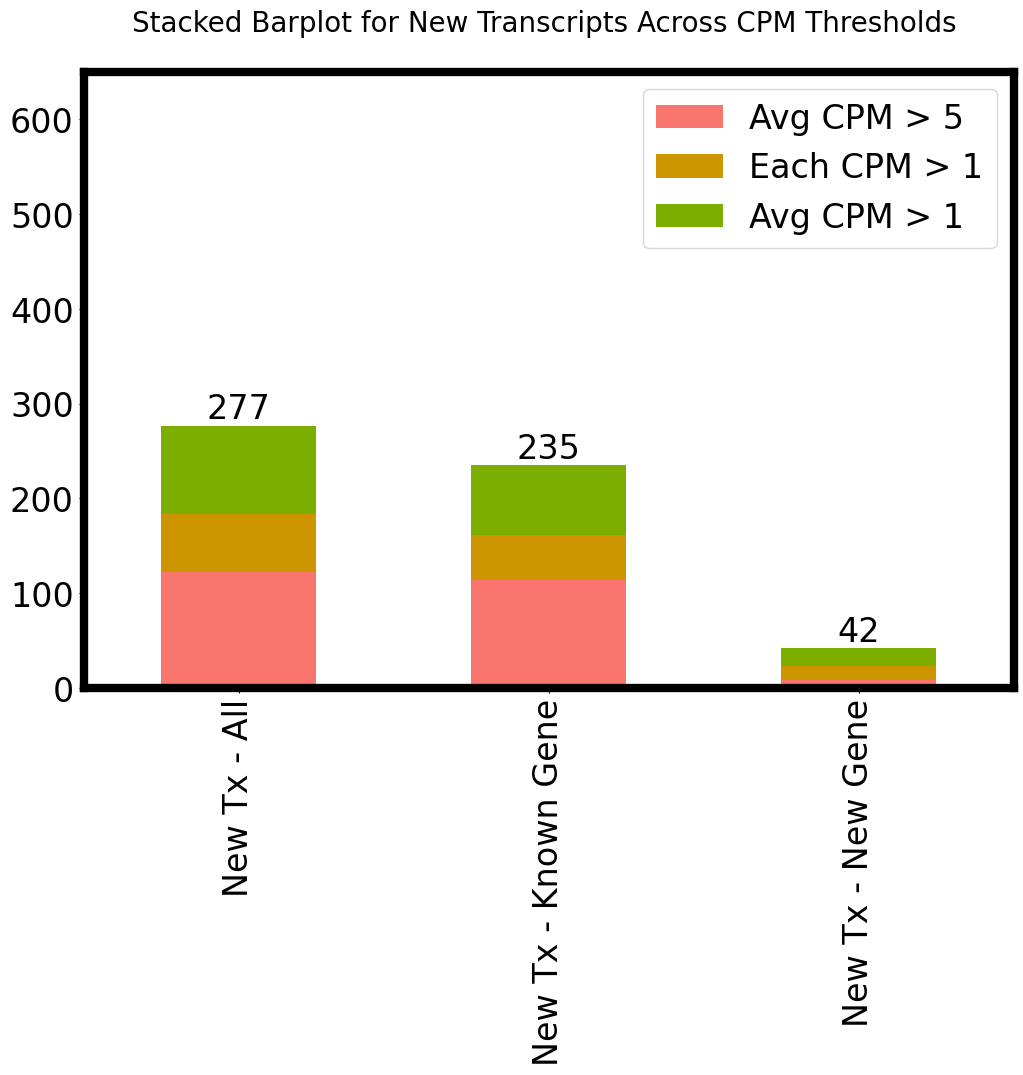

In [125]:
ax = df_stacked_barplot.plot(kind='bar' ,stacked=True, color=ggplot2_colors)

ax.bar_label(ax.containers[2])

plt.title("Stacked Barplot for New Transcripts Across CPM Thresholds \n", fontsize=20)
ax.set(ylim=(0, 650))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/stacked_barplot_new_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/07/stacked_barplot_new_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 8) Quantification of Protein Coding

## 8A) Protein Coding Genes

In [126]:
## Make transcript_protein_coding_ref
orig_ref_prot_gene = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref_prot_gene = parse_df_columns(orig_ref_prot_gene, is_ref=True, is_transcript=False)
orig_ref_prot_gene = orig_ref_prot_gene.loc[orig_ref_prot_gene["gene_biotype"] == "protein_coding"]

In [127]:
## Only keep protein coding transcript in count matrix
df_protein_gene = df_general.loc[df_general["gene_id"].isin(orig_ref_prot_gene["gene_id"])].copy()

In [128]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_prot_gene_transcripts_avg = []
list_prot_gene_transcripts_each = []

list_prot_gene_genes_avg = []
list_prot_gene_genes_each = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    prot_gene_transcripts_avg_num = df_protein_gene.loc[df_protein_gene["total_CPM"] >= cpm_thresh].shape[0]
    prot_gene_transcripts_each_num = df_protein_gene[(df_protein_gene[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    prot_gene_genes_avg_num = df_protein_gene.loc[df_protein_gene["total_CPM"] >= cpm_thresh]["gene_id"].nunique()
    prot_gene_genes_each_num = df_protein_gene[(df_protein_gene[cpm_cols]>=cpm_thresh).sum(axis=1)>=5]["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_gene_transcripts_avg.append(prot_gene_transcripts_avg_num)
    list_prot_gene_transcripts_each.append(prot_gene_transcripts_each_num)
    
    list_prot_gene_genes_avg.append(prot_gene_genes_avg_num)
    list_prot_gene_genes_each.append(prot_gene_genes_each_num)

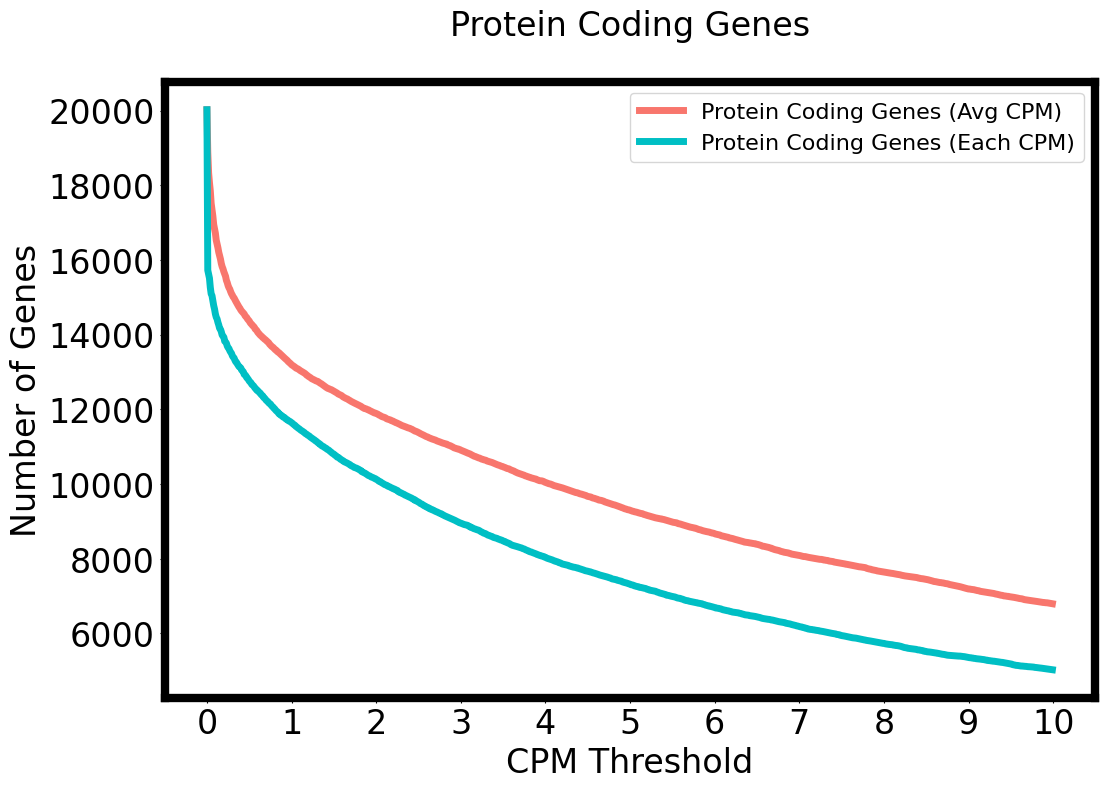

In [129]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_gene_genes_avg, color=ggplot2_colors[0], label="Protein Coding Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_prot_gene_genes_each, color=ggplot2_colors[4], label="Protein Coding Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Genes\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_genes_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_genes_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

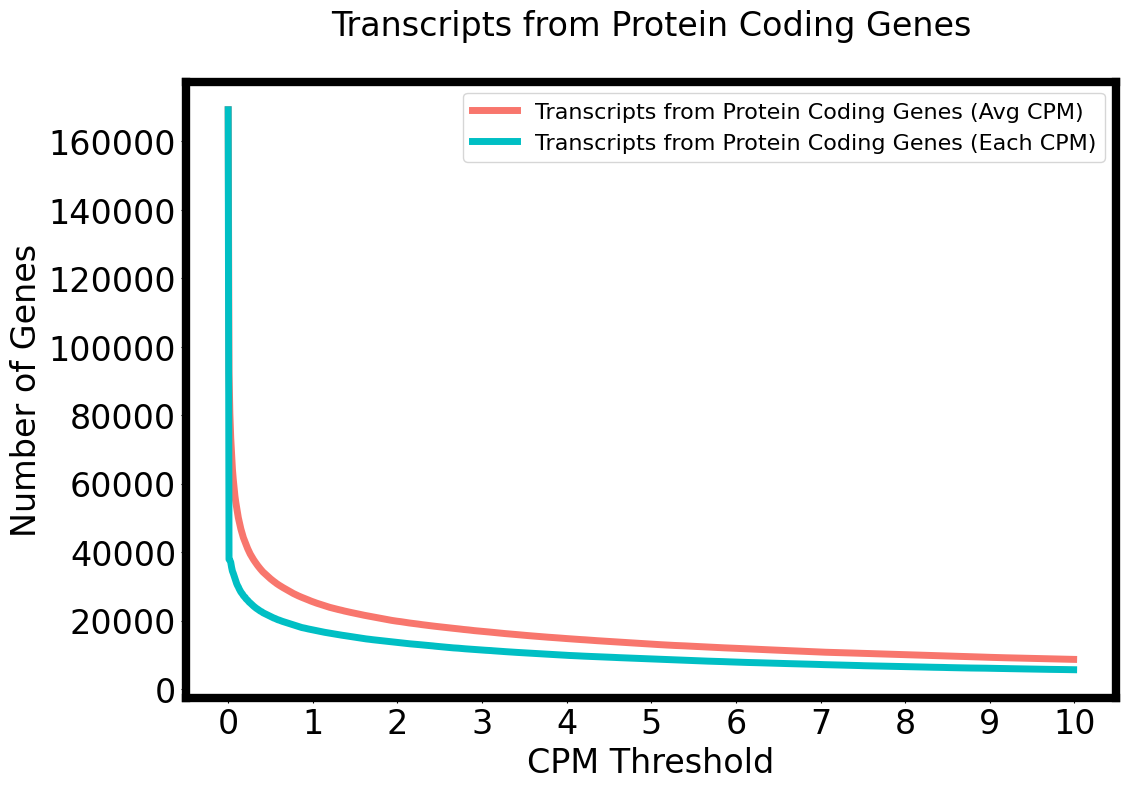

In [130]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_gene_transcripts_avg, color=ggplot2_colors[0], label="Transcripts from Protein Coding Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_prot_gene_transcripts_each, color=ggplot2_colors[4], label="Transcripts from Protein Coding Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts from Protein Coding Genes\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_gene_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_gene_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

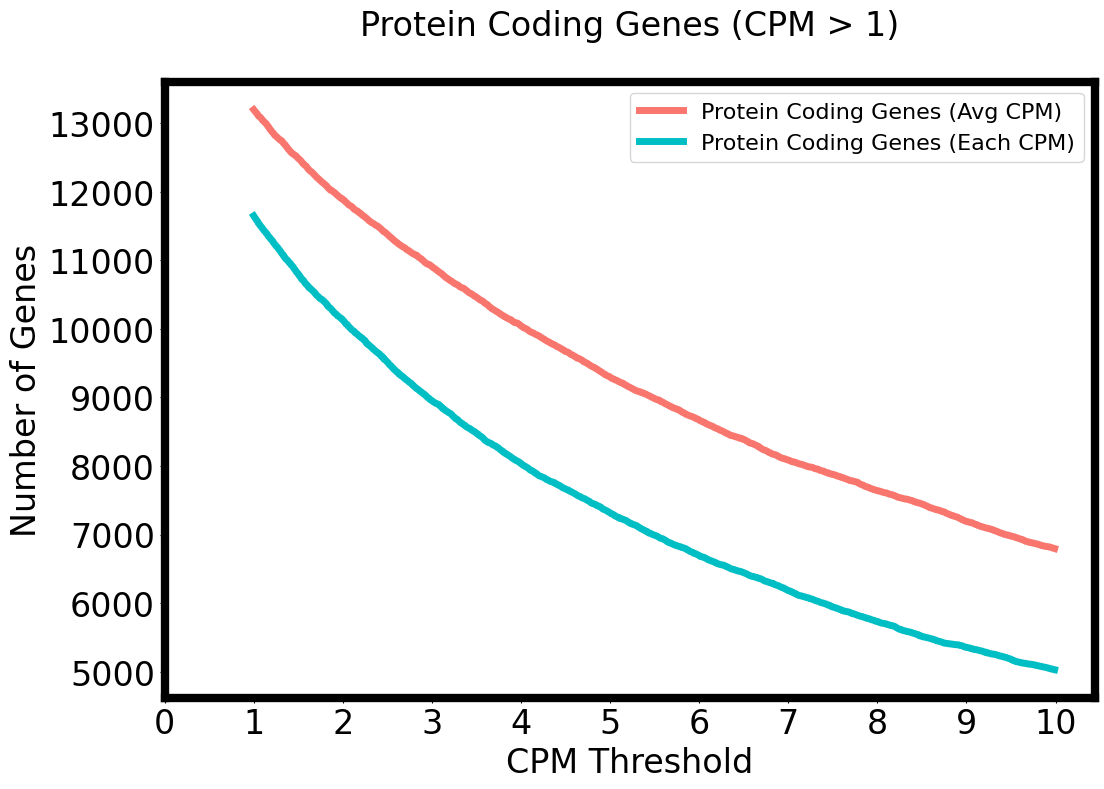

In [131]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_gene_genes_avg[100:], color=ggplot2_colors[0], label="Protein Coding Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_prot_gene_genes_each[100:], color=ggplot2_colors[4], label="Protein Coding Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Genes (CPM > 1)\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_genes_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_genes_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

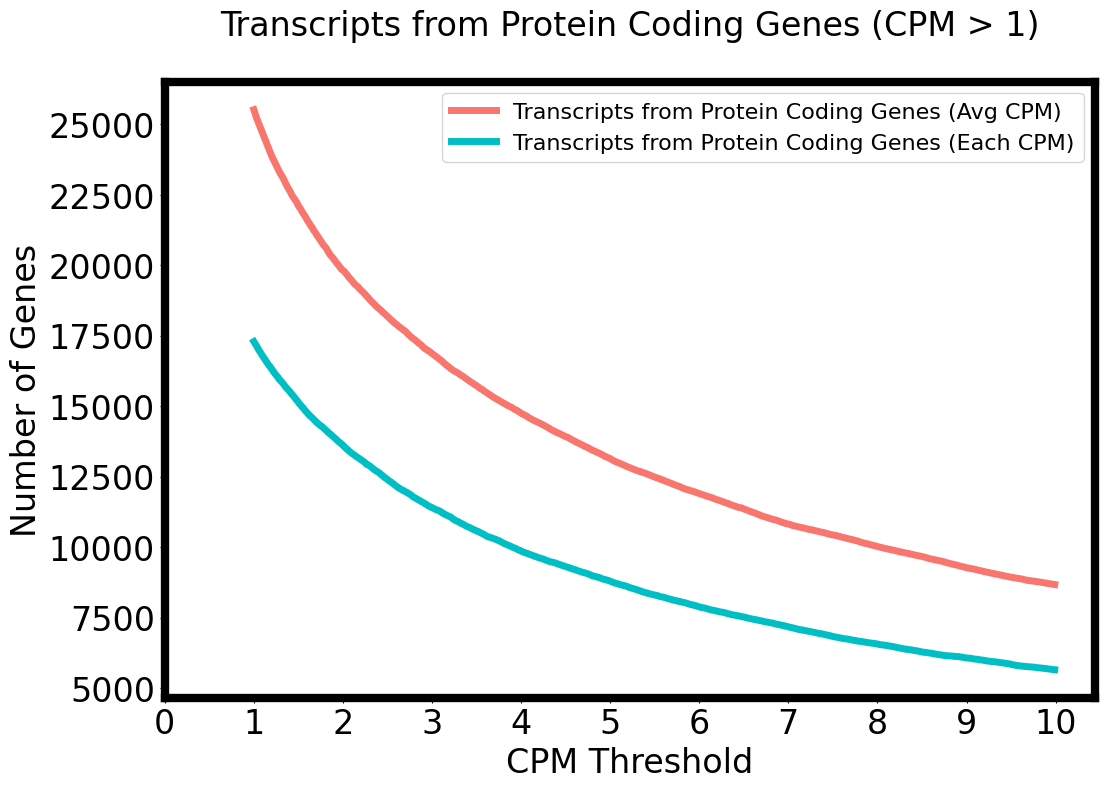

In [132]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_gene_transcripts_avg[100:], color=ggplot2_colors[0], label="Transcripts from Protein Coding Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_prot_gene_transcripts_each[100:], color=ggplot2_colors[4], label="Transcripts from Protein Coding Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts from Protein Coding Genes (CPM > 1)\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_gene_transcripts_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_gene_transcripts_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [133]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []


list_prot_genes_multiple_transcripts_avg = []
list_prot_genes_multiple_transcripts_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
   
    df_prot_gene_avg_multiple_iso = df_protein_gene.loc[df_protein_gene["total_CPM"] >= cpm_thresh].copy()
    df_prot_gene_each_multiple_iso = df_protein_gene[(df_protein_gene[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].copy()
    
    
    df_prot_gene_avg_multiple_iso = df_prot_gene_avg_multiple_iso.loc[df_prot_gene_avg_multiple_iso.duplicated(subset="gene_id", keep=False)]
    df_prot_gene_each_multiple_iso = df_prot_gene_each_multiple_iso.loc[df_prot_gene_each_multiple_iso.duplicated(subset="gene_id", keep=False)]
    
    num_prot_genes_muiltiple_isoform_avg = df_prot_gene_avg_multiple_iso["gene_id"].nunique()
    num_prot_genes_muiltiple_isoform_each = df_prot_gene_each_multiple_iso["gene_id"].nunique()

    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_genes_multiple_transcripts_avg.append(num_prot_genes_muiltiple_isoform_avg)
    list_prot_genes_multiple_transcripts_each.append(num_prot_genes_muiltiple_isoform_each)

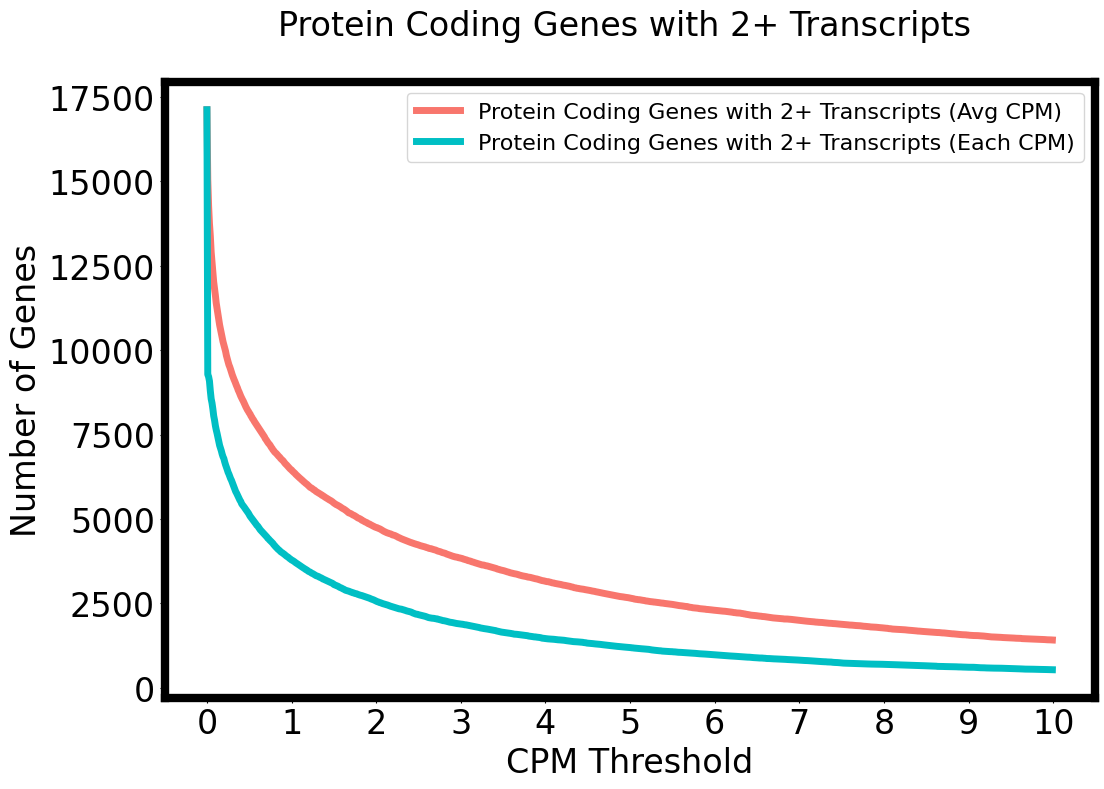

In [134]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh, list_prot_genes_multiple_transcripts_avg, color=ggplot2_colors[0], label="Protein Coding Genes with 2+ Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_prot_genes_multiple_transcripts_each, color=ggplot2_colors[4], label="Protein Coding Genes with 2+ Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Genes with 2+ Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_genes_with_multiple_isoforms_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_genes_with_multiple_isoforms_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

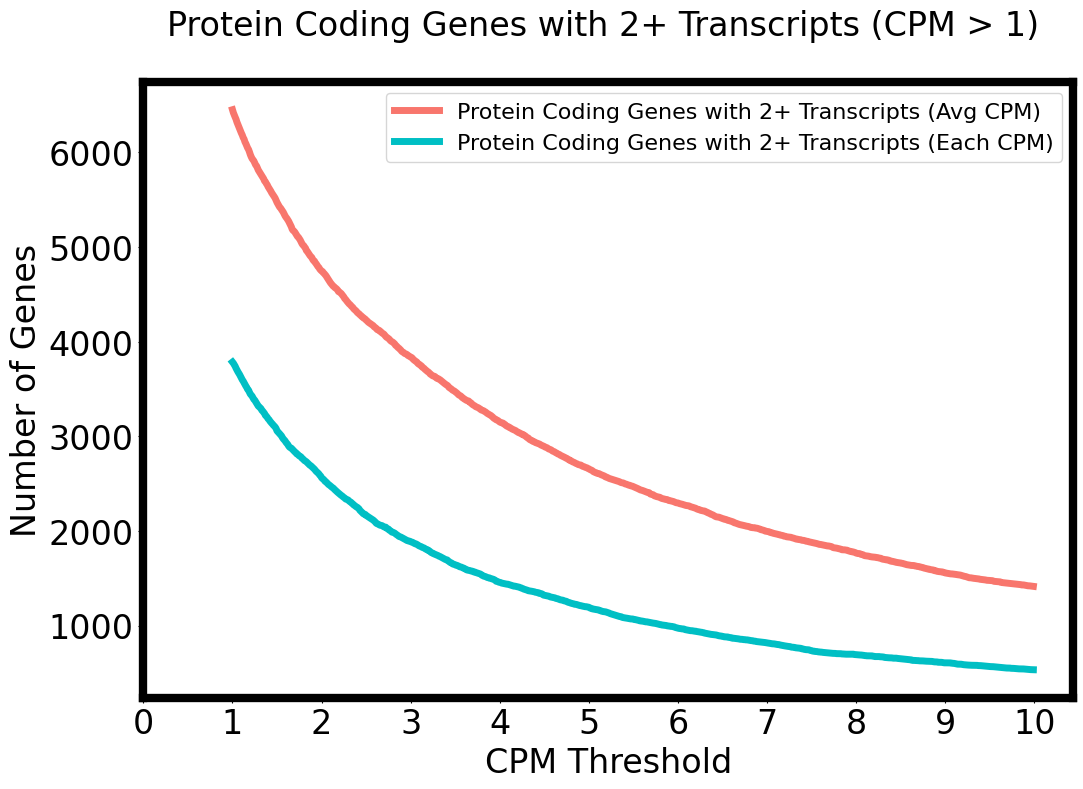

In [135]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh[100:], list_prot_genes_multiple_transcripts_avg[100:], color=ggplot2_colors[0], label="Protein Coding Genes with 2+ Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_prot_genes_multiple_transcripts_each[100:], color=ggplot2_colors[4], label="Protein Coding Genes with 2+ Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Genes with 2+ Transcripts (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_genes_with_multiple_isoforms_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/number_of_protein_coding_genes_with_multiple_isoforms_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [136]:
## Create CPM 5 Threhold multiple isoform filter

df_prot_avg_multiple_iso = df_protein_gene.loc[df_protein_gene["total_CPM"] >= cpm_thresh].copy()
df_prot_each_multiple_iso = df_protein_gene[(df_protein_gene[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].copy()

df_prot_avg_multiple_iso = df_prot_avg_multiple_iso.loc[df_prot_avg_multiple_iso.duplicated(subset="gene_id", keep=False)]
df_prot_each_multiple_iso = df_prot_each_multiple_iso.loc[df_prot_each_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_avg = df_prot_avg_multiple_iso["gene_id"].value_counts()
df_numbers_prot_multiple_isoforms_each = df_prot_each_multiple_iso["gene_id"].value_counts()


In [137]:
## Get numbers of genes with multiple CPM > 5 protein coding isoforms for both filters

df_num_isoforms_prot_avg = pd.DataFrame()
df_num_isoforms_prot_avg["Number of Protein Coding Genes"] = df_numbers_prot_multiple_isoforms_avg.value_counts()
df_num_isoforms_prot_avg["Number of  Transcripts"] = df_numbers_prot_multiple_isoforms_avg.value_counts().index

df_num_isoforms_prot_each = pd.DataFrame()
df_num_isoforms_prot_each["Number of Protein Coding Genes"] = df_numbers_prot_multiple_isoforms_each.value_counts()
df_num_isoforms_prot_each["Number of Transcripts"] = df_numbers_prot_multiple_isoforms_each.value_counts().index

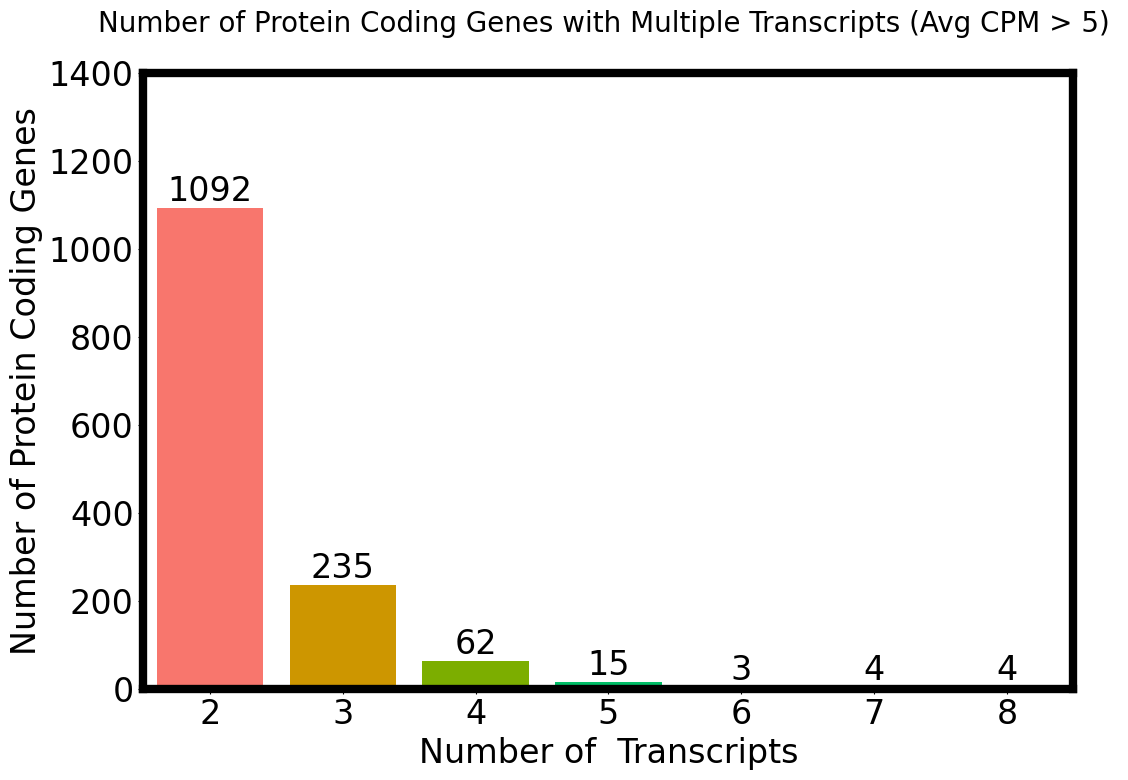

In [138]:
## Create and save graph showing number of protein coding genes with multiple isoforms (Avg CPM > 5)

ax = sns.barplot(data=df_num_isoforms_prot_avg, y="Number of Protein Coding Genes", x="Number of  Transcripts",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of Protein Coding Genes with Multiple Transcripts (Avg CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 1400))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/protein_coding_genes_with_multiple_transcripts_avg_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/protein_coding_genes_genes_with_transcripts_avg_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

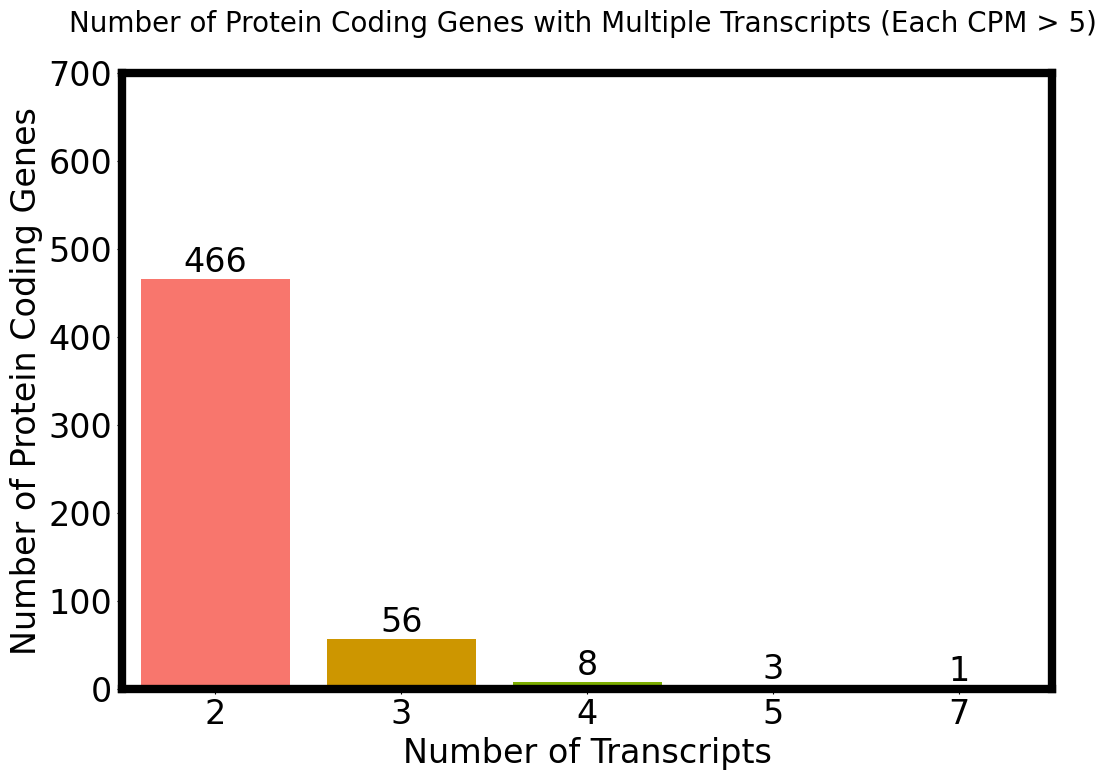

In [139]:
## Create and save graph showing number of protein coding genes with multiple isoforms (Each CPM > 5)

ax = sns.barplot(data=df_num_isoforms_prot_each, y="Number of Protein Coding Genes", x="Number of Transcripts",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of Protein Coding Genes with Multiple Transcripts (Each CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 700))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/protein_coding_genes_with_multiple_transcripts_each_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08A/protein_coding_genes_genes_with_transcripts_each_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

## 8B) Protein Coding Transcripts

In [140]:
## Make transcript_protein_coding_ref
orig_ref_prot = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_prot = parse_df_columns(orig_ref_prot, is_ref=True, is_transcript=True)
orig_ref_prot = orig_ref_prot.loc[orig_ref_prot["transcript_biotype"] == "protein_coding"]

In [141]:
## Only keep protein coding transcript in count matrix
protein_count = df_general.loc[df_general["transcript_id"].isin(orig_ref_prot["transcript_id"])].copy()

In [142]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_prot_avg = []
list_prot_each = []

list_prot_genes_avg = []
list_prot_genes_each = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    prot_avg_num = protein_count.loc[protein_count["total_CPM"] >= cpm_thresh].shape[0]
    prot_each_num = protein_count[(protein_count[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    prot_genes_avg_num = protein_count.loc[protein_count["total_CPM"] >= cpm_thresh]["gene_id"].nunique()
    prot_genes_each_num = protein_count[(protein_count[cpm_cols]>=cpm_thresh).sum(axis=1)>=5]["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_avg.append(prot_avg_num)
    list_prot_each.append(prot_each_num)
    
    list_prot_genes_avg.append(prot_genes_avg_num)
    list_prot_genes_each.append(prot_genes_each_num)

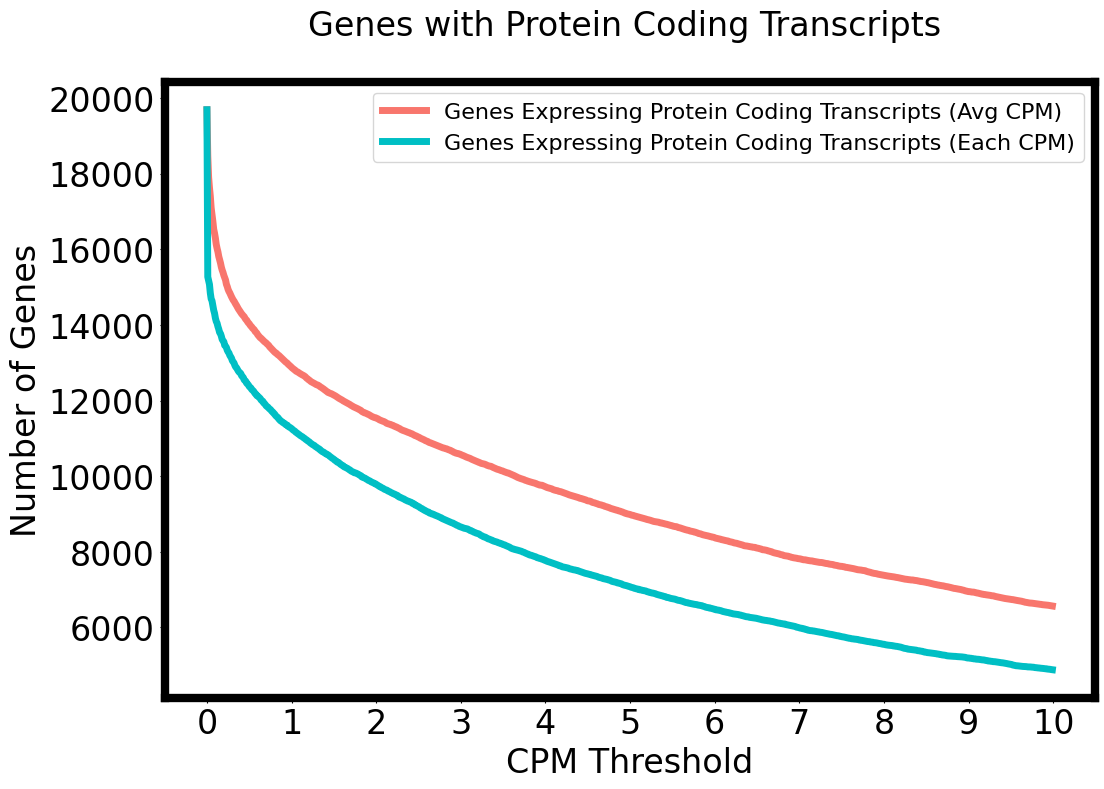

In [143]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_genes_avg, color=ggplot2_colors[0], label="Genes Expressing Protein Coding Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_prot_genes_each, color=ggplot2_colors[4], label="Genes Expressing Protein Coding Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes with Protein Coding Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_genes_with_protein_coding_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_genes_with_protein_coding_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

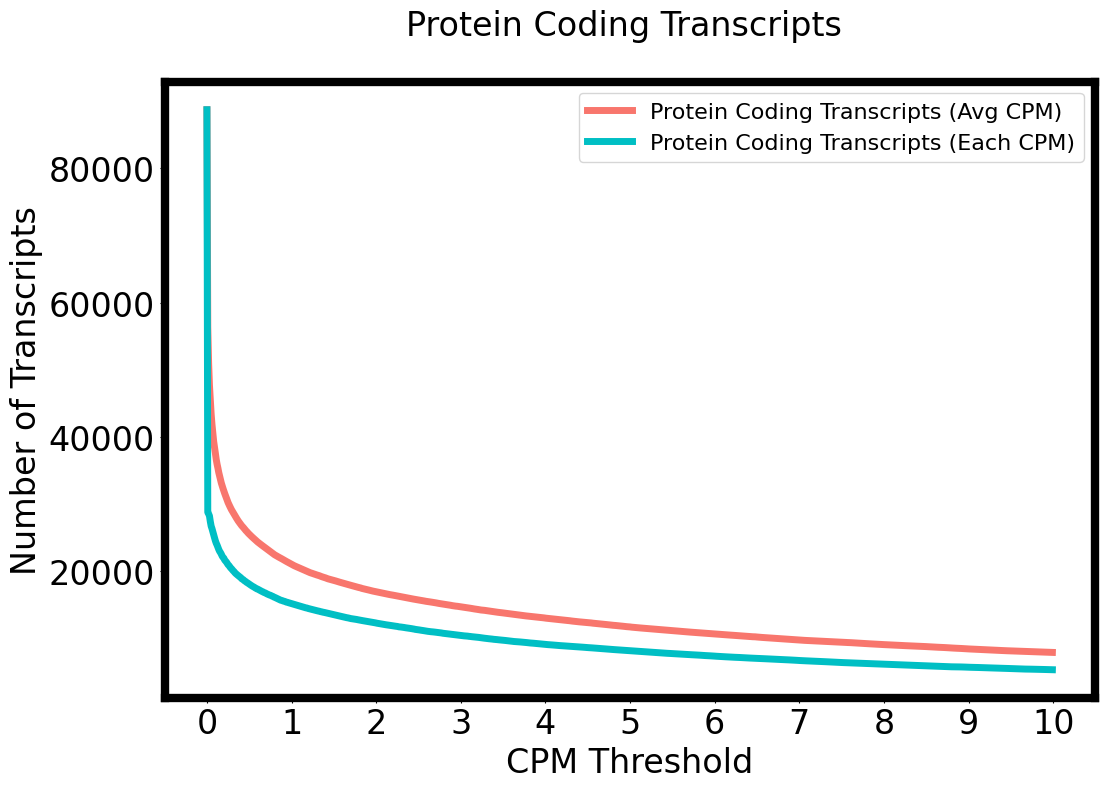

In [144]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_avg, color=ggplot2_colors[0], label="Protein Coding Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_prot_each, color=ggplot2_colors[4], label="Protein Coding Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_protein_coding_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_protein_coding_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

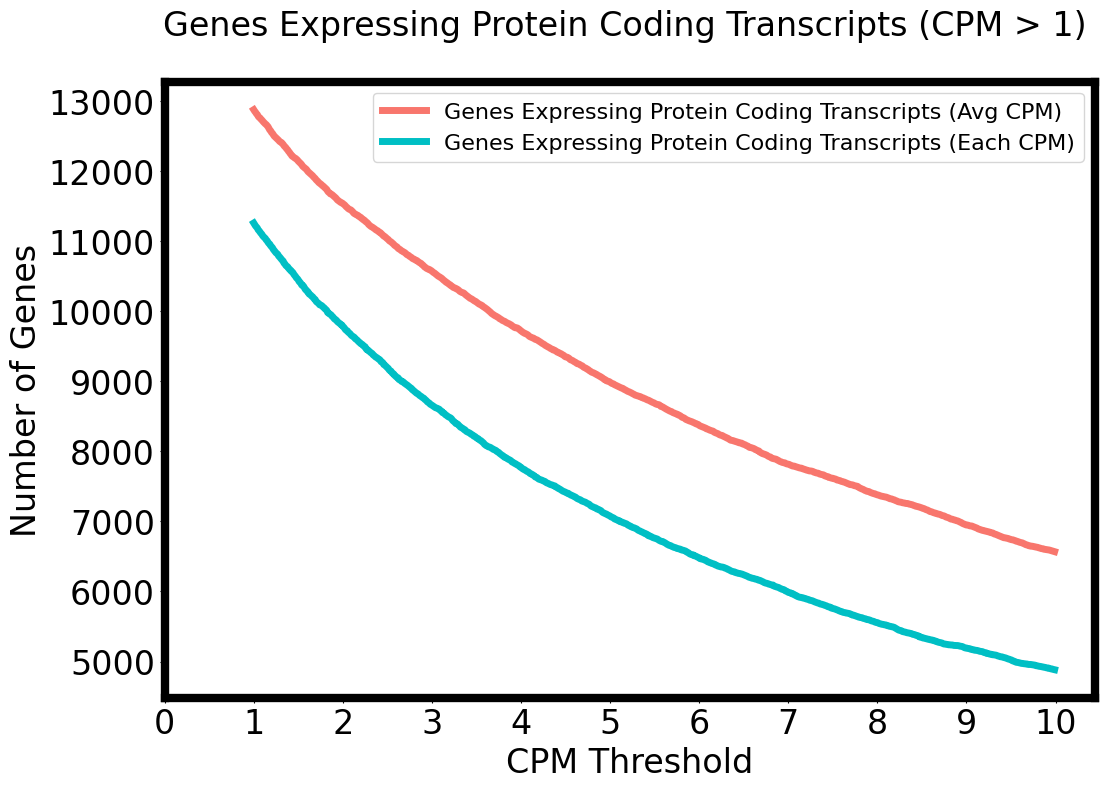

In [145]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_genes_avg[100:], color=ggplot2_colors[0], label="Genes Expressing Protein Coding Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_prot_genes_each[100:], color=ggplot2_colors[4], label="Genes Expressing Protein Coding Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes Expressing Protein Coding Transcripts (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_genes_with_protein_coding_transcripts_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_genes_with_protein_coding_transcripts_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

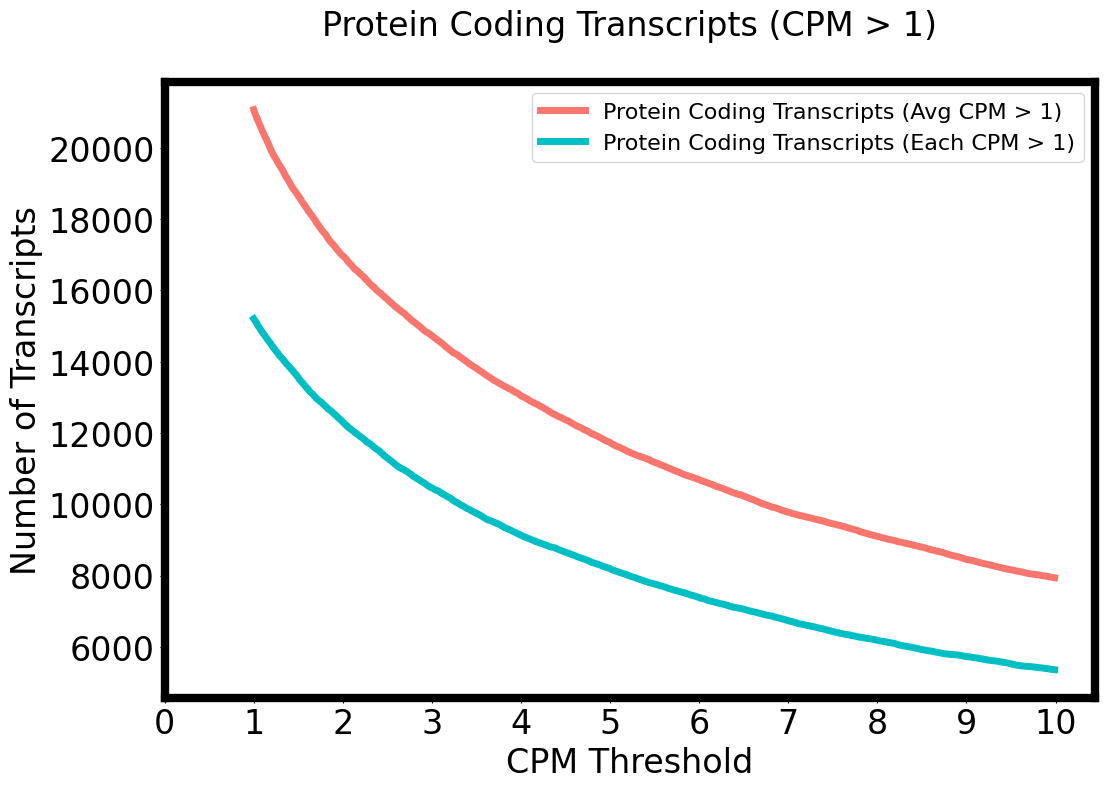

In [146]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_avg[100:], color=ggplot2_colors[0], label="Protein Coding Transcripts (Avg CPM > 1)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_prot_each[100:], color=ggplot2_colors[4], label="Protein Coding Transcripts (Each CPM > 1)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Transcripts (CPM > 1)\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_protein_coding_transcripts_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_protein_coding_transcripts_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [147]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_prot_multiple_isoforms_avg = []
list_prot_multiple_isoforms_each = []

list_genes_multiple_prot_isoforms_avg = []
list_genes_multiple_prot_isoforms_each = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
   
    df_prot_avg_multiple_iso = protein_count.loc[protein_count["total_CPM"] >= cpm_thresh].copy()
    df_prot_each_multiple_iso = protein_count[(protein_count[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].copy()
    
    df_prot_avg_multiple_iso = df_prot_avg_multiple_iso.loc[df_prot_avg_multiple_iso.duplicated(subset="gene_id", keep=False)]
    df_prot_each_multiple_iso = df_prot_each_multiple_iso.loc[df_prot_each_multiple_iso.duplicated(subset="gene_id", keep=False)]

    num_muiltiple_isoform_prot_avg = df_prot_avg_multiple_iso.shape[0]
    num_muiltiple_isoform_prot_each = df_prot_each_multiple_iso.shape[0]
    
    num_genes_muiltiple_isoform_prot_avg = df_prot_avg_multiple_iso["gene_id"].nunique()
    num_genes_muiltiple_isoform_prot_each = df_prot_each_multiple_iso["gene_id"].nunique()

    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_multiple_isoforms_avg.append(num_muiltiple_isoform_prot_avg)
    list_prot_multiple_isoforms_each.append(num_muiltiple_isoform_prot_each)
    
    list_genes_multiple_prot_isoforms_avg.append(num_genes_muiltiple_isoform_prot_avg)
    list_genes_multiple_prot_isoforms_each.append(num_genes_muiltiple_isoform_prot_each)

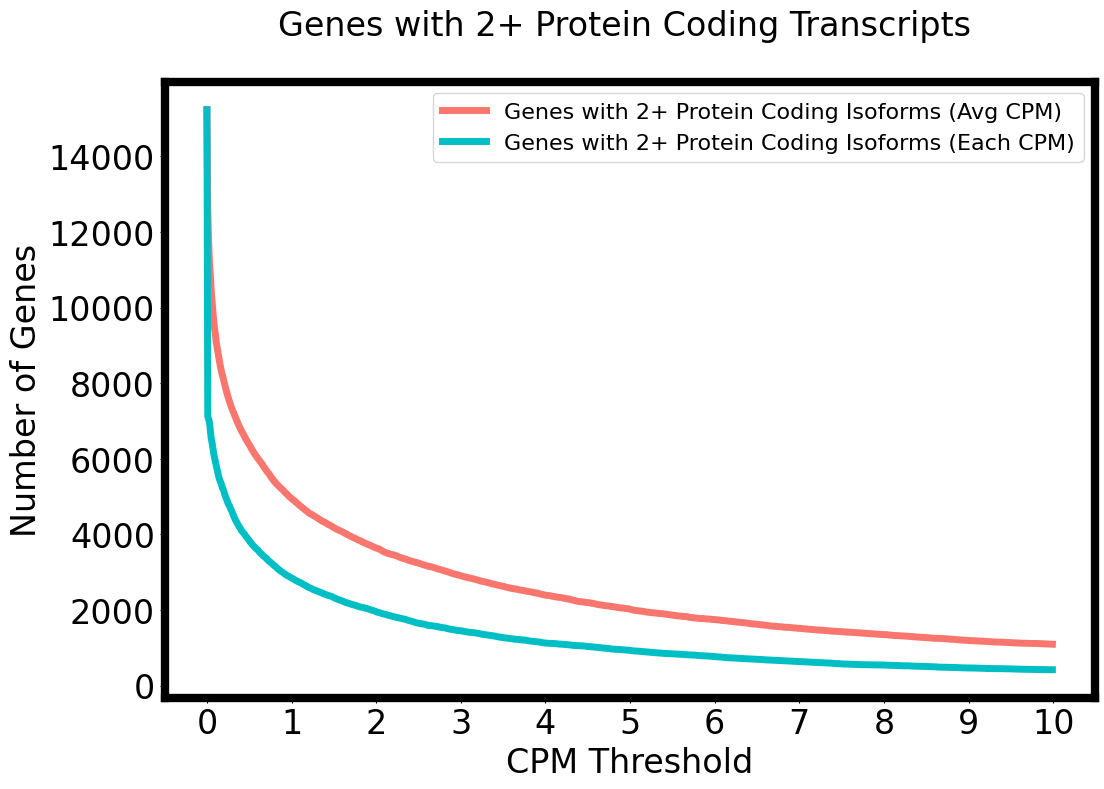

In [148]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh, list_genes_multiple_prot_isoforms_avg, color=ggplot2_colors[0], label="Genes with 2+ Protein Coding Isoforms (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_genes_multiple_prot_isoforms_each, color=ggplot2_colors[4], label="Genes with 2+ Protein Coding Isoforms (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes with 2+ Protein Coding Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_genes_with_multiple_protein_coding_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_genes_with_multiple_protein_coding_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

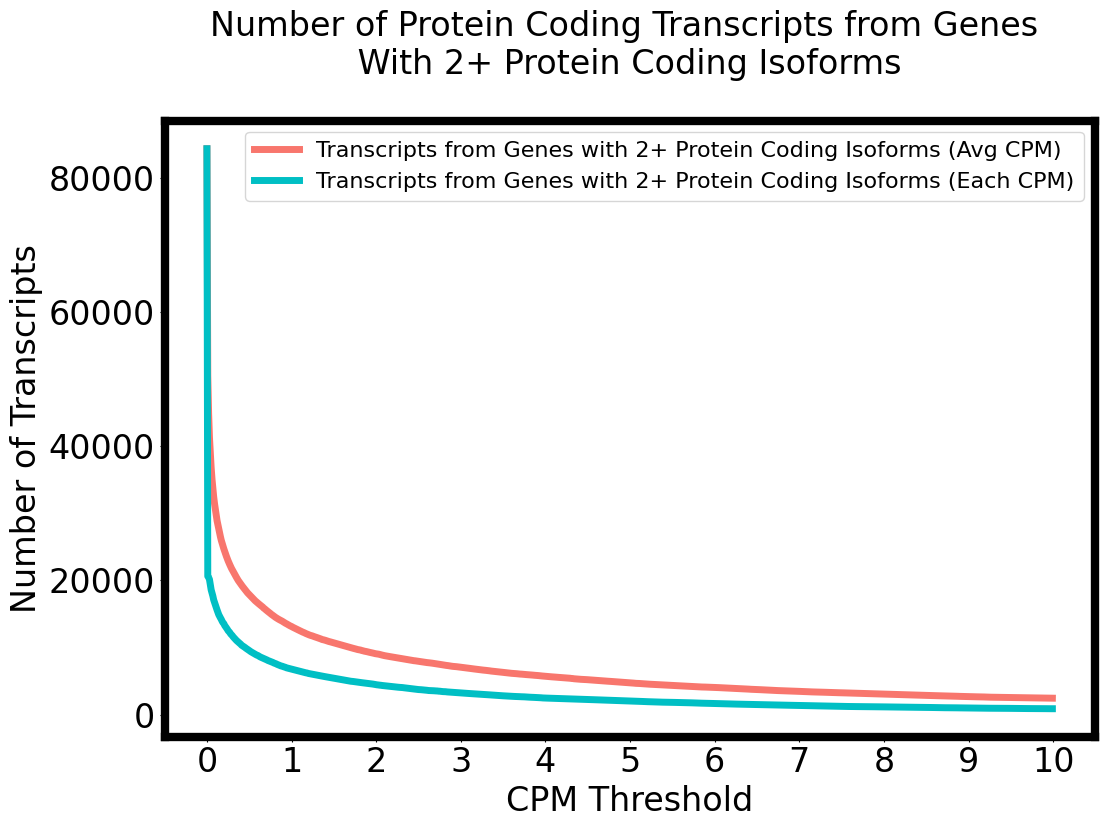

In [149]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh, list_prot_multiple_isoforms_avg, color=ggplot2_colors[0], label="Transcripts from Genes with 2+ Protein Coding Isoforms (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_prot_multiple_isoforms_each, color=ggplot2_colors[4], label="Transcripts from Genes with 2+ Protein Coding Isoforms (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Number of Protein Coding Transcripts from Genes \n With 2+ Protein Coding Isoforms \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_protein_coding_genes_from_genes_expressing_multiple_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_protein_coding_genes_from_genes_expressing_multiple_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

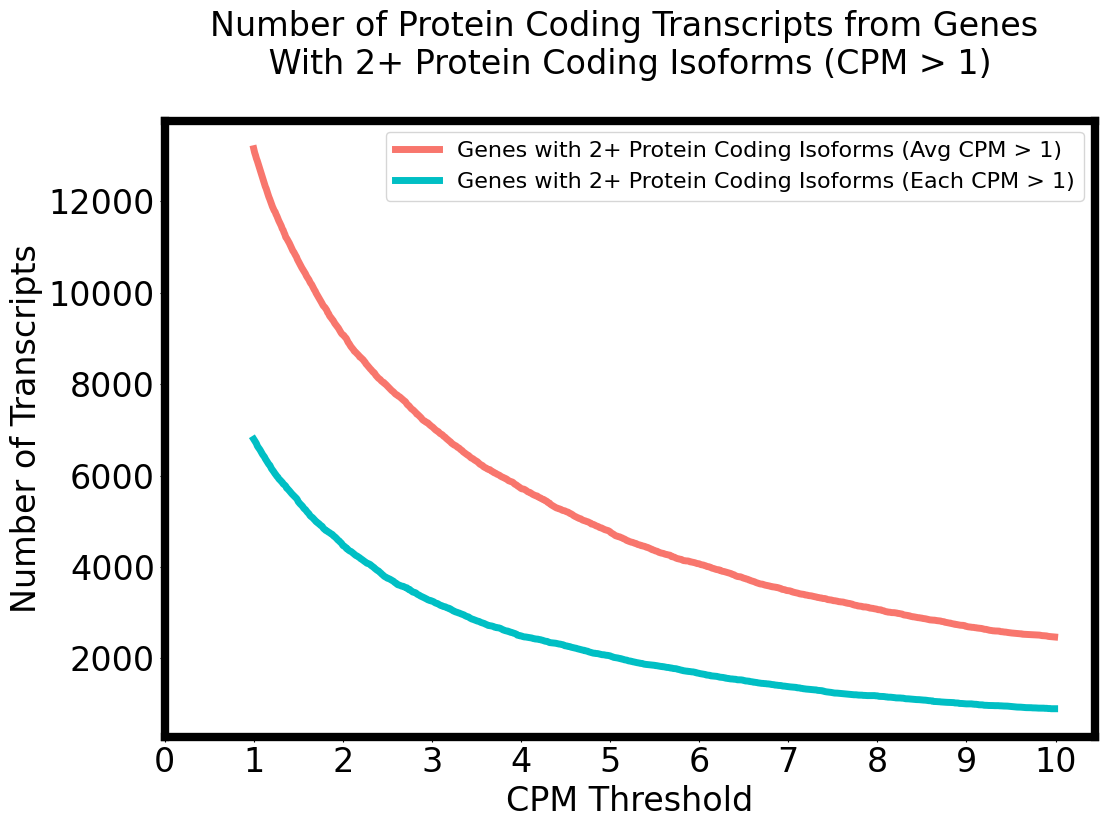

In [150]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh[100:], list_prot_multiple_isoforms_avg[100:], color=ggplot2_colors[0], label="Genes with 2+ Protein Coding Isoforms (Avg CPM > 1)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_prot_multiple_isoforms_each[100:], color=ggplot2_colors[4], label="Genes with 2+ Protein Coding Isoforms (Each CPM > 1)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Number of Protein Coding Transcripts from Genes \n With 2+ Protein Coding Isoforms (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_protein_coding_genes_with_multiple_protein_coding_isoforms_across_cpm_thresh_cpm_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/number_of_protein_coding_genes_with_multiple_protein_coding_isoforms_across_cpm_thresh_cpm_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [151]:
## Create CPM 5 Threhold multiple isoform filter

df_prot_avg_multiple_iso = protein_count.loc[protein_count["total_CPM"] >= cpm_thresh].copy()
df_prot_each_multiple_iso = protein_count[(protein_count[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].copy()

df_prot_avg_multiple_iso = df_prot_avg_multiple_iso.loc[df_prot_avg_multiple_iso.duplicated(subset="gene_id", keep=False)]
df_prot_each_multiple_iso = df_prot_each_multiple_iso.loc[df_prot_each_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_avg = df_prot_avg_multiple_iso["gene_id"].value_counts()
df_numbers_prot_multiple_isoforms_each = df_prot_each_multiple_iso["gene_id"].value_counts()


In [152]:
## Get numbers of genes with multiple CPM > 5 protein coding isoforms for both filters

df_num_isoforms_prot_avg = pd.DataFrame()
df_num_isoforms_prot_avg["Number of Genes"] = df_numbers_prot_multiple_isoforms_avg.value_counts()
df_num_isoforms_prot_avg["Number of Protein Coding Isoforms"] = df_numbers_prot_multiple_isoforms_avg.value_counts().index

df_num_isoforms_prot_each = pd.DataFrame()
df_num_isoforms_prot_each["Number of Genes"] = df_numbers_prot_multiple_isoforms_each.value_counts()
df_num_isoforms_prot_each["Number of Protein Coding Isoforms"] = df_numbers_prot_multiple_isoforms_each.value_counts().index

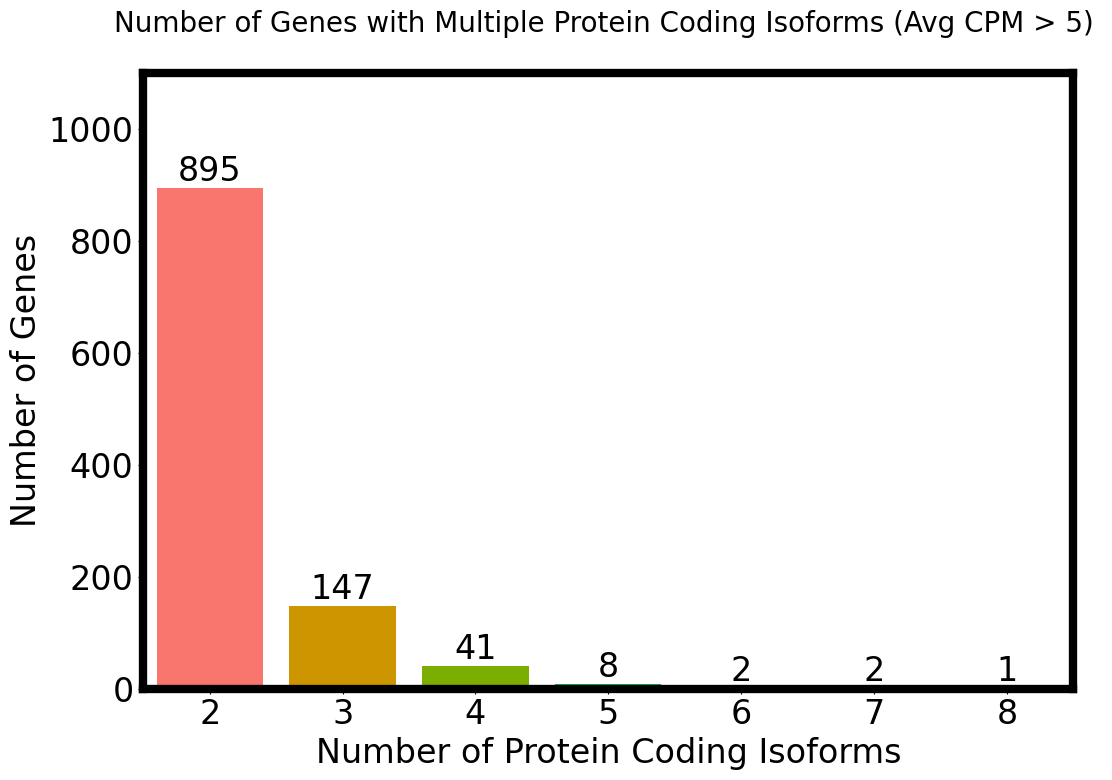

In [153]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 5)

ax = sns.barplot(data=df_num_isoforms_prot_avg, y="Number of Genes", x="Number of Protein Coding Isoforms",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of Genes with Multiple Protein Coding Isoforms (Avg CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 1100))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/genes_with_multiple_protein_coding_transcripts_avg_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/genes_with_multiple_protein_coding_transcripts_avg_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

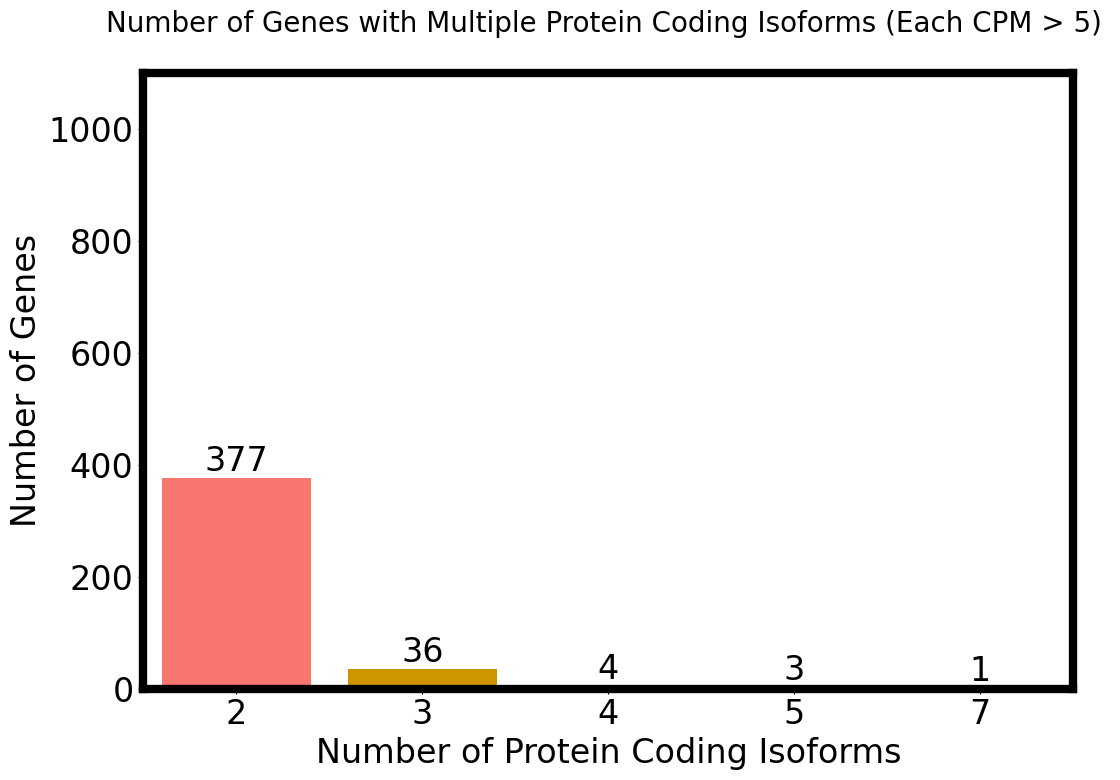

In [154]:
## Create and save graph showing number of genes with multiple protein coding isoforms (Each CPM > 5)

ax = sns.barplot(data=df_num_isoforms_prot_each, y="Number of Genes", x="Number of Protein Coding Isoforms",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of Genes with Multiple Protein Coding Isoforms (Each CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 1100))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/genes_with_multiple_protein_coding_transcripts_each_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08B/genes_with_multiple_protein_coding_transcripts_each_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 8C) Protein Coding Transcripts Encoding Different Proteins

In [155]:
## Make reference only including protein coding transcripts with a defined CDS
orig_ref_cds = original_ref.loc[original_ref["type"]=="CDS"].copy()
orig_ref_cds = parse_df_columns(orig_ref_cds, is_ref=True, is_transcript=True, is_prot=True)

orig_ref_cds = orig_ref_cds.loc[orig_ref_cds["transcript_biotype"] == "protein_coding"].copy()

In [156]:
orig_ref_cds_missing = orig_ref_cds.loc[orig_ref_cds["ccds_id"].isna()].copy()

In [157]:
## Create a start_end string for CDS regions
orig_ref_cds_missing["start"] = orig_ref_cds_missing["start"].astype("str")
orig_ref_cds_missing["end"] = orig_ref_cds_missing["end"].astype("str")
orig_ref_cds_missing["start_end"] = orig_ref_cds_missing["start"] + orig_ref_cds_missing["end"]
orig_ref_cds_missing.drop(columns=["start", "end"], inplace=True)

In [158]:
## Create unique ccds identifier based on sum of exon start and end sites for each CCDS
unique_cds_ref = orig_ref_cds_missing[["transcript_id", "exon_number", "start_end"]].copy()
unique_cds_ref = unique_cds_ref.sort_values(by=["transcript_id", "exon_number"])
unique_cds_ref.drop(columns="exon_number", inplace=True)

df_unique_id_ccds = unique_cds_ref.copy().groupby('transcript_id').sum()
df_unique_id_ccds["unique_ccds_identifier"] = df_unique_id_ccds["start_end"]
df_unique_id_ccds.drop(columns="start_end", inplace=True)

In [159]:
## Create a column to store new ccds id in
df_unique_id_ccds["ccds_id"] = np.nan

In [160]:
## Loop through to create new Bernardo CCDS ID (BCCDSID)
j = 0
list_already_counted = []

for i in range(df_unique_id_ccds.shape[0]):
    
    if df_unique_id_ccds.iat[i,0] in list_already_counted:
        df_unique_id_ccds.iat[i,1] = "BCCDSID_" + str(j)
        
    else:
        j = j + 1
        df_unique_id_ccds.iat[i,1] = "BCCDSID_" + str(j)
        list_already_counted.append(df_unique_id_ccds.iat[i,0])
        
df_unique_id_ccds.drop(columns="unique_ccds_identifier", inplace=True)
df_unique_id_ccds["transcript_id"] = df_unique_id_ccds.index
df_unique_id_ccds.reset_index(drop=True, inplace=True)

In [161]:
orig_ref_cds_not_missing = orig_ref_cds.loc[~orig_ref_cds["ccds_id"].isna()].copy()

orig_ref_cds_not_missing = orig_ref_cds_not_missing[["transcript_id", "ccds_id"]].copy().drop_duplicates()

ref_cds = pd.concat([orig_ref_cds_not_missing, df_unique_id_ccds])

ref_cds.drop_duplicates(inplace=True)

In [162]:
## Only keep protein coding transcripts in expression matrix, adding ccds_ids
df_prot_coding = df_general.merge(ref_cds[["transcript_id", "ccds_id"]],
                                  how="inner", on="transcript_id").drop_duplicates()

In [163]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_diff_prot_cod_avg = []
list_diff_prot_cod_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    df_diff_prot_cod_avg = df_prot_coding.loc[df_prot_coding["total_CPM"] >= cpm_thresh]["ccds_id"].nunique()
    df_diff_prot_cod_each = df_prot_coding[(df_prot_coding[cpm_cols]>=cpm_thresh).sum(axis=1)>=5]["ccds_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_diff_prot_cod_avg.append(df_diff_prot_cod_avg)
    list_diff_prot_cod_each.append(df_diff_prot_cod_each)

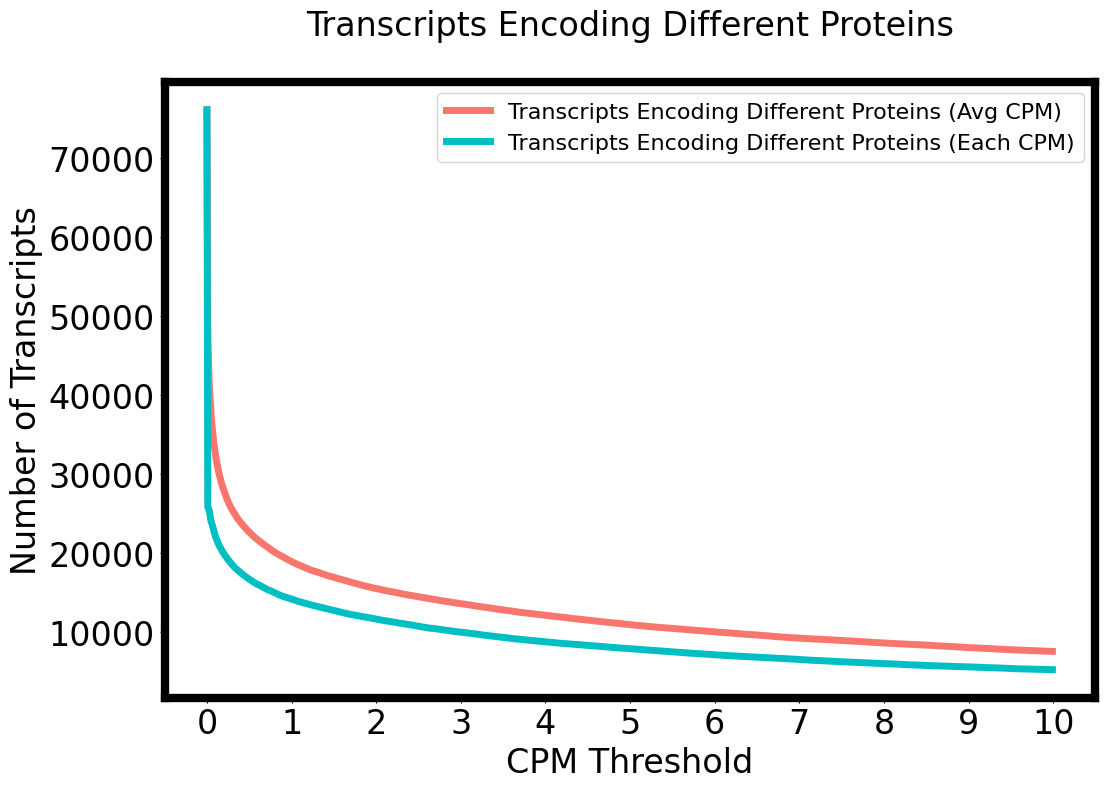

In [164]:
## Make plot showing number of different CDS transcripts from genes expressing 2+ Transcripts with a different CDS

plt.plot(list_cpm_thresh, list_diff_prot_cod_avg, color=ggplot2_colors[0], label="Transcripts Encoding Different Proteins (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_diff_prot_cod_each, color=ggplot2_colors[4], label="Transcripts Encoding Different Proteins (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts Encoding Different Proteins\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/transcripts_encoding_different_proteins_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/transcripts_encoding_different_proteins_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

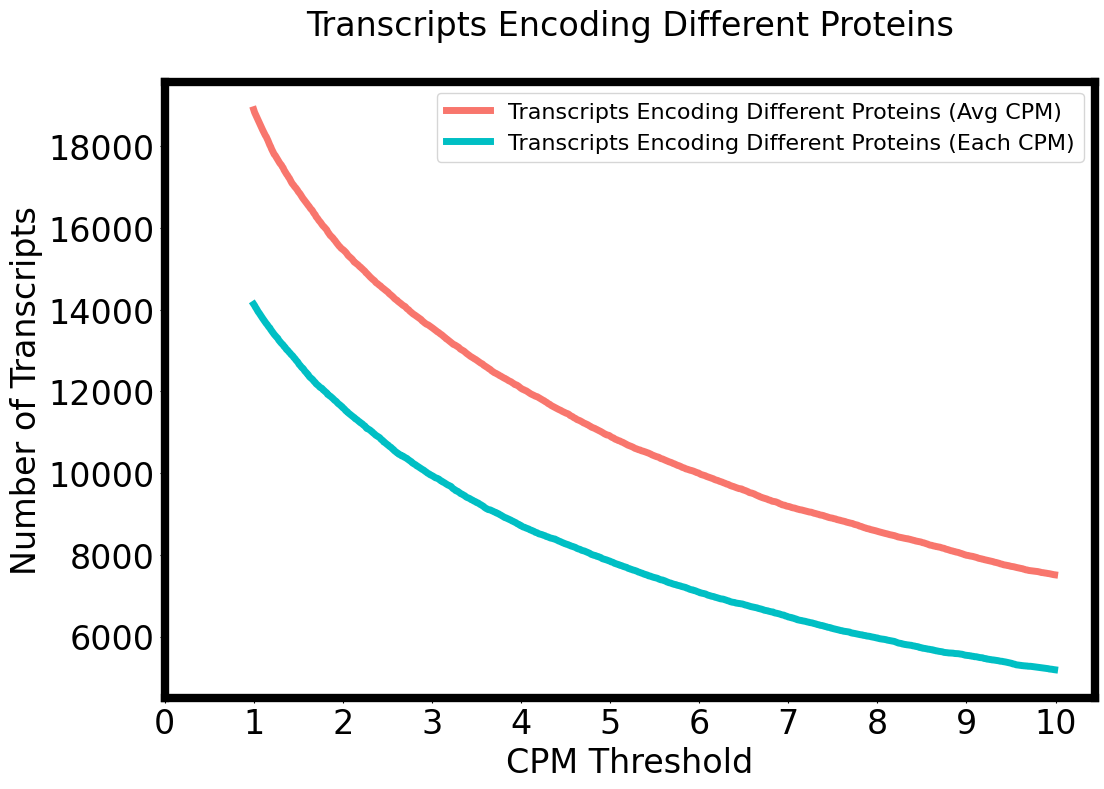

In [165]:
## Make plot showing number of different CDS transcripts from genes expressing 2+ Transcripts with a different CDS

plt.plot(list_cpm_thresh[100:], list_diff_prot_cod_avg[100:], color=ggplot2_colors[0], label="Transcripts Encoding Different Proteins (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_diff_prot_cod_each[100:], color=ggplot2_colors[4], label="Transcripts Encoding Different Proteins (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts Encoding Different Proteins\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/transcripts_encoding_different_proteins_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/transcripts_encoding_different_proteins_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [166]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_multiple_protein_isoforms_avg = []
list_multiple_protein_isoforms_each = []

list_genes_multiple_proteins_avg = []
list_genes_multiple_proteins_each = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
   
    df_avg_multiple_proteins = df_prot_coding.loc[df_prot_coding["total_CPM"] >= cpm_thresh].copy()
    df_each_multiple_proteins = df_prot_coding[(df_prot_coding[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].copy()
    
    df_prot_avg_multiple = df_avg_multiple_proteins.loc[df_avg_multiple_proteins.duplicated(subset="ccds_id", keep=False)].copy()
    df_prot_each_multiple = df_each_multiple_proteins.loc[df_each_multiple_proteins.duplicated(subset="ccds_id", keep=False)].copy()

    num_muiltiple_isoform_prot_avg = df_prot_avg_multiple.shape[0]
    num_muiltiple_isoform_prot_each = df_prot_each_multiple.shape[0]
    
    num_genes_muiltiple_prot_avg = df_prot_avg_multiple["gene_id"].nunique()
    num_genes_muiltiple_prot_each = df_prot_each_multiple["gene_id"].nunique()

    
    list_cpm_thresh.append(cpm_thresh)
    
    list_multiple_protein_isoforms_avg.append(num_muiltiple_isoform_prot_avg)
    list_multiple_protein_isoforms_each.append(num_muiltiple_isoform_prot_each)
    
    list_genes_multiple_proteins_avg.append(num_genes_muiltiple_prot_avg)
    list_genes_multiple_proteins_each.append(num_genes_muiltiple_prot_each)

In [167]:
## CCDS_IDs with more than 20 transcripts_ids assigned to them

protein_id_multiple_transcripts = df_prot_coding["ccds_id"].value_counts().loc[df_prot_coding["ccds_id"].value_counts() > 20].index.to_list()
genes_encoding_multiple_proteins = df_prot_coding.loc[df_prot_coding["ccds_id"].isin(protein_id_multiple_transcripts)]["gene_id"].copy()
genes_encoding_multiple_proteins.drop_duplicates(inplace=True)

print("Genes with more than 20 transcripts enconding the same CDS:\n", genes_encoding_multiple_proteins.to_list())

Genes with more than 20 transcripts enconding the same CDS:
 ['ENSG00000169255', 'ENSG00000164733', 'ENSG00000168036', 'ENSG00000087053', 'ENSG00000121940', 'ENSG00000157601']


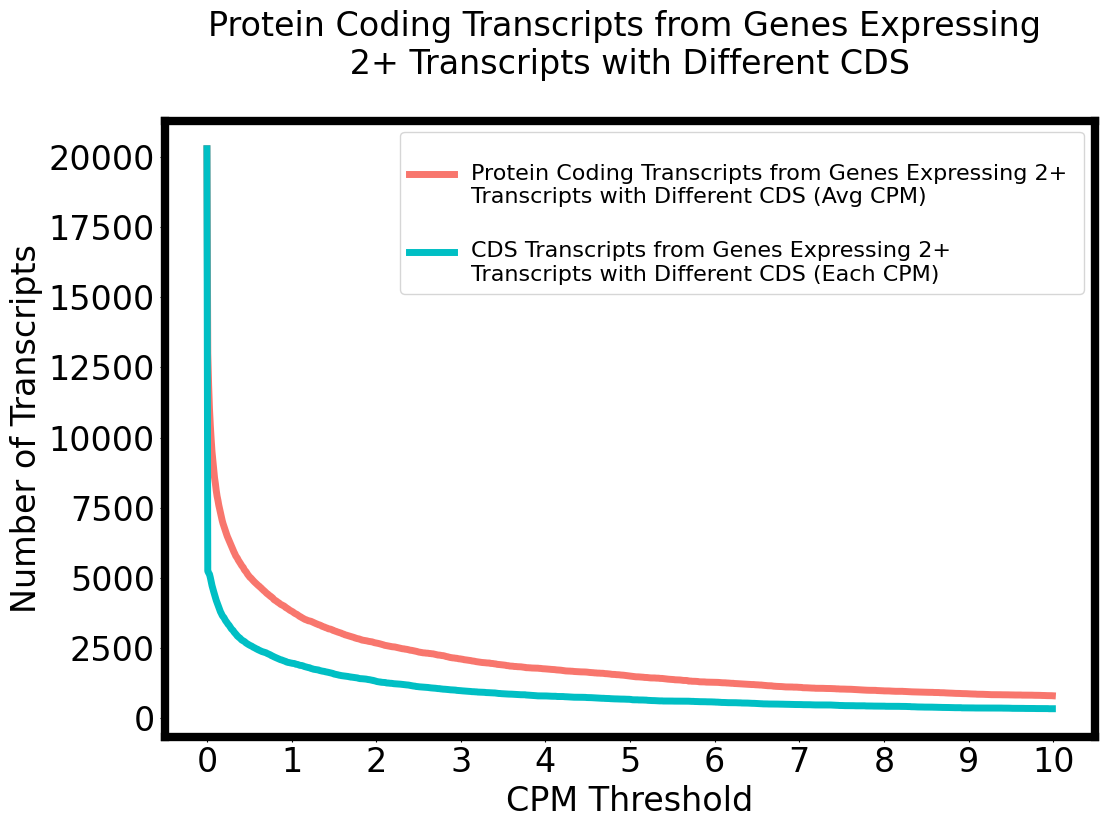

In [168]:
## Make plot showing number of different CDS transcripts from genes expressing 2+ Transcripts with a different CDS

plt.plot(list_cpm_thresh, list_multiple_protein_isoforms_avg, color=ggplot2_colors[0], label="\nProtein Coding Transcripts from Genes Expressing 2+ \nTranscripts with Different CDS (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_multiple_protein_isoforms_each, color=ggplot2_colors[4], label="\nCDS Transcripts from Genes Expressing 2+ \nTranscripts with Different CDS (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Transcripts from Genes Expressing \n 2+ Transcripts with Different CDS \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/number_of_cds_transcripts_from_genes_expressing_muliple_cds_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/number_of_cds_transcripts_from_genes_expressing_muliple_cds_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

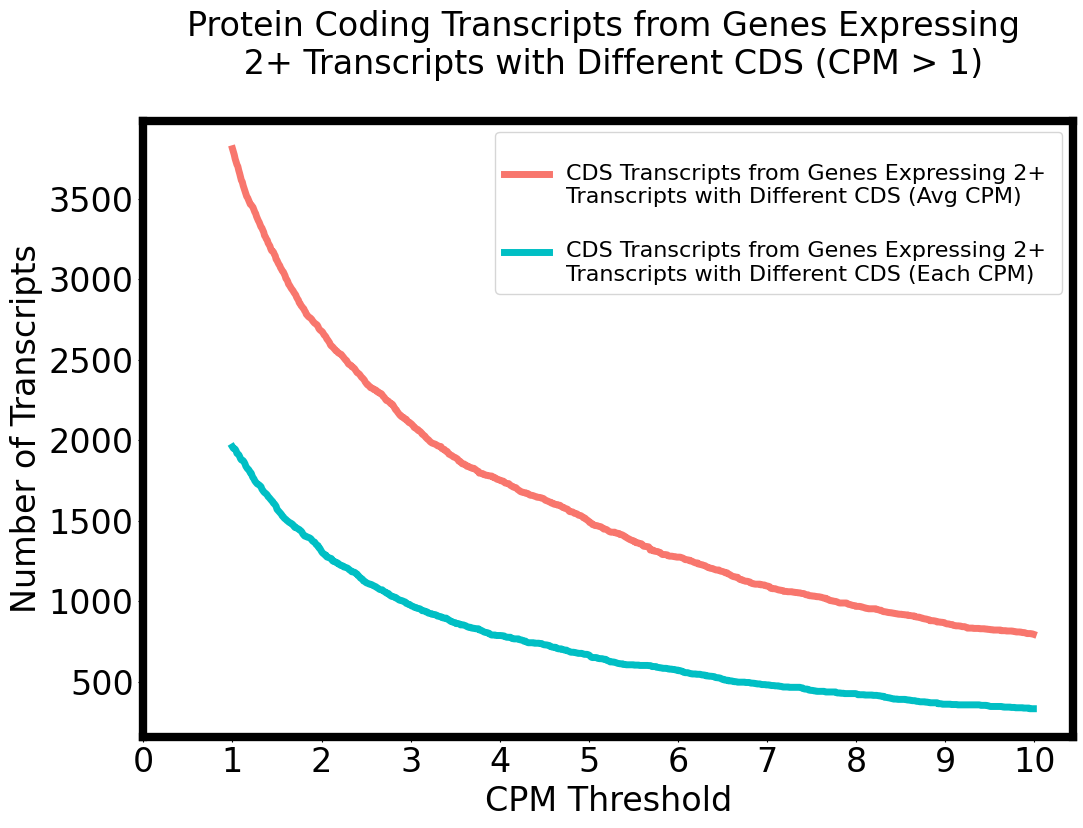

In [169]:
## Make plot showing number of different CDS transcripts from genes expressing 2+ Transcripts with a different CDS (CPM > 1)

plt.plot(list_cpm_thresh[100:], list_multiple_protein_isoforms_avg[100:], color=ggplot2_colors[0], label="\nCDS Transcripts from Genes Expressing 2+ \nTranscripts with Different CDS (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_multiple_protein_isoforms_each[100:], color=ggplot2_colors[4], label="\nCDS Transcripts from Genes Expressing 2+ \nTranscripts with Different CDS (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Transcripts from Genes Expressing \n 2+ Transcripts with Different CDS (CPM > 1)\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/number_of_cds_transcripts_from_genes_expressing_muliple_cds_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/number_of_cds_transcripts_from_genes_expressing_muliple_cds_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

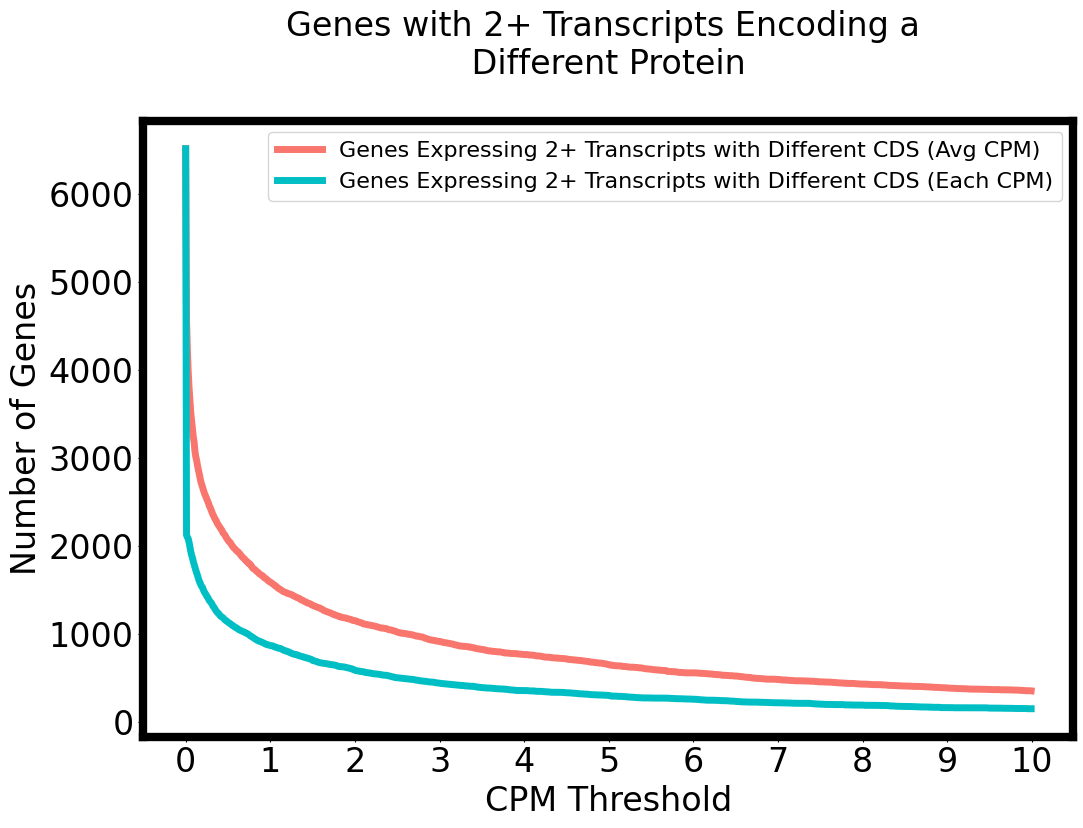

In [170]:
## Make plot showing number of genes expressing 2+ Transcripts with a different CDS 

plt.plot(list_cpm_thresh, list_genes_multiple_proteins_avg, color=ggplot2_colors[0], label="Genes Expressing 2+ Transcripts with Different CDS (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_genes_multiple_proteins_each, color=ggplot2_colors[4], label="Genes Expressing 2+ Transcripts with Different CDS (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes with 2+ Transcripts Encoding a \n Different Protein \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/number_of_protein_coding_genes_expressing_multiple_CDS_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/number_of_protein_coding_genes_expressing_multiple_CDS_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

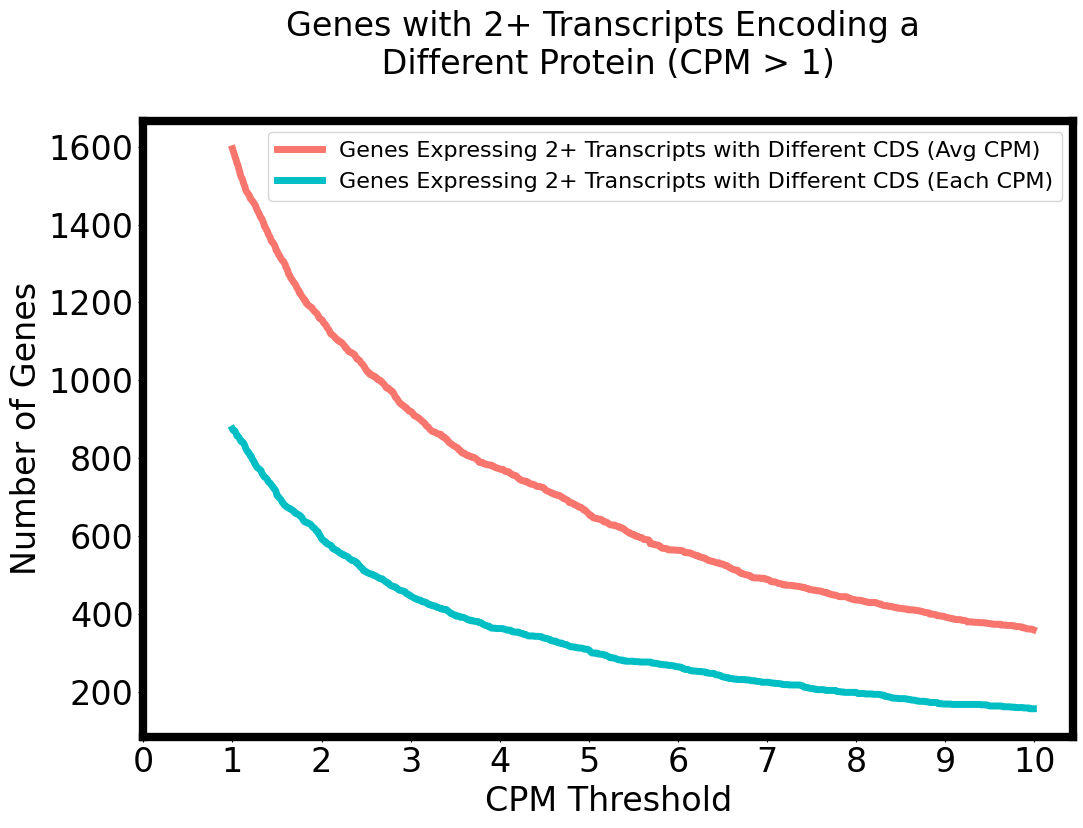

In [171]:
## Make plot showing number of genes expressing 2+ Transcripts with a different CDS (CPM > 1)

plt.plot(list_cpm_thresh[100:], list_genes_multiple_proteins_avg[100:], color=ggplot2_colors[0], label="Genes Expressing 2+ Transcripts with Different CDS (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_genes_multiple_proteins_each[100:], color=ggplot2_colors[4], label="Genes Expressing 2+ Transcripts with Different CDS (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes with 2+ Transcripts Encoding a \n Different Protein (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/number_of_protein_coding_genes_expressing_multiple_CDS_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/number_of_protein_coding_genes_expressing_multiple_CDS_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [172]:
## Create CPM 5 Threhold multiple isoform filter

df_prot_avg_multiple_iso = df_prot_coding.loc[df_prot_coding["total_CPM"] >= 5].copy()
df_prot_each_multiple_iso = df_prot_coding[(df_prot_coding[cpm_cols]>=5).sum(axis=1)>=5].copy()

df_prot_avg_multiple_iso = df_prot_avg_multiple_iso.loc[df_prot_avg_multiple_iso.duplicated(subset="ccds_id", keep=False)]
df_prot_each_multiple_iso = df_prot_each_multiple_iso.loc[df_prot_each_multiple_iso.duplicated(subset="ccds_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_avg = df_prot_avg_multiple_iso["gene_id"].value_counts()
df_numbers_prot_multiple_isoforms_each = df_prot_each_multiple_iso["gene_id"].value_counts()

In [173]:
## Get numbers of genes with multiple CPM > 5 protein coding isoforms for both filters

df_num_isoforms_prot_avg = pd.DataFrame()
df_num_isoforms_prot_avg["Number of Genes"] = df_numbers_prot_multiple_isoforms_avg.value_counts()
df_num_isoforms_prot_avg["Number of Transcripts Encoding Different Proteins"] = df_numbers_prot_multiple_isoforms_avg.value_counts().index

df_num_isoforms_prot_each = pd.DataFrame()
df_num_isoforms_prot_each["Number of Genes"] = df_numbers_prot_multiple_isoforms_each.value_counts()
df_num_isoforms_prot_each["Number of Transcripts Encoding Different Proteins"] = df_numbers_prot_multiple_isoforms_each.value_counts().index

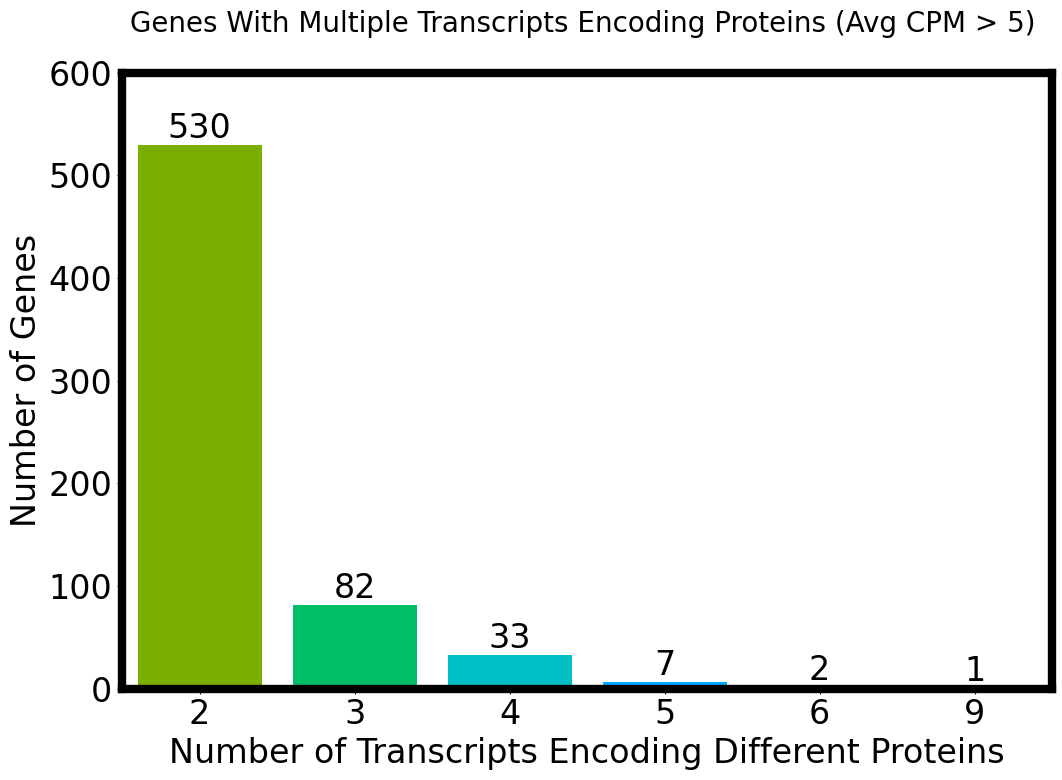

In [174]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 5)

ax = sns.barplot(data=df_num_isoforms_prot_avg, y="Number of Genes", x="Number of Transcripts Encoding Different Proteins",
            palette=ggplot2_colors[1:], saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Genes With Multiple Transcripts Encoding Proteins (Avg CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 600))
ax.set(xlim=(0.5))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/genes_with_multiple_different_cds_transcripts_avg_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/genes_with_multiple_different_cds_transcripts_avg_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

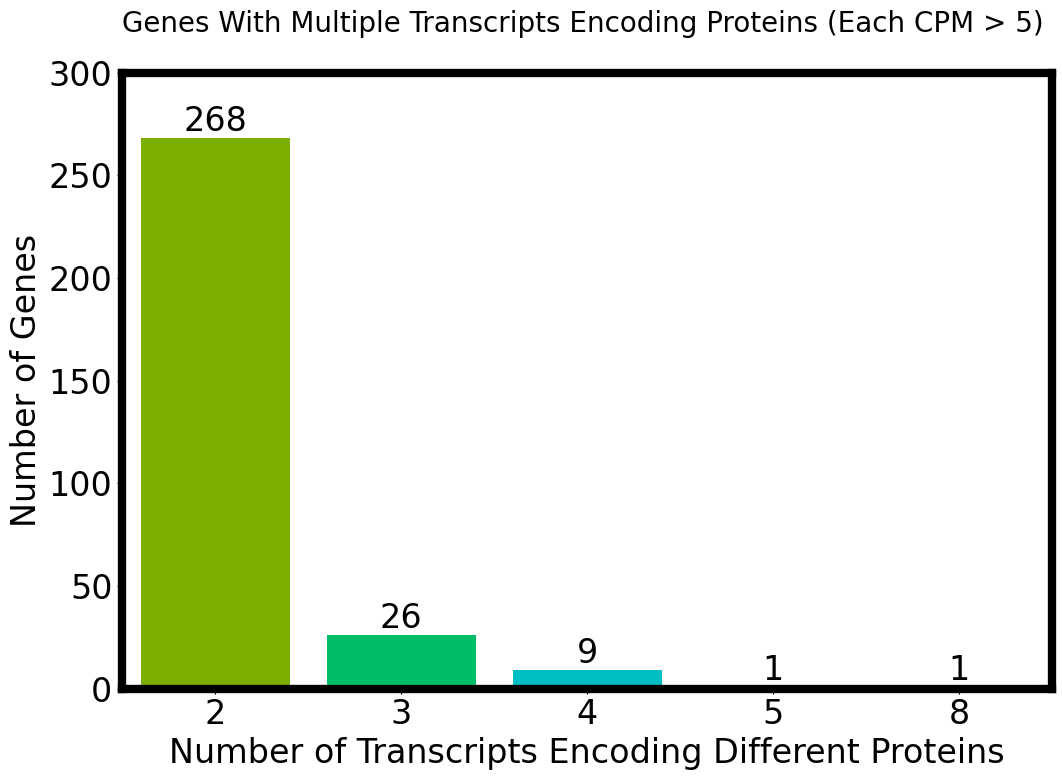

In [175]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 5)

ax = sns.barplot(data=df_num_isoforms_prot_each, y="Number of Genes", x="Number of Transcripts Encoding Different Proteins",
            palette=ggplot2_colors[1:], saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Genes With Multiple Transcripts Encoding Proteins (Each CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 300))
ax.set(xlim=(0.5))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/genes_with_multiple_different_cds_transcripts_each_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/08C/genes_with_multiple_different_cds_transcripts_each_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 9) Quantification of transcript found between Ensembl Release 94 and 107

In [176]:
## Get all transcript IDs from ENSEMBL 94 GTF

df_ensembl_94 =ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.94.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

df_ensembl_94 = df_ensembl_94.loc[df_ensembl_94["type"] == "transcript"].copy()

df_ensembl_94 = parse_df_columns(df_ensembl_94, is_ref=True, is_transcript=True)

ensembl_94_transcript_ids = df_ensembl_94["transcript_id"].copy()

In [ ]:
## Get transcript names from ENSEMBL 107 GTF

ensembl_107_transcripts = original_ref.loc[original_ref["type"] == "transcript"].copy()
ensembl_107_transcripts = parse_df_columns(ensembl_107_transcripts, is_ref=True, is_transcript=True)

In [ ]:
## Only keep transcripts that are different between ensembl_94 and ensembl_107

ensembl_107_exclusive_transcripts = ensembl_107_transcripts.loc[~ensembl_107_transcripts["transcript_id"].isin(ensembl_94_transcript_ids)].copy()

In [ ]:
## Save file with ENSEMBL 107 exclusive transcripts to send to maddie

ensembl_107_exclusive_transcripts.to_csv("../../../data/bernardo/processed/03.gene_and_transcripts_descriptive_stats/transcripts_in_ensembl_107_not_in_ensembl_94.tsv",
                                        sep="\t")

In [ ]:
## Create counts matrix only including the new transcripts found after ENSEMBL 94

df_exclusive_107 = df_general_and_type.merge(ensembl_107_exclusive_transcripts[["transcript_id", "gene_name"]], 
                                             on="transcript_id", how="inner").drop_duplicates()

In [ ]:
## Create lists with numbers of ENSEMBL 107 exclusive transcripts expressed across CPM thresholds
list_cpm_thresh = []

list_ensembl_107_transcript_avg = []
list_ensembl_107_transcript_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_exclusive_107.columns[2:7]
    
    ensembl_107_avg_num = df_exclusive_107.loc[df_exclusive_107["total_CPM"] >= cpm_thresh].shape[0]
    ensembl_107_each_num = df_exclusive_107[(df_exclusive_107[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_ensembl_107_transcript_avg.append(ensembl_107_avg_num)
    list_ensembl_107_transcript_each.append(ensembl_107_each_num)

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_ensembl_107_transcript_avg, color=ggplot2_colors[0], label="New Annotated Transcripts Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_ensembl_107_transcript_each, color=ggplot2_colors[4], label="New Annotated Transcripts Since 2019 (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Annotated Transcripts Since 2019 Across CPM Threholds\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_ensembl_107_transcript_avg[100:], color=ggplot2_colors[0], label="New Annotated Transcripts Since 2019 (Avg CPM > 1)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_ensembl_107_transcript_each[100:], color=ggplot2_colors[4], label="New Annotated Transcripts Since 2019 (Each CPM > 1)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Annotated Transcripts Since 2019 \n Across CPM Threholds (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_across_cpm_thresh_cpm_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_across_cpm_thresh_cpm_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create ref of new ccds ids since 2019
ref_cds_94 = ref_cds.loc[ref_cds["transcript_id"].isin(ensembl_94_transcript_ids)].copy()
ref_cds_107 = ref_cds.loc[~ref_cds["transcript_id"].isin(ensembl_94_transcript_ids)].copy()

ref_cds.loc[ref_cds["ccds_id"].isin(ref_cds_107["ccds_id"]), "is_new_ccds_id"] = True
ref_cds.loc[ref_cds["ccds_id"].isin(ref_cds_94["ccds_id"]), "is_new_ccds_id"] = False

In [ ]:
## Create list of 107 exclusive protein coding transcripts
df_exclusive_107_prot = df_exclusive_107.merge(ref_cds, on=["transcript_id"], how="inner").drop_duplicates()

In [ ]:
## Save file with ENSEMBL 107 exclusive CCDS to send to maddie

ref_cds_new_107 = ref_cds.loc[ref_cds["is_new_ccds_id"]==True].copy()
ref_cds_new_107.drop(columns="is_new_ccds_id", inplace=True)

ref_cds_new_107.to_csv("../../../data/bernardo/processed/03.gene_and_transcripts_descriptive_stats/ccds_in_ensembl_107_not_in_ensembl_94.tsv",
                                        sep="\t")

In [ ]:
## Create lists with numbers of ENSEMBL 107 exclusive protein coding transcripts expressed across CPM thresholds
list_cpm_thresh = []

list_prot_ensembl_107_transcript_avg = []
list_prot_ensembl_107_transcript_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_exclusive_107_prot.columns[2:7]
    
    prot_ensembl_107_avg_num = df_exclusive_107_prot.loc[df_exclusive_107_prot["total_CPM"] >= cpm_thresh].shape[0]
    
    prot_ensembl_107_each_num = df_exclusive_107_prot[(df_exclusive_107_prot[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_ensembl_107_transcript_avg.append(prot_ensembl_107_avg_num)
    list_prot_ensembl_107_transcript_each.append(prot_ensembl_107_each_num)

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_ensembl_107_transcript_avg, color=ggplot2_colors[0], label="Protein Coding Transcripts Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_prot_ensembl_107_transcript_each, color=ggplot2_colors[4], label="Protein Coding Transcripts Since 2019 (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Discovered Protein Coding Transcripts Since 2019 \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/protein_coding_transcripts_since_2019_prot_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/protein_coding_transcripts_since_2019_prot_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_ensembl_107_transcript_avg[100:], color=ggplot2_colors[0], label="Protein Coding Transcripts Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_prot_ensembl_107_transcript_each[100:], color=ggplot2_colors[4], label="Protein Coding Transcripts Since 2019 (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Discovered Protein Coding Transcripts Since 2019 (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/protein_coding_transcripts_since_2019_prot_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/protein_coding_transcripts_since_2019_prot_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Only keep transcripts with new CDS regions since 2019
df_exclusive_107_prot_new_cds = df_exclusive_107_prot.loc[df_exclusive_107_prot["is_new_ccds_id"] == True].copy()

In [ ]:
## Create lists with numbers of ENSEMBL 107 exclusive transcripts expressed across CPM thresholds
list_cpm_thresh = []

list_prot_ensembl_107_cds_avg = []
list_prot_ensembl_107_cds_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_exclusive_107_prot_new_cds.columns[2:7]
    
    prot_ensembl_107_avg_num = df_exclusive_107_prot_new_cds.loc[df_exclusive_107_prot_new_cds["total_CPM"] >= cpm_thresh].shape[0]
    
    prot_ensembl_107_each_num = df_exclusive_107_prot_new_cds[(df_exclusive_107_prot_new_cds[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_ensembl_107_cds_avg.append(prot_ensembl_107_avg_num)
    list_prot_ensembl_107_cds_each.append(prot_ensembl_107_each_num)

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_ensembl_107_cds_avg, color=ggplot2_colors[0], label="Transcripts with New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_prot_ensembl_107_cds_each, color=ggplot2_colors[4], label="Transcripts with New CDS Since 2019 (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts with New CDS Since 2019 \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/transcripts_with_new_cds_since_2019_prot_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/transcripts_with_new_cds_since_2019_prot_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_ensembl_107_cds_avg[100:], color=ggplot2_colors[0], label="Transcripts with New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_prot_ensembl_107_cds_each[100:], color=ggplot2_colors[4], label="Transcripts with New CDS Since 2019 (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts with New CDS Since 2019 (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/transcripts_with_new_cds_since_2019_prot_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/transcripts_with_new_cds_since_2019_prot_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_ensembl_107_transcript_avg, color=ggplot2_colors[0], label="Protein Coding Transcripts Since 2019 (Avg CPM)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh, list_prot_ensembl_107_cds_avg, color=ggplot2_colors[0], label="Transcripts with New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh, list_prot_ensembl_107_transcript_each, color=ggplot2_colors[4], label="Protein Coding Transcripts Since 2019 (Each CPM)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh, list_prot_ensembl_107_cds_each, color=ggplot2_colors[4], label="Transcripts with New CDS Since 2019 (Each CPM)", linewidth=5, alpha=0.5)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Protein Coding Transcripts \n and New CDS Regions Since 2019 \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_prot_transcripts_and_new_cds_since_2019_prot_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_prot_transcripts_and_new_cds_since_2019_prot_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_ensembl_107_transcript_avg[100:], color=ggplot2_colors[0], label="Protein Coding Transcripts Since 2019 (Avg CPM)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh[100:], list_prot_ensembl_107_cds_avg[100:], color=ggplot2_colors[0], label="Transcripts with New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=0.5)

plt.plot(list_cpm_thresh[100:], list_prot_ensembl_107_transcript_each[100:], color=ggplot2_colors[4], label="Protein Coding Transcripts Since 2019 (Each CPM)", linewidth=5, alpha=1)
plt.plot(list_cpm_thresh[100:], list_prot_ensembl_107_cds_each[100:], color=ggplot2_colors[4], label="Transcripts with New CDS Since 2019 (Each CPM)", linewidth=5, alpha=0.5)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Protein Coding Transcripts \n and New CDS Regions Since 2019 (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_prot_transcripts_and_new_cds_since_2019_prot_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_prot_transcripts_and_new_cds_since_2019_prot_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
df_exclusive_107_medically_relevant = df_exclusive_107.merge(disease_relevant_genes, on=["gene_name", "gene_id"], how="inner")

In [ ]:
## Create lists with numbers of ENSEMBL 107 exclusive transcripts expressed across CPM thresholds
list_cpm_thresh = []

list_med_relevant_ensembl_107_transcript_avg = []
list_med_relevant_ensembl_107_transcript_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_exclusive_107_medically_relevant.columns[2:7]
    
    med_relevant_ensembl_107_avg_num = df_exclusive_107_medically_relevant.loc[
        df_exclusive_107_medically_relevant["total_CPM"] >= cpm_thresh].shape[0]
    
    med_relevant_ensembl_107_each_num = df_exclusive_107_medically_relevant[
        (df_exclusive_107_medically_relevant[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_med_relevant_ensembl_107_transcript_avg.append(med_relevant_ensembl_107_avg_num)
    list_med_relevant_ensembl_107_transcript_each.append(med_relevant_ensembl_107_each_num)

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_med_relevant_ensembl_107_transcript_avg, color=ggplot2_colors[0], label="Medically Relevant Transcripts Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_med_relevant_ensembl_107_transcript_each, color=ggplot2_colors[4], label="Medically Relevant Transcripts Since 2019 (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Discovered Transcripts in Medically Relevant Genes Since 2019 \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_med_relevant_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_med_relevant_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_med_relevant_ensembl_107_transcript_avg[100:], color=ggplot2_colors[0], label="Medically Relevant Transcripts Since 2019 (Avg CPM > 1)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_med_relevant_ensembl_107_transcript_each[100:], color=ggplot2_colors[4], label="Medically Relevant Transcripts Since 2019 (Each CPM > 1)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Discovered Transcripts in Medically Relevant Genes \n Since 2019 (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_med_relevant_across_cpm_thresh_above_cpm_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_med_relevant_across_cpm_thresh_above_cpm_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Get AD Gene names
ad_names = pd.read_csv("../../../references/bernardo/AD_gwas_genes.tsv", sep="\t")

In [ ]:
## New transcripts since 2019 in Alzheimer's Genes

df_exclusive_107_ad_genes = df_exclusive_107.loc[df_exclusive_107["gene_name"].isin(ad_names["gene_name"])].copy()

In [ ]:
## Create lists with numbers of ENSEMBL 107 exclusive transcripts expressed across CPM thresholds

list_cpm_thresh = []

list_ad_ensembl_107_transcript_avg = []
list_ad_ensembl_107_transcript_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_exclusive_107_medically_relevant.columns[2:7]
    
    ad_ensembl_107_avg_num = df_exclusive_107_ad_genes.loc[
        df_exclusive_107_ad_genes["total_CPM"] >= cpm_thresh].shape[0]
    
    ad_ensembl_107_each_num = df_exclusive_107_ad_genes.loc[
        (df_exclusive_107_ad_genes[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_ad_ensembl_107_transcript_avg.append(ad_ensembl_107_avg_num)
    list_ad_ensembl_107_transcript_each.append(ad_ensembl_107_each_num)

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_ad_ensembl_107_transcript_avg, color=ggplot2_colors[0], label="Alzheimer's Relevant Transcripts Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_ad_ensembl_107_transcript_each, color=ggplot2_colors[4], label="Alzheimer's Relevant Transcripts Since 2019 (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Discovered Transcripts in AD Risk Genes Since 2019 \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_ad_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_ad_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_ad_ensembl_107_transcript_avg[100:], color=ggplot2_colors[0], label="Alzheimer's Relevant Transcripts Since 2019 (Avg CPM > 1)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_ad_ensembl_107_transcript_each[100:], color=ggplot2_colors[4], label="Alzheimer's Relevant Transcripts Since 2019 (Each CPM > 1)", linewidth=5, alpha=1)

plt.xticks(np.arange(1, 11, 1))
plt.yticks(np.arange(0, 19, 3))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Discovered Transcripts in AD Risk Genes Since 2019 (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_ad_across_cpm_thresh_cpm_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/new_annotated_transcripts_since_2019_ad_across_cpm_thresh_cpm_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create dataframes for difference stringency thresholds

df_exclusive_107_ad_genes_no_filter = df_exclusive_107_ad_genes.copy()

df_exclusive_107_ad_genes_avg = df_exclusive_107_ad_genes.loc[df_exclusive_107_ad_genes["total_CPM"] > 1].copy()

df_exclusive_107_ad_genes_each = df_exclusive_107_ad_genes[(df_exclusive_107_ad_genes[cpm_cols]>=1).sum(axis=1)>=5].copy()

df_exclusive_107_ad_genes_avg_5 = df_exclusive_107_ad_genes.loc[df_exclusive_107_ad_genes["total_CPM"] > 5].copy()

In [ ]:
## Get all transcripts for the AD genes that have an exclusive ENSEMBL 107

## Get genes with same gene ID as the transcripts of interest
ad_exclusive_107_ad_genes_all_transcripts_no_filter = df_general.loc[df_general["gene_id"].isin(df_exclusive_107_ad_genes_no_filter["gene_id"])]

## Get gene name for those genes
ad_exclusive_107_ad_genes_all_transcripts_no_filter = ad_exclusive_107_ad_genes_all_transcripts_no_filter.merge(df_exclusive_107_ad_genes_no_filter[["gene_id", "gene_name"]], on="gene_id", how="inner")
ad_exclusive_107_ad_genes_all_transcripts_no_filter = ad_exclusive_107_ad_genes_all_transcripts_no_filter.drop_duplicates()

## Creat flag to tell if transcripts are exclusive to ENSEMBL 107 or not
ad_exclusive_107_ad_genes_all_transcripts_no_filter.loc[~ad_exclusive_107_ad_genes_all_transcripts_no_filter["transcript_id"].isin(df_ensembl_94["transcript_id"]), "107_exclusive"] = True
ad_exclusive_107_ad_genes_all_transcripts_no_filter.loc[ad_exclusive_107_ad_genes_all_transcripts_no_filter["transcript_id"].isin(df_ensembl_94["transcript_id"]), "107_exclusive"] = False

## Exclude any newly discovered transcripts
ad_exclusive_107_ad_genes_all_transcripts_no_filter = ad_exclusive_107_ad_genes_all_transcripts_no_filter.loc[~ad_exclusive_107_ad_genes_all_transcripts_no_filter["transcript_id"].str.startswith("BambuTx")]

In [ ]:
## Get all transcripts for the AD genes that have an exclusive ENSEMBL 107

## Get genes with same gene ID as the transcripts of interest
ad_exclusive_107_ad_genes_all_transcripts_avg = df_general.loc[df_general["gene_id"].isin(df_exclusive_107_ad_genes_avg["gene_id"])]

## Get gene name for those genes
ad_exclusive_107_ad_genes_all_transcripts_avg = ad_exclusive_107_ad_genes_all_transcripts_avg.merge(df_exclusive_107_ad_genes_avg[["gene_id", "gene_name"]], on="gene_id", how="inner")
ad_exclusive_107_ad_genes_all_transcripts_avg = ad_exclusive_107_ad_genes_all_transcripts_avg.drop_duplicates()

## Creat flag to tell if transcripts are exclusive to ENSEMBL 107 or not
ad_exclusive_107_ad_genes_all_transcripts_avg.loc[~ad_exclusive_107_ad_genes_all_transcripts_avg["transcript_id"].isin(df_ensembl_94["transcript_id"]), "107_exclusive"] = True
ad_exclusive_107_ad_genes_all_transcripts_avg.loc[ad_exclusive_107_ad_genes_all_transcripts_avg["transcript_id"].isin(df_ensembl_94["transcript_id"]), "107_exclusive"] = False

## Exclude any newly discovered transcripts
ad_exclusive_107_ad_genes_all_transcripts_avg = ad_exclusive_107_ad_genes_all_transcripts_avg.loc[~ad_exclusive_107_ad_genes_all_transcripts_avg["transcript_id"].str.startswith("BambuTx")]

In [ ]:
## Get all transcripts for the AD genes that have an exclusive ENSEMBL 107

## Get genes with same gene ID as the transcripts of interest
ad_exclusive_107_ad_genes_all_transcripts_each = df_general.loc[df_general["gene_id"].isin(df_exclusive_107_ad_genes_each["gene_id"])]

## Get gene name for those genes
ad_exclusive_107_ad_genes_all_transcripts_each = ad_exclusive_107_ad_genes_all_transcripts_each.merge(df_exclusive_107_ad_genes_each[["gene_id", "gene_name"]], on="gene_id", how="inner")
ad_exclusive_107_ad_genes_all_transcripts_each = ad_exclusive_107_ad_genes_all_transcripts_each.drop_duplicates()

## Creat flag to tell if transcripts are exclusive to ENSEMBL 107 or not
ad_exclusive_107_ad_genes_all_transcripts_each.loc[~ad_exclusive_107_ad_genes_all_transcripts_each["transcript_id"].isin(df_ensembl_94["transcript_id"]), "107_exclusive"] = True
ad_exclusive_107_ad_genes_all_transcripts_each.loc[ad_exclusive_107_ad_genes_all_transcripts_each["transcript_id"].isin(df_ensembl_94["transcript_id"]), "107_exclusive"] = False

## Exclude any newly discovered transcripts
ad_exclusive_107_ad_genes_all_transcripts_each = ad_exclusive_107_ad_genes_all_transcripts_each.loc[~ad_exclusive_107_ad_genes_all_transcripts_each["transcript_id"].str.startswith("BambuTx")]

In [ ]:
## Get all transcripts for the AD genes that have an exclusive ENSEMBL 107

## Get genes with same gene ID as the transcripts of interest
ad_exclusive_107_ad_genes_all_transcripts_avg_5 = df_general.loc[df_general["gene_id"].isin(df_exclusive_107_ad_genes_avg_5["gene_id"])]

## Get gene name for those genes
ad_exclusive_107_ad_genes_all_transcripts_avg_5 = ad_exclusive_107_ad_genes_all_transcripts_avg_5.merge(df_exclusive_107_ad_genes_avg_5[["gene_id", "gene_name"]], on="gene_id", how="inner")
ad_exclusive_107_ad_genes_all_transcripts_avg_5 = ad_exclusive_107_ad_genes_all_transcripts_avg_5.drop_duplicates()

## Creat flag to tell if transcripts are exclusive to ENSEMBL 107 or not
ad_exclusive_107_ad_genes_all_transcripts_avg_5.loc[~ad_exclusive_107_ad_genes_all_transcripts_avg_5["transcript_id"].isin(df_ensembl_94["transcript_id"]), "107_exclusive"] = True
ad_exclusive_107_ad_genes_all_transcripts_avg_5.loc[ad_exclusive_107_ad_genes_all_transcripts_avg_5["transcript_id"].isin(df_ensembl_94["transcript_id"]), "107_exclusive"] = False

## Exclude any newly discovered transcripts
ad_exclusive_107_ad_genes_all_transcripts_avg_5 = ad_exclusive_107_ad_genes_all_transcripts_avg_5.loc[~ad_exclusive_107_ad_genes_all_transcripts_avg_5["transcript_id"].str.startswith("BambuTx")]

In [ ]:
## Relative abundance

ad_exclusive_107_ad_genes_all_transcripts_no_filter = relative_transcript_abundance(ad_exclusive_107_ad_genes_all_transcripts_no_filter)
ad_exclusive_107_ad_genes_all_transcripts_avg = relative_transcript_abundance(ad_exclusive_107_ad_genes_all_transcripts_avg)
ad_exclusive_107_ad_genes_all_transcripts_each = relative_transcript_abundance(ad_exclusive_107_ad_genes_all_transcripts_each)
ad_exclusive_107_ad_genes_all_transcripts_avg_5 = relative_transcript_abundance(ad_exclusive_107_ad_genes_all_transcripts_avg_5)

In [ ]:
## Create dataframe with AD genes exclusive to ENSEMBL 107
ad_graphs_107_exclusive_no_filter = ad_exclusive_107_ad_genes_all_transcripts_no_filter.loc[ad_exclusive_107_ad_genes_all_transcripts_no_filter["107_exclusive"] == True].copy()

In [ ]:
## Graph of number of isoforms expressed AVG CPM > 1 threshold for each gene

ax = sns.countplot(x=ad_graphs_107_exclusive_no_filter["gene_name"], palette=ggplot2_colors, saturation=1,
                  order=ad_graphs_107_exclusive_no_filter["gene_name"].value_counts().index)
    
for container in ax.containers:
    ax.bar_label(container)
    
    
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0, 70)
ax.set_xlim(-0.7, 20.7)

plt.ylabel("Count")
plt.xlabel("")
plt.title("Number of New Isoforms (No Filter) \n Per AD Risk Gene Since 2019 \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/number_ad_isoforms_since_2019_no_filter.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/number_ad_isoforms_since_2019_no_filter.svg', dpi=300, transparent=True, bbox_inches="tight")

In [ ]:
## Graph of number of isoforms expressed AVG CPM > 1 threshold for each gene

ad_graphs_107_exclusive_avg = ad_graphs_107_exclusive_no_filter.loc[
                                    ad_graphs_107_exclusive_no_filter["total_CPM_transcript"] > 1].copy()

ax = sns.countplot(x=ad_graphs_107_exclusive_avg["gene_name"], palette=ggplot2_colors, saturation=1,
                   order=ad_graphs_107_exclusive_avg["gene_name"].value_counts().index)
    
for container in ax.containers:
    ax.bar_label(container)
    
    
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0, 6)

plt.ylabel("Count")
plt.xlabel("")
plt.title("Number of New Isoforms (Avg CPM > 1) \n Per AD Risk Gene Since 2019 \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/number_ad_isoforms_since_2019_avg_cpm_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/number_ad_isoforms_since_2019_avg_cpm_1.svg', dpi=300, transparent=True, bbox_inches="tight")

In [ ]:
## Graph of number of isoforms expressed Each CPM > 1 threshold for each gene

cpm_ad_cols = ['cshl_356_uky_CPM', 'cshl_1291_uky_CPM', 'cshl_1304_uky_CPM', 'cshl_1271_uky_CPM', 'total_CPM_transcript']

ad_graphs_107_exclusive_each = ad_graphs_107_exclusive_no_filter[(ad_graphs_107_exclusive_no_filter[cpm_ad_cols]>=1).sum(axis=1)>=5].copy()

ax = sns.countplot(x=ad_graphs_107_exclusive_each["gene_name"], palette=ggplot2_colors,saturation=1, 
                  order=ad_graphs_107_exclusive_each["gene_name"].value_counts().index)
    
for container in ax.containers:
    ax.bar_label(container)
    
    
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0, 6)

plt.ylabel("Count")
plt.xlabel("")
plt.title("Number of New Isoforms (Each CPM > 1) \n Per AD Risk Gene Since 2019 \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/number_ad_isoforms_since_2019_each_cpm_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/number_ad_isoforms_since_2019_each_cpm_1.svg', dpi=300, transparent=True, bbox_inches="tight")

In [ ]:
## Graph of number of isoforms expressed AVG CPM > 1 threshold for each gene

ad_graphs_107_exclusive_avg_5 = ad_graphs_107_exclusive_no_filter.loc[
                                    ad_graphs_107_exclusive_no_filter["total_CPM_transcript"] > 5].copy()


ax = sns.countplot(x=ad_graphs_107_exclusive_avg_5["gene_name"], palette=ggplot2_colors, saturation=1,
                  order=ad_graphs_107_exclusive_avg_5["gene_name"].value_counts().index)
    
for container in ax.containers:
    ax.bar_label(container)
    
    
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0, 6)

plt.ylabel("Count")
plt.xlabel("")
plt.title("Number of New Isoforms (Avg CPM > 5) \n Per AD Risk Gene Since 2019\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/number_ad_isoforms_since_2019_avg_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/number_ad_isoforms_since_2019_avg_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

In [ ]:
## Get the gene name and relative abundance for each exclusive transcript

ad_exclusive_107_ad_genes_words_no_filter = ad_exclusive_107_ad_genes_all_transcripts_no_filter.loc[ad_exclusive_107_ad_genes_all_transcripts_no_filter["107_exclusive"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

ad_exclusive_107_ad_genes_words_avg_cpm = ad_exclusive_107_ad_genes_all_transcripts_avg.loc[ad_exclusive_107_ad_genes_all_transcripts_avg["107_exclusive"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

ad_exclusive_107_ad_genes_words_each_cpm = ad_exclusive_107_ad_genes_all_transcripts_each.loc[ad_exclusive_107_ad_genes_all_transcripts_each["107_exclusive"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

ad_exclusive_107_ad_genes_words_avg_cpm_5 = ad_exclusive_107_ad_genes_all_transcripts_avg_5.loc[ad_exclusive_107_ad_genes_all_transcripts_avg_5["107_exclusive"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

In [ ]:
## Drop duplicates
ad_exclusive_107_ad_genes_words_no_filter = ad_exclusive_107_ad_genes_words_no_filter.drop_duplicates()
ad_exclusive_107_ad_genes_words_avg_cpm = ad_exclusive_107_ad_genes_words_avg_cpm.drop_duplicates()
ad_exclusive_107_ad_genes_words_each_cpm = ad_exclusive_107_ad_genes_words_each_cpm.drop_duplicates()
ad_exclusive_107_ad_genes_words_avg_cpm_5 = ad_exclusive_107_ad_genes_words_avg_cpm_5.drop_duplicates()


## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
ad_exclusive_107_ad_genes_words_no_filter = round(ad_exclusive_107_ad_genes_words_no_filter.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
ad_exclusive_107_ad_genes_words_avg_cpm = round(ad_exclusive_107_ad_genes_words_avg_cpm.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
ad_exclusive_107_ad_genes_words_each_cpm = round(ad_exclusive_107_ad_genes_words_each_cpm.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
ad_exclusive_107_ad_genes_words_avg_cpm_5 = round(ad_exclusive_107_ad_genes_words_avg_cpm_5.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [ ]:
## Create a dataframe to properly store the data

ad_exclusive_107_ad_genes_words_df_no_filter = pd.DataFrame()
ad_exclusive_107_ad_genes_words_df_no_filter['word_count'] = ad_exclusive_107_ad_genes_words_no_filter
ad_exclusive_107_ad_genes_words_df_no_filter["gene_name"] = ad_exclusive_107_ad_genes_words_no_filter.index

ad_exclusive_107_ad_genes_words_df_avg = pd.DataFrame()
ad_exclusive_107_ad_genes_words_df_avg['word_count'] = ad_exclusive_107_ad_genes_words_avg_cpm
ad_exclusive_107_ad_genes_words_df_avg["gene_name"] = ad_exclusive_107_ad_genes_words_avg_cpm.index

ad_exclusive_107_ad_genes_words_df_each = pd.DataFrame()
ad_exclusive_107_ad_genes_words_df_each['word_count'] = ad_exclusive_107_ad_genes_words_each_cpm
ad_exclusive_107_ad_genes_words_df_each["gene_name"] = ad_exclusive_107_ad_genes_words_each_cpm.index

ad_exclusive_107_ad_genes_words_df_avg_5 = pd.DataFrame()
ad_exclusive_107_ad_genes_words_df_avg_5['word_count'] = ad_exclusive_107_ad_genes_words_avg_cpm_5
ad_exclusive_107_ad_genes_words_df_avg_5["gene_name"] = ad_exclusive_107_ad_genes_words_avg_cpm_5.index

In [ ]:
## Drop index

ad_exclusive_107_ad_genes_words_df_no_filter.reset_index(inplace=True, drop=True)
print("Number of AD Genes with New Transcripts since 2019 (No Filter):", ad_exclusive_107_ad_genes_words_df_no_filter["gene_name"].nunique())

ad_exclusive_107_ad_genes_words_df_avg.reset_index(inplace=True, drop=True)
print("Number of AD Genes with New Transcripts since 2019 (Avg CPM > 1):", ad_exclusive_107_ad_genes_words_df_avg["gene_name"].nunique())

ad_exclusive_107_ad_genes_words_df_each.reset_index(inplace=True, drop=True)
print("Number of AD Genes with New Transcripts since 2019 (Each CPM > 1):", ad_exclusive_107_ad_genes_words_df_each["gene_name"].nunique())

ad_exclusive_107_ad_genes_words_df_avg_5.reset_index(inplace=True, drop=True)
print("Number of AD Genes with New Transcripts since 2019 (Avg CPM > 5):", ad_exclusive_107_ad_genes_words_df_avg_5["gene_name"].nunique())

In [ ]:
## Generate word list with frequency of word being proportional to 2019 isoform relative abundance (NO FILTER)

word_list_disease_no_filter = ""

for i in range(len(ad_exclusive_107_ad_genes_words_df_no_filter)):
        
    for j in range(int(ad_exclusive_107_ad_genes_words_df_no_filter.iloc[i][0])):
        word_list_disease_no_filter = word_list_disease_no_filter + ad_exclusive_107_ad_genes_words_df_no_filter.iloc[i][1] + " "

In [ ]:
## Generate word list with frequency of word being proportional to 2019 isoform relative abundance (AVG CPM > 1)

word_list_disease_avg_cpm = ""

for i in range(len(ad_exclusive_107_ad_genes_words_df_avg)):
        
    for j in range(int(ad_exclusive_107_ad_genes_words_df_avg.iloc[i][0])):
        word_list_disease_avg_cpm = word_list_disease_avg_cpm + ad_exclusive_107_ad_genes_words_df_avg.iloc[i][1] + " "

In [ ]:
## Generate word list with frequency of word being proportional to 2019 isoform relative abundance (EACH CPM > 1)

word_list_disease_each = ""

for i in range(len(ad_exclusive_107_ad_genes_words_df_each)):
        
    for j in range(int(ad_exclusive_107_ad_genes_words_df_each.iloc[i][0])):
        word_list_disease_each = word_list_disease_each + ad_exclusive_107_ad_genes_words_df_each.iloc[i][1] + " "

In [ ]:
## Generate word list with frequency of word being proportional to 2019 isoform relative abundance (AVG CPM > 5)

word_list_disease_avg_5 = ""

for i in range(len(ad_exclusive_107_ad_genes_words_df_avg_5)):
        
    for j in range(int(ad_exclusive_107_ad_genes_words_df_avg_5.iloc[i][0])):
        word_list_disease_avg_5 = word_list_disease_avg_5 + ad_exclusive_107_ad_genes_words_df_avg_5.iloc[i][1] + " "

In [ ]:
## Generate wordclouds
word_cloud_ad_exclusive_no_filter = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_no_filter)

In [ ]:
## Generate wordclouds
word_cloud_ad_exclusive_avg = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_avg_cpm)

In [ ]:
## Generate wordclouds
word_cloud_ad_exclusive_each = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_each)

In [ ]:
## Generate wordclouds
word_cloud_ad_exclusive_avg_5 = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_avg_5)

In [ ]:
## Save AD ENSEMBL 017 Exclusive Transcripts (No Filter)

plt.imshow(word_cloud_ad_exclusive_no_filter, interpolation='bilinear', alpha=1)
plt.title("AD Transcripts Discovered Since 2019 (No Filter) \n", fontsize=16)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/word_cloud_ad_107_exclusive_transcript_no_filter.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/word_cloud_ad_107_exclusive_transcript_no_filter.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Save AD ENSEMBL 017 Exclusive Transcripts (Avg CPM > 1)

plt.imshow(word_cloud_ad_exclusive_avg, interpolation='bilinear', alpha=1)
plt.title("AD Transcripts Discovered Since 2019 (Avg CPM > 1) \n", fontsize=16)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/word_cloud_ad_107_exclusive_transcript_avg_cpm.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/word_cloud_ad_107_exclusive_transcript_avg_cpm.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Save AD ENSEMBL 017 Exclusive Transcripts (EACH CPM > 1)

plt.imshow(word_cloud_ad_exclusive_each, interpolation='bilinear', alpha=1)
plt.title("AD Transcripts Discovered Since 2019 (Each CPM > 1) \n", fontsize=16)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/word_cloud_ad_107_exclusive_transcript_each_cpm.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/word_cloud_ad_107_exclusive_transcript_each_cpm.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Save AD ENSEMBL 017 Exclusive Transcripts (AVG CPM > 5)

plt.imshow(word_cloud_ad_exclusive_avg_5, interpolation='bilinear', alpha=1)
plt.title("AD Transcripts Discovered Since 2019 (Avg CPM > 5) \n", fontsize=16)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/word_cloud_ad_107_exclusive_transcript_avg_cpm_5.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/09/word_cloud_ad_107_exclusive_transcript_avg_cpm_5.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Percent of gene expression that comes from ENSEMBL 107 exclusive transcripts (No Filter)

ad_exclusive_107_ad_genes_words_df_no_filter

In [ ]:
## Percent of gene expression that comes from ENSEMBL 107 exclusive transcripts (Avg CPM > 1)

ad_exclusive_107_ad_genes_words_df_avg

In [ ]:
## Percent of gene expression that comes from ENSEMBL 107 exclusive transcripts (Each CPM > 1)

ad_exclusive_107_ad_genes_words_df_each

In [ ]:
## Percent of gene expression that comes from ENSEMBL 107 exclusive transcripts (Avg CPM > 5)

ad_exclusive_107_ad_genes_words_df_avg_5

# 10) Quantification of medically relevant and AD relevant genes

In [ ]:
## Create expression matrix with names
df_general_with_name = df_general.merge(orig_ref[["gene_id", "gene_name"]], on=['gene_id'], how="inner").drop_duplicates()

In [ ]:
## Create expression matrix exclusive to AD or Medically relevant genes

df_med_relevant = df_general_with_name.merge(disease_relevant_genes_annotated, on=["gene_id", "gene_name"], how="inner").drop_duplicates()

df_ad = df_general_with_name.loc[df_general_with_name["gene_name"].isin(ad_names["gene_name"])].copy()

In [ ]:
## Create lists with number of medically relevant genes and transcripts across CPM thresholds
list_cpm_thresh = []
list_num_med_transcripts_avg = []
list_num_med_transcripts_each = []
list_num_med_genes_avg = []
list_num_med_genes_each = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_med_relevant.columns[2:7]
    
    transcript_avg_num_med = df_med_relevant.loc[df_med_relevant["total_CPM"] >= cpm_thresh].shape[0]
    transcript_each_num_med = df_med_relevant[(df_med_relevant[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    gene_avg_num_med = df_med_relevant.loc[df_med_relevant["total_CPM"] >= cpm_thresh]["gene_id"].nunique()
    gene_each_num_med = df_med_relevant[(df_med_relevant[cpm_cols]>=cpm_thresh).sum(axis=1)>=5]["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_med_transcripts_avg.append(transcript_avg_num_med)
    list_num_med_transcripts_each.append(transcript_each_num_med)
    
    list_num_med_genes_avg.append(gene_avg_num_med)
    list_num_med_genes_each.append(gene_each_num_med)

In [ ]:
## Create lists with number of AD genes and transcripts across CPM thresholds
list_cpm_thresh = []
list_num_ad_transcripts_avg = []
list_num_ad_transcripts_each = []
list_num_ad_genes_avg = []
list_num_ad_genes_each = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_ad.columns[2:7]
    
    transcript_avg_num_ad = df_ad.loc[df_ad["total_CPM"] >= cpm_thresh].shape[0]
    transcript_each_num_ad = df_ad[(df_ad[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    gene_avg_num_ad = df_ad.loc[df_ad["total_CPM"] >= cpm_thresh]["gene_id"].nunique()
    gene_each_num_ad = df_ad[(df_ad[cpm_cols]>=cpm_thresh).sum(axis=1)>=5]["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_ad_transcripts_avg.append(transcript_avg_num_ad)
    list_num_ad_transcripts_each.append(transcript_each_num_ad)
    
    list_num_ad_genes_avg.append(gene_avg_num_ad)
    list_num_ad_genes_each.append(gene_each_num_ad)

In [ ]:
## Make plot showing number med relevant transcripts across CPM threshold

plt.plot(list_cpm_thresh, list_num_med_genes_avg, color=ggplot2_colors[0], label="Medically Relevant Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_med_genes_each, color=ggplot2_colors[4], label="Medically Relevant Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Medically Relevant Genes \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/genes_med_relevant_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/genes_med_relevant_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number med relevant transcripts across CPM threshold

plt.plot(list_cpm_thresh, list_num_med_transcripts_avg, color=ggplot2_colors[0], label="Transcripts from Medically Relevant Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_med_transcripts_each, color=ggplot2_colors[4], label="Transcripts from Medically Relevant Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts from Medically Relevant Genes \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/transcripts_med_relevant_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/transcripts_med_relevant_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number med relevant transcripts across CPM threshold

plt.plot(list_cpm_thresh[100:], list_num_med_transcripts_avg[100:], color=ggplot2_colors[0], label="Transcripts from Medically Relevant Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_med_transcripts_each[100:], color=ggplot2_colors[4], label="Transcripts from Medically Relevant Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts from Medically Relevant Genes (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/transcripts_med_relevant_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/transcripts_med_relevant_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number AD transcripts across CPM threshold

plt.plot(list_cpm_thresh, list_num_ad_genes_avg, color=ggplot2_colors[0], label="AD Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_ad_genes_each, color=ggplot2_colors[4], label="AD Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("AD Genes\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/genes_ad_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/genes_ad_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number AD transcripts across CPM threshold

plt.plot(list_cpm_thresh, list_num_ad_transcripts_avg, color=ggplot2_colors[0], label="Transcripts from AD Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_ad_transcripts_each, color=ggplot2_colors[4], label="Transcripts from AD Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts from AD Genes \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/transcripts_ad_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/transcripts_ad_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number AD transcripts across CPM threshold

plt.plot(list_cpm_thresh[100:], list_num_ad_transcripts_avg[100:], color=ggplot2_colors[0], label="Transcripts from AD Genes (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_ad_transcripts_each[100:], color=ggplot2_colors[4], label="Transcripts from AD Genes (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts from AD Genes (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/transcripts_ad_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/transcripts_ad_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create lists with number of medically relevant genes with multiple transcripts across CPM thresholds
list_cpm_thresh = []

list_med_multiple_isoforms_avg = []
list_med_multiple_isoforms_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_med_relevant.columns[2:7]
   
    df_med_avg_multiple_iso = df_med_relevant.loc[df_med_relevant["total_CPM"] >= cpm_thresh].copy()
    df_med_each_multiple_iso = df_med_relevant[(df_med_relevant[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].copy()
    
    df_med_avg_multiple_iso = df_med_avg_multiple_iso.loc[df_med_avg_multiple_iso.duplicated(subset="gene_id", keep=False)]
    df_med_each_multiple_iso = df_med_each_multiple_iso.loc[df_med_each_multiple_iso.duplicated(subset="gene_id", keep=False)]

    num_muiltiple_isoform_med_avg = df_med_avg_multiple_iso["gene_id"].nunique()
    num_muiltiple_isoform_med_each = df_med_each_multiple_iso["gene_id"].nunique()

    
    list_cpm_thresh.append(cpm_thresh)
    
    list_med_multiple_isoforms_avg.append(num_muiltiple_isoform_med_avg)
    list_med_multiple_isoforms_each.append(num_muiltiple_isoform_med_each)

In [ ]:
## Make plot showing number med relevant transcripts across CPM threshold

plt.plot(list_cpm_thresh, list_med_multiple_isoforms_avg, color=ggplot2_colors[0], label="Medically Relevant Genes with 2+ Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_med_multiple_isoforms_each, color=ggplot2_colors[4], label="Medically Relevant Genes with 2+ Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Medically Relevant Genes with 2+ Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/medically_relevant_genes_with_multiple_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/medically_relevant_genes_with_multiple_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number med relevant transcripts across CPM threshold

plt.plot(list_cpm_thresh[100:], list_med_multiple_isoforms_avg[100:], color=ggplot2_colors[0], label="Medically Relevant Genes with 2+ Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_med_multiple_isoforms_each[100:], color=ggplot2_colors[4], label="Medically Relevant Genes with 2+ Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Medically Relevant Genes with 2+ Transcripts (CPM > 1)\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/medically_relevant_genes_with_multiple_transcripts_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/medically_relevant_genes_with_multiple_transcripts_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create CPM 5 Threhold multiple isoform filter

df_med_avg_multiple_iso = df_med_relevant.loc[df_med_relevant["total_CPM"] >= 5].copy()
df_med_each_multiple_iso = df_med_relevant[(df_med_relevant[cpm_cols]>=5).sum(axis=1)>=5].copy()

df_med_avg_multiple_iso = df_med_avg_multiple_iso.loc[df_med_avg_multiple_iso.duplicated(subset="gene_id", keep=False)]
df_med_each_multiple_iso = df_med_each_multiple_iso.loc[df_med_each_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_avg = df_med_avg_multiple_iso["gene_id"].value_counts()
df_numbers_med_multiple_isoforms_each = df_med_each_multiple_iso["gene_id"].value_counts()

In [ ]:
## Get numbers of Med Relevant genes with multiple CPM > 5 isoforms for both filters

df_num_isoforms_med_avg = pd.DataFrame()
df_num_isoforms_med_avg["Number of Genes"] = df_numbers_med_multiple_isoforms_avg.value_counts()
df_num_isoforms_med_avg["Number of Transcripts"] = df_numbers_med_multiple_isoforms_avg.value_counts().index

df_num_isoforms_med_each = pd.DataFrame()
df_num_isoforms_med_each["Number of Genes"] = df_numbers_med_multiple_isoforms_each.value_counts()
df_num_isoforms_med_each["Number of Transcripts"] = df_numbers_med_multiple_isoforms_each.value_counts().index

In [ ]:
## Create and save graph showing number of Med Relevant genes with multiple isoforms (AVG CPM > 5)

ax = sns.barplot(data=df_num_isoforms_med_avg, y="Number of Genes", x="Number of Transcripts",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of Medically Relevant Genes with \n Multiple Transcripts (Avg CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 650))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/med_relevant_genes_with_multiple_transcripts_avg_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/med_relevant_genes_with_multiple_transcripts_avg_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create and save graph showing number of Med Relevant genes with multiple isoforms (Each CPM > 5)

ax = sns.barplot(data=df_num_isoforms_med_each, y="Number of Genes", x="Number of Transcripts",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of Medically Relevant Genes with \n Multiple Transcripts (Each CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 350))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/med_relevant_genes_with_multiple_transcripts_each_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/med_relevant_genes_with_multiple_transcripts_each_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create lists with number of AD genes with multiple transcripts across CPM thresholds
list_cpm_thresh = []

list_ad_multiple_isoforms_avg = []
list_ad_multiple_isoforms_each = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_ad.columns[2:7]
   
    df_ad_avg_multiple_iso = df_ad.loc[df_ad["total_CPM"] >= cpm_thresh].copy()
    df_ad_each_multiple_iso = df_ad[(df_ad[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].copy()
    
    df_ad_avg_multiple_iso = df_ad_avg_multiple_iso.loc[df_ad_avg_multiple_iso.duplicated(subset="gene_id", keep=False)]
    df_ad_each_multiple_iso = df_ad_each_multiple_iso.loc[df_ad_each_multiple_iso.duplicated(subset="gene_id", keep=False)]

    num_muiltiple_isoform_ad_avg = df_ad_avg_multiple_iso["gene_id"].nunique()
    num_muiltiple_isoform_ad_each = df_ad_each_multiple_iso["gene_id"].nunique()

    
    list_cpm_thresh.append(cpm_thresh)
    
    list_ad_multiple_isoforms_avg.append(num_muiltiple_isoform_ad_avg)
    list_ad_multiple_isoforms_each.append(num_muiltiple_isoform_ad_each)

In [ ]:
## Make plot showing number ad transcripts across CPM threshold

plt.plot(list_cpm_thresh, list_ad_multiple_isoforms_avg, color=ggplot2_colors[0], label="AD Genes with 2+ Transcripts (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_ad_multiple_isoforms_each, color=ggplot2_colors[4], label="AD Genes with 2+ Transcripts (Each CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("AD Genes with 2+ Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_with_multiple_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_with_multiple_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create CPM 5 Threhold multiple isoform filter

df_ad_avg_multiple_iso = df_ad.loc[df_ad["total_CPM"] >= 5].copy()
df_ad_each_multiple_iso = df_ad[(df_ad[cpm_cols]>=5).sum(axis=1)>=5].copy()

df_ad_avg_multiple_iso = df_ad_avg_multiple_iso.loc[df_ad_avg_multiple_iso.duplicated(subset="gene_id", keep=False)]
df_ad_each_multiple_iso = df_ad_each_multiple_iso.loc[df_ad_each_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_ad_multiple_isoforms_avg = df_ad_avg_multiple_iso["gene_id"].value_counts()
df_numbers_ad_multiple_isoforms_each = df_ad_each_multiple_iso["gene_id"].value_counts()

In [ ]:
df_general_with_name.loc[df_general_with_name["gene_name"] == "MAPT"]

In [ ]:
df_numbers_ad_multiple_isoforms_avg

In [ ]:
## Get numbers of AD genes with multiple CPM > 5 isoforms for both filters

df_num_isoforms_ad_avg = pd.DataFrame()
df_num_isoforms_ad_avg["Number of Genes"] = df_numbers_ad_multiple_isoforms_avg.value_counts()
df_num_isoforms_ad_avg["Number of Transcripts"] = df_numbers_ad_multiple_isoforms_avg.value_counts().index

df_num_isoforms_ad_each = pd.DataFrame()
df_num_isoforms_ad_each["Number of Genes"] = df_numbers_ad_multiple_isoforms_each.value_counts()
df_num_isoforms_ad_each["Number of Transcripts"] = df_numbers_ad_multiple_isoforms_each.value_counts().index

In [ ]:
## Create and save graph showing number of AD genes with multiple isoforms (AVG CPM > 5)

ax = sns.barplot(data=df_num_isoforms_ad_avg, y="Number of Genes", x="Number of Transcripts",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of AD Genes with \n Multiple Transcripts (Avg CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 15))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_with_multiple_transcripts_avg_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_with_multiple_transcripts_avg_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create and save graph showing number of AD genes with multiple isoforms (Each CPM > 5)

ax = sns.barplot(data=df_num_isoforms_ad_each, y="Number of Genes", x="Number of Transcripts",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of AD Genes with \n Multiple Transcripts (Each CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 10))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_with_multiple_transcripts_each_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_with_multiple_transcripts_each_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
df_med_relevant_new_cds = df_med_relevant.loc[
                            df_med_relevant["transcript_id"].isin(df_exclusive_107_prot_new_cds["transcript_id"])]

df_ad_new_cds = df_ad.loc[df_ad["transcript_id"].isin(df_exclusive_107_prot_new_cds["transcript_id"])]

In [ ]:
## Create lists with number of medically relevant and AD transcripts with new CDS since 2019
list_cpm_thresh = []

list_num_new_med_transcripts_avg = []
list_num_new_med_transcripts_each = []

list_num_new_ad_transcripts_avg = []
list_num_new_ad_transcripts_each = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_med_relevant.columns[2:7]
    
    new_cds_avg_num_med = df_med_relevant_new_cds.loc[df_med_relevant_new_cds["total_CPM"] >= cpm_thresh].shape[0]
    new_cds_each_num_med = df_med_relevant_new_cds[(df_med_relevant_new_cds[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    new_cds_avg_num_ad = df_ad_new_cds.loc[df_ad_new_cds["total_CPM"] >= cpm_thresh].shape[0]
    new_cds_each_num_ad = df_ad_new_cds[(df_ad_new_cds[cpm_cols]>=cpm_thresh).sum(axis=1)>=5].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_new_med_transcripts_avg.append(new_cds_avg_num_med)
    list_num_new_med_transcripts_each.append(new_cds_each_num_med)
    
    list_num_new_ad_transcripts_avg.append(new_cds_avg_num_ad)
    list_num_new_ad_transcripts_each.append(new_cds_each_num_ad)

In [ ]:
## Make plot showing number new CDS for med relevant genes across CPM threshold

plt.plot(list_cpm_thresh, list_num_new_med_transcripts_avg, color=ggplot2_colors[0], label="Med Relevant Genes Expressing New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_med_transcripts_each, color=ggplot2_colors[4], label="Med Relevant Genes Expressing New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Medically Relevant Genes Expressing \n New CDS Since 2019 (CPM) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/medically_relevant_genes_expressing_new_cds_since_2019_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/medically_relevant_genes_expressing_new_cds_since_2019_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number ad transcripts across CPM threshold

plt.plot(list_cpm_thresh[100:], list_num_new_med_transcripts_avg[100:], color=ggplot2_colors[0], label="Med Relevant Genes Expressing New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_new_med_transcripts_each[100:], color=ggplot2_colors[4], label="Med Relevant Genes Expressing New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Medically Relevant Genes Expressing \n New CDS Since 2019 (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/medically_relevant_genes_expressing_new_cds_since_2019_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/medically_relevant_genes_expressing_new_cds_since_2019_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number new CDS for med relevant genes across CPM threshold

plt.plot(list_cpm_thresh, list_num_new_ad_transcripts_avg, color=ggplot2_colors[0], label="AD Genes Expressing New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_ad_transcripts_each, color=ggplot2_colors[4], label="AD Genes Expressing New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("AD Genes Expressing New CDS Since 2019 (CPM) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_expressing_new_cds_since_2019_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_expressing_new_cds_since_2019_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Make plot showing number new CDS for med relevant genes across CPM threshold

plt.plot(list_cpm_thresh[100:], list_num_new_ad_transcripts_avg[100:], color=ggplot2_colors[0], label="AD Genes Expressing New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_new_ad_transcripts_each[100:], color=ggplot2_colors[4], label="AD Genes Expressing New CDS Since 2019 (Avg CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("AD Genes Expressing New CDS Since 2019 (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_expressing_new_cds_since_2019_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/ad_genes_expressing_new_cds_since_2019_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Create counts matrix wit new CDS transcripts and filter by AVG CPM > 5
df_med_relevant_new_cds = df_general.merge(df_med_relevant_new_cds[["transcript_id", "gene_name"]], on=["transcript_id"], how="inner")

df_med_relevant_new_cds_no_filter = df_med_relevant_new_cds.copy()
df_med_relevant_new_cds_avg = df_med_relevant_new_cds.loc[df_med_relevant_new_cds["total_CPM"] > 1]
df_med_relevant_new_cds_each = df_med_relevant_new_cds[(df_med_relevant_new_cds[cpm_cols]>=1).sum(axis=1)>=5].copy()
df_med_relevant_new_cds_avg_5 = df_med_relevant_new_cds.loc[df_med_relevant_new_cds["total_CPM"] > 5]

In [ ]:
## Create list of novel transcripts belonging to protein coding genes for three stringency thresholds
med_relevant_no_filter = df_general.merge(df_med_relevant_new_cds_no_filter[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
med_relevant_avg = df_general.merge(df_med_relevant_new_cds_avg[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
med_relevant_each = df_general.merge(df_med_relevant_new_cds_each[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
med_relevant_avg_5 = df_general.merge(df_med_relevant_new_cds_avg_5[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [ ]:
## Drop any duplicates
med_relevant_no_filter.drop_duplicates(inplace=True)
med_relevant_avg.drop_duplicates(inplace=True)
med_relevant_each.drop_duplicates(inplace=True)
med_relevant_avg_5.drop_duplicates(inplace=True)

In [ ]:
## Calculate relative transcript abundance
med_relevant_relative_abundance_no_filter = relative_transcript_abundance(med_relevant_no_filter)
med_relevant_relative_abundance_avg = relative_transcript_abundance(med_relevant_avg)
med_relevant_relative_abundance_each = relative_transcript_abundance(med_relevant_each)
med_relevant_relative_abundance_avg_5 = relative_transcript_abundance(med_relevant_avg_5)

In [ ]:
## Annotate novel transcripts on relative abundance table

med_relevant_relative_abundance_no_filter.loc[med_relevant_relative_abundance_no_filter["transcript_id"].isin(df_med_relevant_new_cds["transcript_id"]), "is_novel_cds"] = True
med_relevant_relative_abundance_no_filter.loc[~med_relevant_relative_abundance_no_filter["transcript_id"].isin(df_med_relevant_new_cds["transcript_id"]), "is_novel_cds"] = False

med_relevant_relative_abundance_avg.loc[med_relevant_relative_abundance_avg["transcript_id"].isin(df_med_relevant_new_cds["transcript_id"]), "is_novel_cds"] = True
med_relevant_relative_abundance_avg.loc[~med_relevant_relative_abundance_avg["transcript_id"].isin(df_med_relevant_new_cds["transcript_id"]), "is_novel_cds"] = False

med_relevant_relative_abundance_each.loc[med_relevant_relative_abundance_each["transcript_id"].isin(df_med_relevant_new_cds["transcript_id"]), "is_novel_cds"] = True
med_relevant_relative_abundance_each.loc[~med_relevant_relative_abundance_each["transcript_id"].isin(df_med_relevant_new_cds["transcript_id"]), "is_novel_cds"] = False

med_relevant_relative_abundance_avg_5.loc[med_relevant_relative_abundance_avg_5["transcript_id"].isin(df_med_relevant_new_cds["transcript_id"]), "is_novel_cds"] = True
med_relevant_relative_abundance_avg_5.loc[~med_relevant_relative_abundance_avg_5["transcript_id"].isin(df_med_relevant_new_cds["transcript_id"]), "is_novel_cds"] = False

In [ ]:
## Create list with med relevant genes with novel isoforms and their relative frequency

med_relevant_words_no_filter = med_relevant_relative_abundance_no_filter.loc[med_relevant_relative_abundance_no_filter["is_novel_cds"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

med_relevant_words_avg = med_relevant_relative_abundance_avg.loc[med_relevant_relative_abundance_avg["is_novel_cds"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

med_relevant_words_each = med_relevant_relative_abundance_each.loc[med_relevant_relative_abundance_each["is_novel_cds"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

med_relevant_words_avg_5 = med_relevant_relative_abundance_avg_5.loc[med_relevant_relative_abundance_avg_5["is_novel_cds"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

In [ ]:
## Drop duplicates

med_relevant_words_no_filter = med_relevant_words_no_filter.drop_duplicates()
med_relevant_words_avg = med_relevant_words_avg.drop_duplicates()
med_relevant_words_each = med_relevant_words_each.drop_duplicates()
med_relevant_words_avg_5 = med_relevant_words_avg_5.drop_duplicates()

In [ ]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer

med_relevant_words_no_filter = round(med_relevant_words_no_filter.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
med_relevant_words_avg = round(med_relevant_words_avg.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
med_relevant_words_each = round(med_relevant_words_each.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
med_relevant_words_avg_5 = round(med_relevant_words_avg_5.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [ ]:
## Create a dataframe to properly store the data

med_relevant_words_df_no_filter = pd.DataFrame()
med_relevant_words_df_no_filter['word_count'] = med_relevant_words_no_filter
med_relevant_words_df_no_filter["gene_name"] = med_relevant_words_no_filter.index

med_relevant_words_df_avg = pd.DataFrame()
med_relevant_words_df_avg['word_count'] = med_relevant_words_avg
med_relevant_words_df_avg["gene_name"] = med_relevant_words_avg.index

med_relevant_words_df_each = pd.DataFrame()
med_relevant_words_df_each['word_count'] = med_relevant_words_each
med_relevant_words_df_each["gene_name"] = med_relevant_words_each.index

med_relevant_words_df_avg_5 = pd.DataFrame()
med_relevant_words_df_avg_5['word_count'] = med_relevant_words_avg_5
med_relevant_words_df_avg_5["gene_name"] = med_relevant_words_avg_5.index

In [ ]:
## Drop index

med_relevant_words_df_no_filter.reset_index(inplace=True, drop=True)
med_relevant_words_df_avg.reset_index(inplace=True, drop=True)
med_relevant_words_df_each.reset_index(inplace=True, drop=True)
med_relevant_words_df_avg_5.reset_index(inplace=True, drop=True)

In [ ]:
## Print number of disease relevant genes with high-confidence novel isoforms

print("Number of medically relevant genes with new CDS transcripts since 2019 (No Filter):",
      med_relevant_words_df_no_filter["gene_name"].nunique())

print("Number of medically relevant genes with new CDS transcripts since 2019 (Avg CPM > 1):",
      med_relevant_words_df_avg["gene_name"].nunique())

print("Number of medically relevant genes with new CDS transcripts since 2019 (Each CPM > 1):",
      med_relevant_words_df_each["gene_name"].nunique())

print("Number of medically relevant genes with new CDS transcripts since 2019 (Avg CPM > 5):",
      med_relevant_words_df_avg_5["gene_name"].nunique())

In [ ]:
## Generate word list with frequency of word being proportional to novel CDS transcript relative proportion

word_list_disease_new_cds_no_filter = ""

for i in range(len(med_relevant_words_df_no_filter)):
        
    for j in range(int(med_relevant_words_df_no_filter.iloc[i][0])):
        word_list_disease_new_cds_no_filter = word_list_disease_new_cds_no_filter + med_relevant_words_df_no_filter.iloc[i][1] + " "

In [ ]:
## Generate word list with frequency of word being proportional to novel CDS transcript relative proportion

word_list_disease_new_cds_avg = ""

for i in range(len(med_relevant_words_df_avg)):
        
    for j in range(int(med_relevant_words_df_avg.iloc[i][0])):
        word_list_disease_new_cds_avg = word_list_disease_new_cds_avg + med_relevant_words_df_avg.iloc[i][1] + " "

In [ ]:
## Generate word list with frequency of word being proportional to novel CDS transcript relative proportion

word_list_disease_new_cds_each = ""

for i in range(len(med_relevant_words_df_each)):
        
    for j in range(int(med_relevant_words_df_each.iloc[i][0])):
        word_list_disease_new_cds_each = word_list_disease_new_cds_each + med_relevant_words_df_each.iloc[i][1] + " "

In [ ]:
## Generate word list with frequency of word being proportional to novel CDS transcript relative proportion

word_list_disease_new_cds_avg_5 = ""

for i in range(len(med_relevant_words_df_avg_5)):
        
    for j in range(int(med_relevant_words_df_avg_5.iloc[i][0])):
        word_list_disease_new_cds_avg_5 = word_list_disease_new_cds_avg_5 + med_relevant_words_df_avg_5.iloc[i][1] + " "

In [ ]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

In [ ]:
## Generate wordclouds

word_cloud_disease_no_filter = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_new_cds_no_filter)

word_cloud_disease_avg = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_new_cds_avg)

word_cloud_disease_each = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_new_cds_each)

word_cloud_disease_avg_5 = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_new_cds_avg_5)

In [ ]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_disease_no_filter, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes Expressing \n New (Since 2019) CDS Transcript (No Filter)", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/word_cloud_disease_new_cds_since_2019_no_filter.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/word_cloud_disease_new_cds_since_2019_no_filter.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_disease_avg, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes Expressing \n New (Since 2019) CDS Transcript (Avg CPM > 1)", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/word_cloud_disease_new_cds_since_2019_avg_cpm.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/word_cloud_disease_new_cds_since_2019_avg_cpm.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_disease_each, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes Expressing \n New (Since 2019) CDS Transcript (Each CPM > 1)", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/word_cloud_disease_new_cds_since_2019_each_cpm.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/word_cloud_disease_new_cds_since_2019_each_cpm.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_disease_avg_5, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes Expressing \n New (Since 2019) CDS Transcript (Avg CPM > 5)", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/word_cloud_disease_new_cds_since_2019_avg_5_cpm.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts/10/word_cloud_disease_new_cds_since_2019_avg_5_cpm.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()